In [1]:
import datetime
import itertools
import os

from collections import defaultdict
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn import svm

In [2]:
import utils

# Load Data

In [3]:
csv_location = Path('forest_fire_with_climate.csv')

In [4]:
figure_dir = Path('figures')
save_formats = [
    'png',
    'pdf',
    'svg',
    'jpg',
]

In [5]:
df = pd.read_csv(csv_location, index_col='Unnamed: 0')

Convert `Fire_Date` to datetime object

In [6]:
df.Fire_Date = pd.to_datetime(df.Fire_Date)

Convert `DISCOVERY_TIME` to time object.

In [7]:
def convert_time_as_int_to_str(time_as_int):
    if not np.isfinite(time_as_int):
        return np.nan

    hour = int(time_as_int//100)
    miniute = int(time_as_int%100)
    return f'{hour}:{miniute}'

df.DISCOVERY_TIME = pd.to_datetime(
    df.DISCOVERY_TIME.apply(convert_time_as_int_to_str),
    format='%H:%M'
)

df.CONT_TIME = pd.to_datetime(
    df.CONT_TIME.apply(convert_time_as_int_to_str),
    format='%H:%M'
)

# use use the datetime versions of the object to calculate things as
# time delta objects
time_diff = df.DISCOVERY_TIME - df.CONT_TIME
time_diff[time_diff < np.timedelta64(0)] += np.timedelta64(1,'D')
frac_num_days = time_diff /  np.timedelta64(1,'D')

df.Days_to_extinguish_fire += frac_num_days

# remove the date part and only have time
df.DISCOVERY_TIME = df.DISCOVERY_TIME.dt.time
df.CONT_TIME = df.CONT_TIME.dt.time


df_days = df.drop(columns=['DISCOVERY_TIME','CONT_TIME'])
df_days.Days_to_extinguish_fire = df.Days_to_extinguish_fire

We remove the index column

In [8]:
df = df[[cname for cname in df.columns if cname != 'index']]


In [9]:
df

FIRE_YEAR  Fire_Date DISCOVERY_TIME STAT_CAUSE_DESCR  \
0            2004 2004-05-12       08:45:00        Lightning   
1            2004 2004-06-28       16:00:00        Lightning   
2            2004 2004-06-28       16:00:00        Lightning   
3            2004 2004-06-30       18:00:00        Lightning   
4            2004 2004-07-01       18:00:00        Lightning   
...           ...        ...            ...              ...   
278463       2010 2010-07-26       14:44:00        Lightning   
278464       2010 2010-07-27       18:17:00        Lightning   
278465       2015 2015-08-06       12:04:00        Lightning   
278466       2015 2015-06-26       17:52:00        Lightning   
278467       2015 2015-08-01       13:31:00        Lightning   

        Days_to_extinguish_fire CONT_TIME  FIRE_SIZE FIRE_SIZE_CLASS  \
0                      0.718750  15:30:00       0.25               A   
1                      5.083333  14:00:00       0.10               A   
2                      5.166667  12:00:00       0.10               A   
3                      1.083333  16:00:00       0.10               A   
4                      1.166667  14:00:00       0.10               A   
...                         ...       ...        ...             ...   
278463                 1.036806  13:51:00      81.00               C   
278464                      NaN       NaT       1.00               B   
278465                 0.686806  19:35:00       0.50               B   
278466                 0.901389  20:14:00       0.05               A   
278467                 5.146528  10:00:00       4.00               B   

         LATITUDE   LONGITUDE  ...       tmax     tmax-7    tmin     tmin-7  \
0       38.933056 -120.404444  ...  19.882000  15.443715   8.381   3.559000   
1       38.559167 -119.913333  ...  22.945999  22.963715   5.431   6.212429   
2       38.559167 -119.933056  ...  22.945999  22.963715   5.431   6.212429   
3       38.635278 -120.103611  ...  20.254999  18.632429   7.985   6.914857   
4       38.688333 -120.153333  ...  24.375999  23.623569   8.078   7.132000   
...           ...         ...  ...        ...        ...     ...        ...   
278463  41.508867 -120.819167  ...  31.292999  32.303143  11.516  13.050858   
278464  41.684917 -122.716183  ...  32.523998  33.561287  15.326  16.937572   
278465  39.655817 -121.234567  ...  36.076000  31.105860  21.862  18.520285   
278466  40.443000 -120.664433  ...  27.584000  29.078714   9.428  10.377000   
278467  40.244833 -123.544167  ...  28.466000  33.449284  10.721  14.516715   

        tdmean  tdmean-7  vpdmin  vpdmin-7     vpdmax   vpdmax-7  
0       -2.044 -1.374000   5.451  2.063715  17.632999  12.678000  
1       -2.837 -2.422428   4.824  5.121143  23.013000  22.866573  
2       -2.837 -2.422428   4.824  5.121143  23.013000  22.866573  
3        0.290 -0.571857   5.021  4.411714  17.228001  15.297143  
4        1.546  1.577143   4.900  3.987714  22.320999  21.595142  
...        ...       ...     ...       ...        ...        ...  
278463  -0.111  2.045000   6.537  7.734286  39.761002  42.106289  
278464   4.183  7.629286   9.869  9.395000  41.014000  41.998859  
278465   4.184  7.996857  18.590  9.995000  51.481998  35.001999  
278466  -2.418 -0.871571   6.119  6.983714  32.063999  35.629711  
278467   8.629  6.454999   1.766  7.009429  28.146999  43.970284  

[278468 rows x 27 columns]

Create the month of the fire as a feature and code the class code A-G to a number 1-7

In [10]:
df['FIRE_MONTH'] = df.Fire_Date.dt.month

df.FIRE_SIZE_CLASS = pd.Categorical(df.FIRE_SIZE_CLASS)
df['FIRE_SIZE_CLASS_CODES'] = df.FIRE_SIZE_CLASS.cat.codes

We grab the numeric columns and remove rows containing NaNs

In [11]:
numeric_cols = [
    colname
    for colname in df.describe().columns
    if colname not in ['DISCOVERY_TIME', 'CONT_TIME']
]
nonnumeric_interested_cols = [
    'FIRE_SIZE_CLASS',
]

interested_cols = [
    *numeric_cols,
    *nonnumeric_interested_cols,
]

df_cleaned = df[interested_cols].dropna()
no_nan_entries = df[interested_cols].notna()
no_nan_rows = no_nan_entries.all(axis=1)
classes_cleaned = df[interested_cols][no_nan_rows]

We normalize the dataset

In [12]:
means = df_cleaned[numeric_cols].mean()
std_dev = df_cleaned[numeric_cols].std()

df_norm = (df_cleaned[numeric_cols] - means) / std_dev

df_norm[nonnumeric_interested_cols] = df_cleaned[nonnumeric_interested_cols]

In [13]:
df_norm.describe()

FIRE_YEAR  Days_to_extinguish_fire     FIRE_SIZE      LATITUDE  \
count  7.569100e+04             7.569100e+04  7.569100e+04  7.569100e+04   
mean  -5.361575e-13            -6.928676e-15 -2.974998e-14  4.404705e-14   
std    1.000000e+00             1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.503871e+00            -1.713882e+01 -6.023480e-02 -2.920572e+00   
25%   -9.366011e-01            -2.530348e-01 -6.021666e-02 -6.796880e-01   
50%   -8.569640e-02            -2.430056e-01 -6.021666e-02  7.410877e-02   
75%    1.048843e+00            -1.632737e-01 -5.999487e-02  7.843801e-01   
max    1.616113e+00             2.037591e+01  7.409548e+01  1.763302e+00   

          LONGITUDE     FIPS_CODE           ppt         ppt-7         tmean  \
count  7.569100e+04  7.569100e+04  7.569100e+04  7.569100e+04  7.569100e+04   
mean   2.601870e-14  2.885010e-15  2.467416e-14 -1.973057e-14 -2.312648e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -1.185706e+00 -9.590327e-01 -2.748926e-01 -6.288347e-01 -6.536668e+00   
25%   -6.840492e-01 -6.324179e-01 -2.748926e-01 -6.094753e-01 -5.698430e-01   
50%   -2.537086e-01 -2.241494e-01 -2.748926e-01 -3.694911e-01  5.106024e-02   
75%    1.372978e-01  3.474266e-01 -2.740482e-01  1.862451e-01  6.532919e-01   
max    3.209915e+00  9.431402e+00  3.215918e+01  2.791184e+01  3.408479e+00   

            tmean-7  ...          tmin        tmin-7        tdmean  \
count  7.569100e+04  ...  7.569100e+04  7.569100e+04  7.569100e+04   
mean   4.806356e-16  ...  9.449928e-16 -7.987134e-16 -2.667507e-16   
std    1.000000e+00  ...  1.000000e+00  1.000000e+00  1.000000e+00   
min   -6.669776e+00  ... -6.231218e+00 -5.960913e+00 -3.536828e+00   
25%   -5.597674e-01  ... -6.226280e-01 -6.134035e-01 -6.528338e-01   
50%    1.385116e-02  ... -2.583157e-02 -4.874382e-02 -6.679130e-02   
75%    6.284240e-01  ...  6.055889e-01  5.629856e-01  5.256667e-01   
max    3.406468e+00  ...  3.614132e+00  3.540102e+00  2.750298e+00   

           tdmean-7        vpdmin      vpdmin-7        vpdmax      vpdmax-7  \
count  7.569100e+04  7.569100e+04  7.569100e+04  7.569100e+04  7.569100e+04   
mean   3.229432e-16  7.300078e-16 -4.231435e-16  3.869888e-16  5.869788e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -3.447413e+00 -1.137220e+00 -1.331414e+00 -2.429617e+00 -2.771889e+00   
25%   -6.490222e-01 -8.060750e-01 -7.636574e-01 -6.800172e-01 -6.707202e-01   
50%   -1.154091e-01 -2.414402e-01 -1.958608e-01 -3.294916e-02 -3.411599e-02   
75%    4.452890e-01  5.437130e-01  5.159383e-01  6.464580e-01  6.420843e-01   
max    2.955737e+00  8.880092e+00  8.686053e+00  5.598775e+00  5.419453e+00   

         FIRE_MONTH  FIRE_SIZE_CLASS_CODES  
count  7.569100e+04           7.569100e+04  
mean   5.768695e-15          -3.234806e-15  
std    1.000000e+00           1.000000e+00  
min   -4.866554e+00          -5.974778e-01  
25%   -1.331493e-01          -5.974778e-01  
50%   -1.331493e-01          -5.974778e-01  
75%    6.557514e-01           3.203970e-01  
max    3.811354e+00           4.909771e+00  

[8 rows x 22 columns]

In [14]:
means = df_cleaned[numeric_cols].mean()
std_dev = df_cleaned[numeric_cols].std()

df_norm = (df_cleaned[numeric_cols] - means) / std_dev

df_norm[nonnumeric_interested_cols] = df_cleaned[nonnumeric_interested_cols]

# Statistics

In [15]:
df_cleaned.head()

FIRE_YEAR  Days_to_extinguish_fire  FIRE_SIZE   LATITUDE   LONGITUDE  \
0       2004                 0.718750       0.25  38.933056 -120.404444   
1       2004                 5.083333       0.10  38.559167 -119.913333   
2       2004                 5.166667       0.10  38.559167 -119.933056   
3       2004                 1.083333       0.10  38.635278 -120.103611   
4       2004                 1.166667       0.10  38.688333 -120.153333   

   FIPS_CODE  ppt     ppt-7      tmean    tmean-7  ...    tmin-7  tdmean  \
0       61.0  0.0  1.564714  14.131001   9.501143  ...  3.559000  -2.044   
1        3.0  0.0  0.000000  14.188001  14.587573  ...  6.212429  -2.837   
2        3.0  0.0  0.000000  14.188001  14.587573  ...  6.212429  -2.837   
3        5.0  0.0  1.242857  14.119000  12.773001  ...  6.914857   0.290   
4       17.0  0.0  0.762286  16.226000  15.377143  ...  7.132000   1.546   

   tdmean-7  vpdmin  vpdmin-7     vpdmax   vpdmax-7  FIRE_MONTH  \
0 -1.374000   5.451  2.063715  17.632999  12.678000           5   
1 -2.422428   4.824  5.121143  23.013000  22.866573           6   
2 -2.422428   4.824  5.121143  23.013000  22.866573           6   
3 -0.571857   5.021  4.411714  17.228001  15.297143           6   
4  1.577143   4.900  3.987714  22.320999  21.595142           7   

   FIRE_SIZE_CLASS_CODES  FIRE_SIZE_CLASS  
0                      0                A  
1                      0                A  
2                      0                A  
3                      0                A  
4                      0                A  

[5 rows x 23 columns]

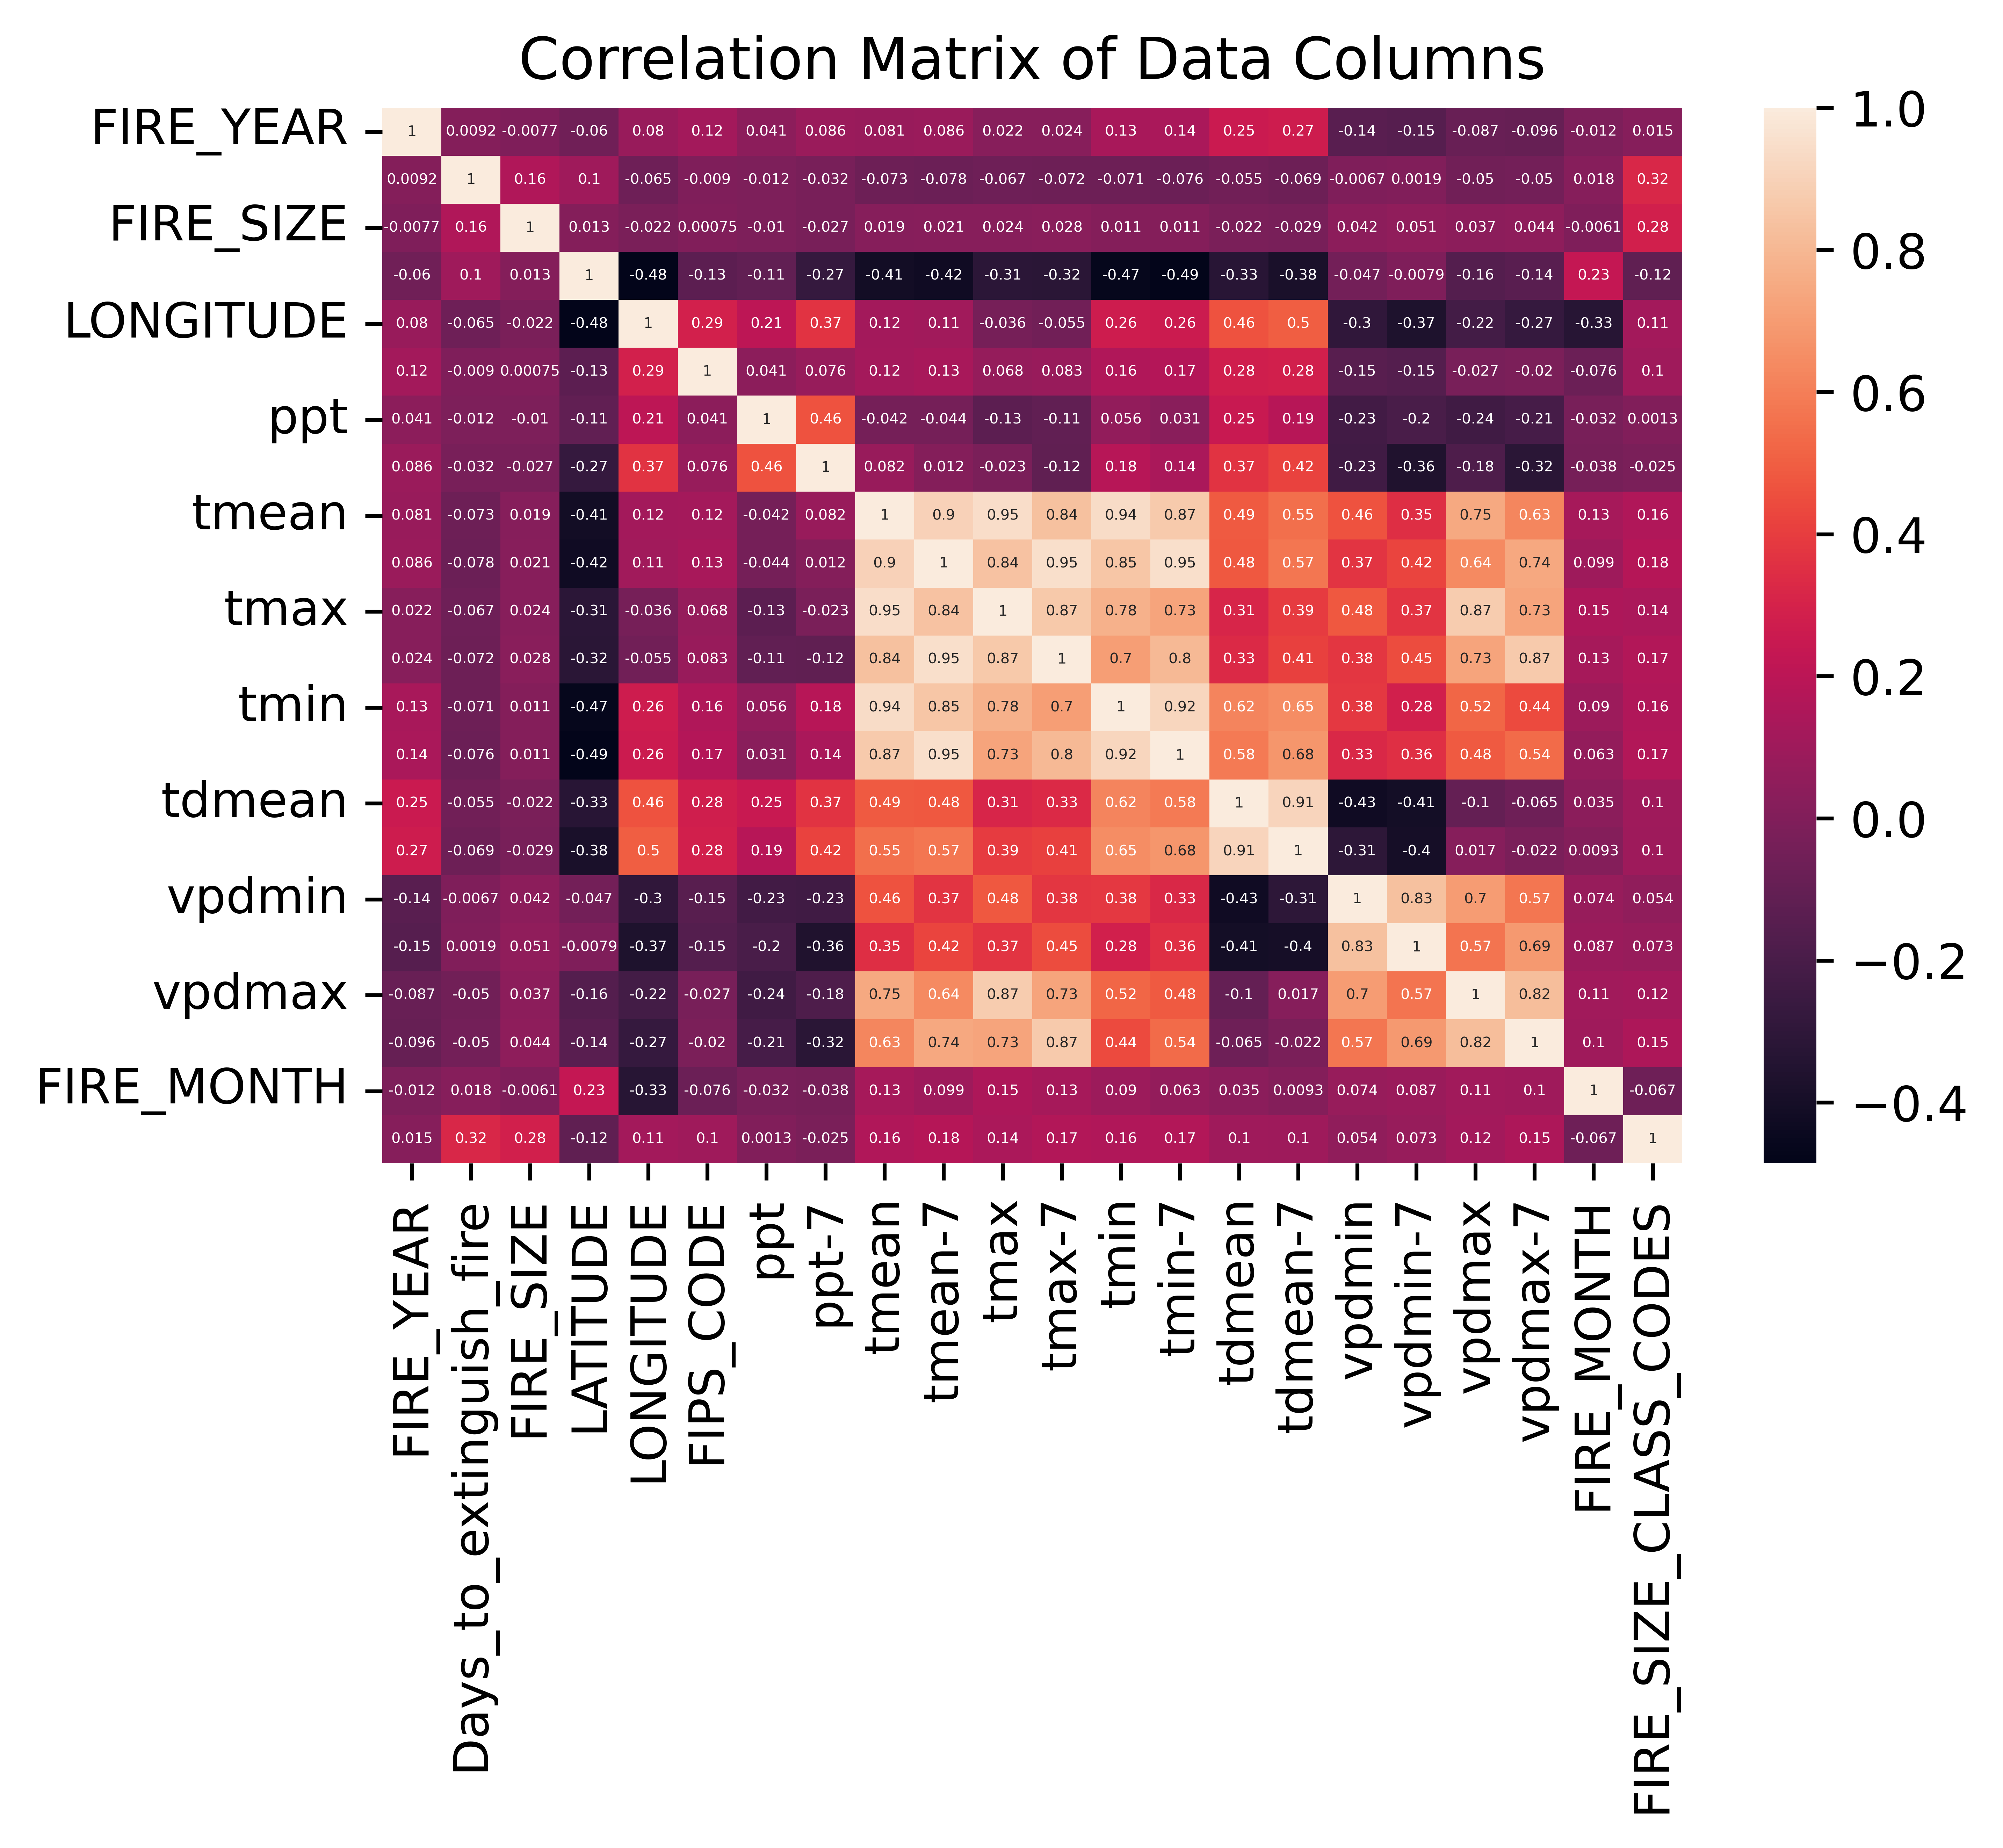

In [16]:
# plot corr matrix
fig1, ax = plt.subplots(dpi=1000)

sns.heatmap(
    df_norm.corr(),
    annot = True,
    annot_kws={"fontsize":3},
    ax=ax,
    cbar=True,
)
ax.set_title('Correlation Matrix of Data Columns')
plt.show()

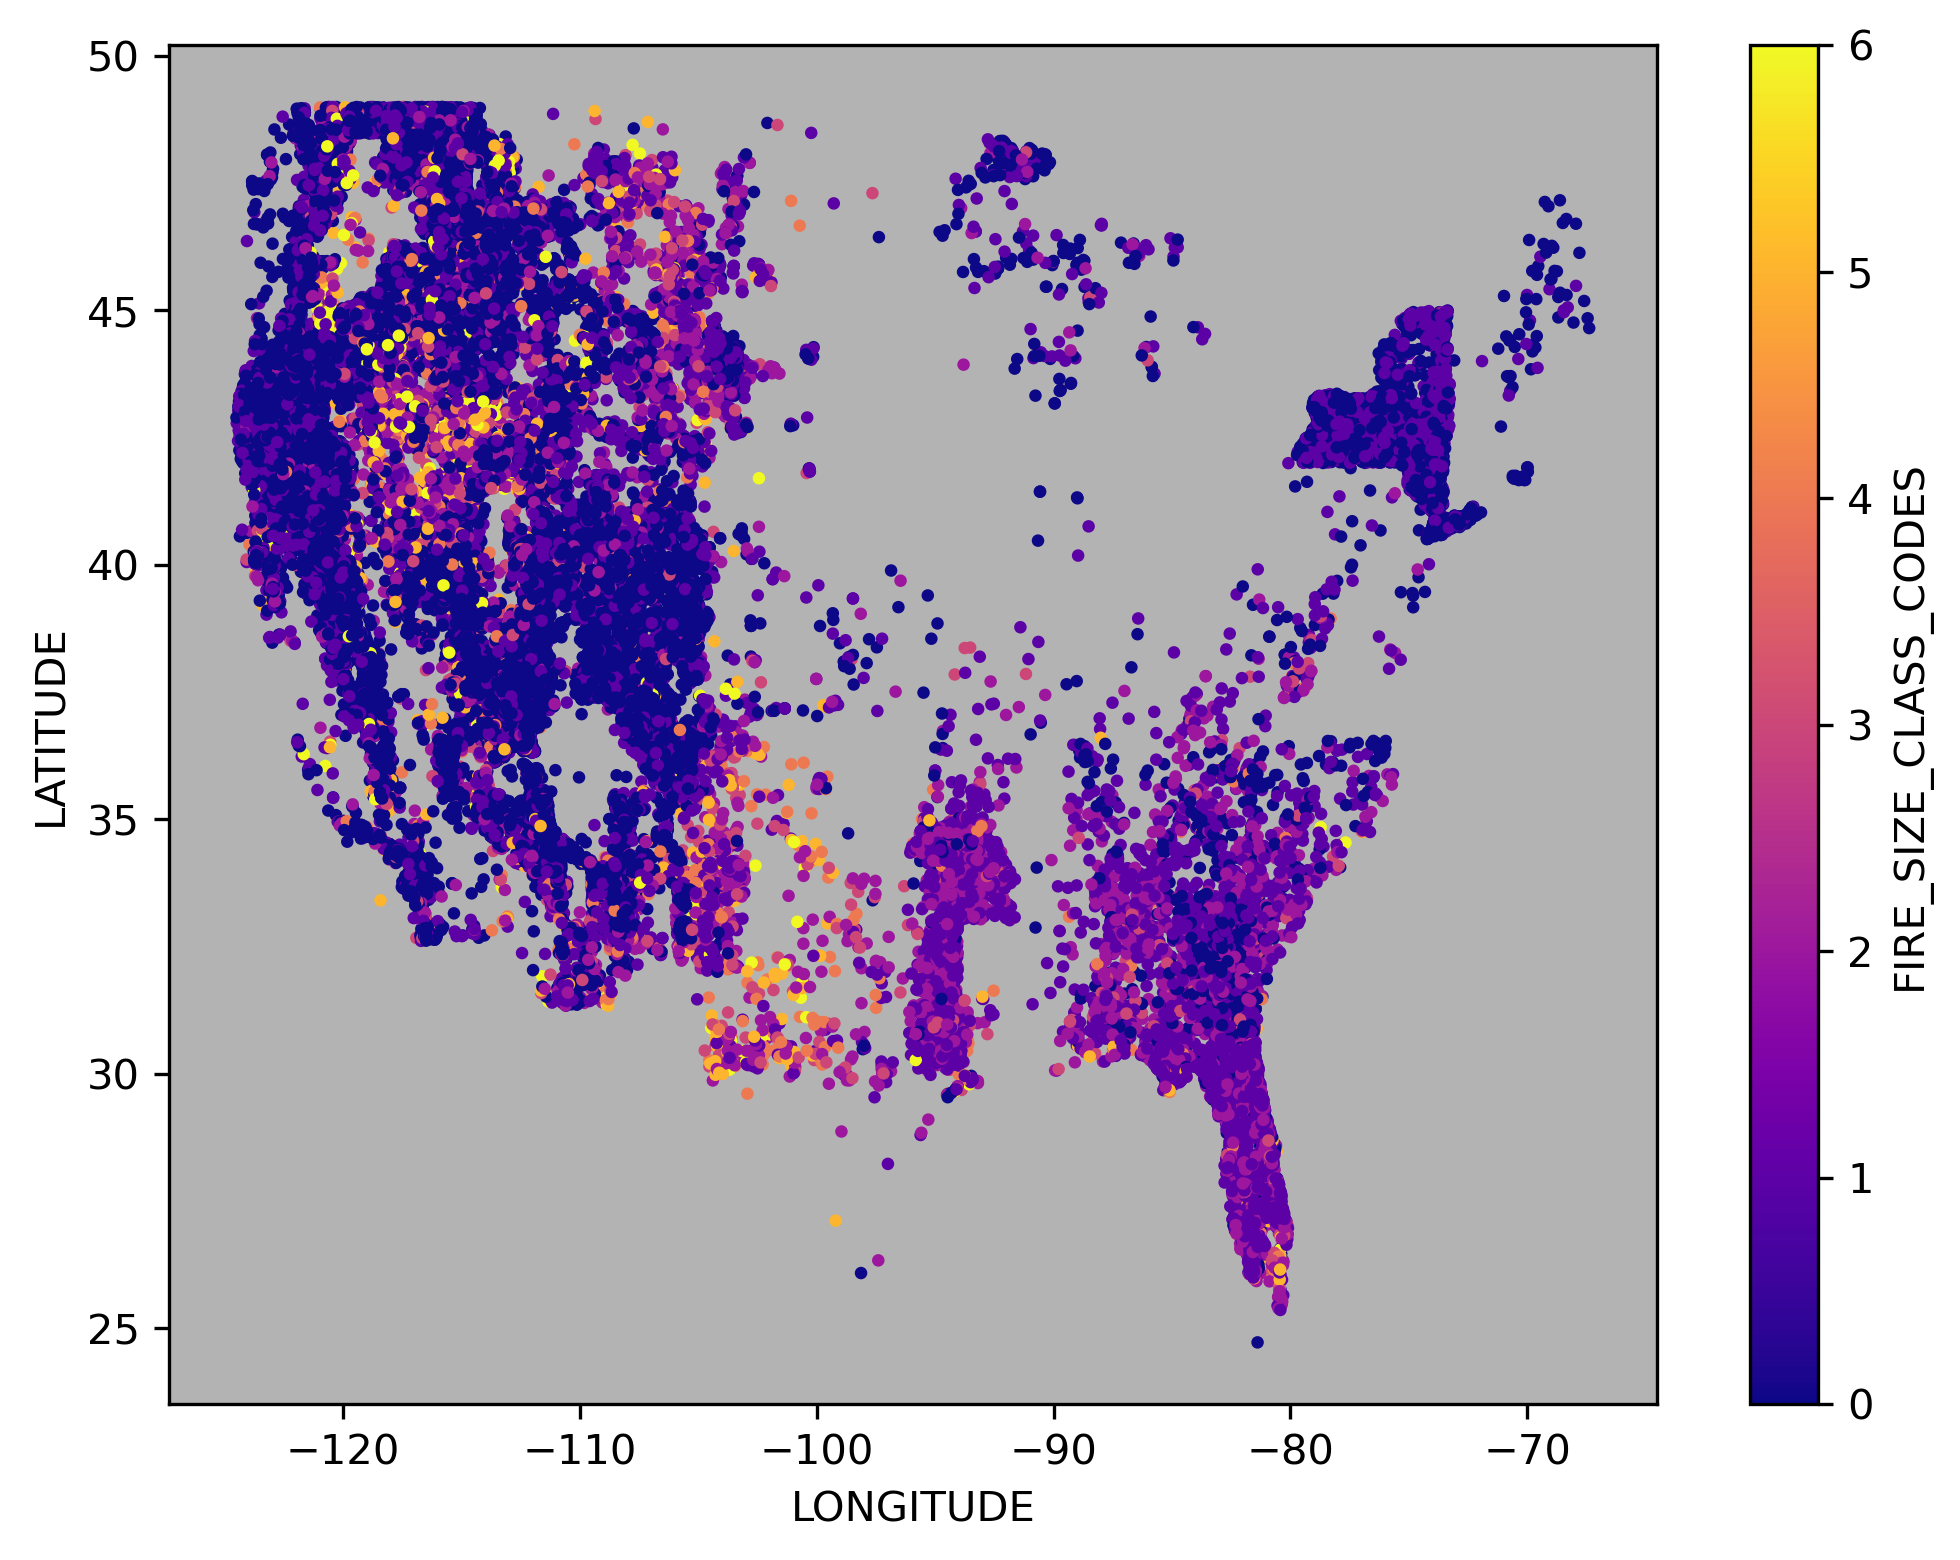

In [123]:
loglat_fig, loglat_ax = plt.subplots(
    figsize=(8,6),
    dpi=300,
)

df_cleaned.plot.scatter(x='LONGITUDE', y='LATITUDE', ax=loglat_ax, s=4, c='FIRE_SIZE_CLASS_CODES', colormap='plasma')
loglat_ax.set_facecolor((0.7, 0.7, 0.7))
for ext in save_formats:
    loglat_fig.savefig(figure_dir / f'log_lat_scatter.{ext}')

plt.show()

It looks like there is wildfire data all over the US, but let's check out the concentration across latitudes

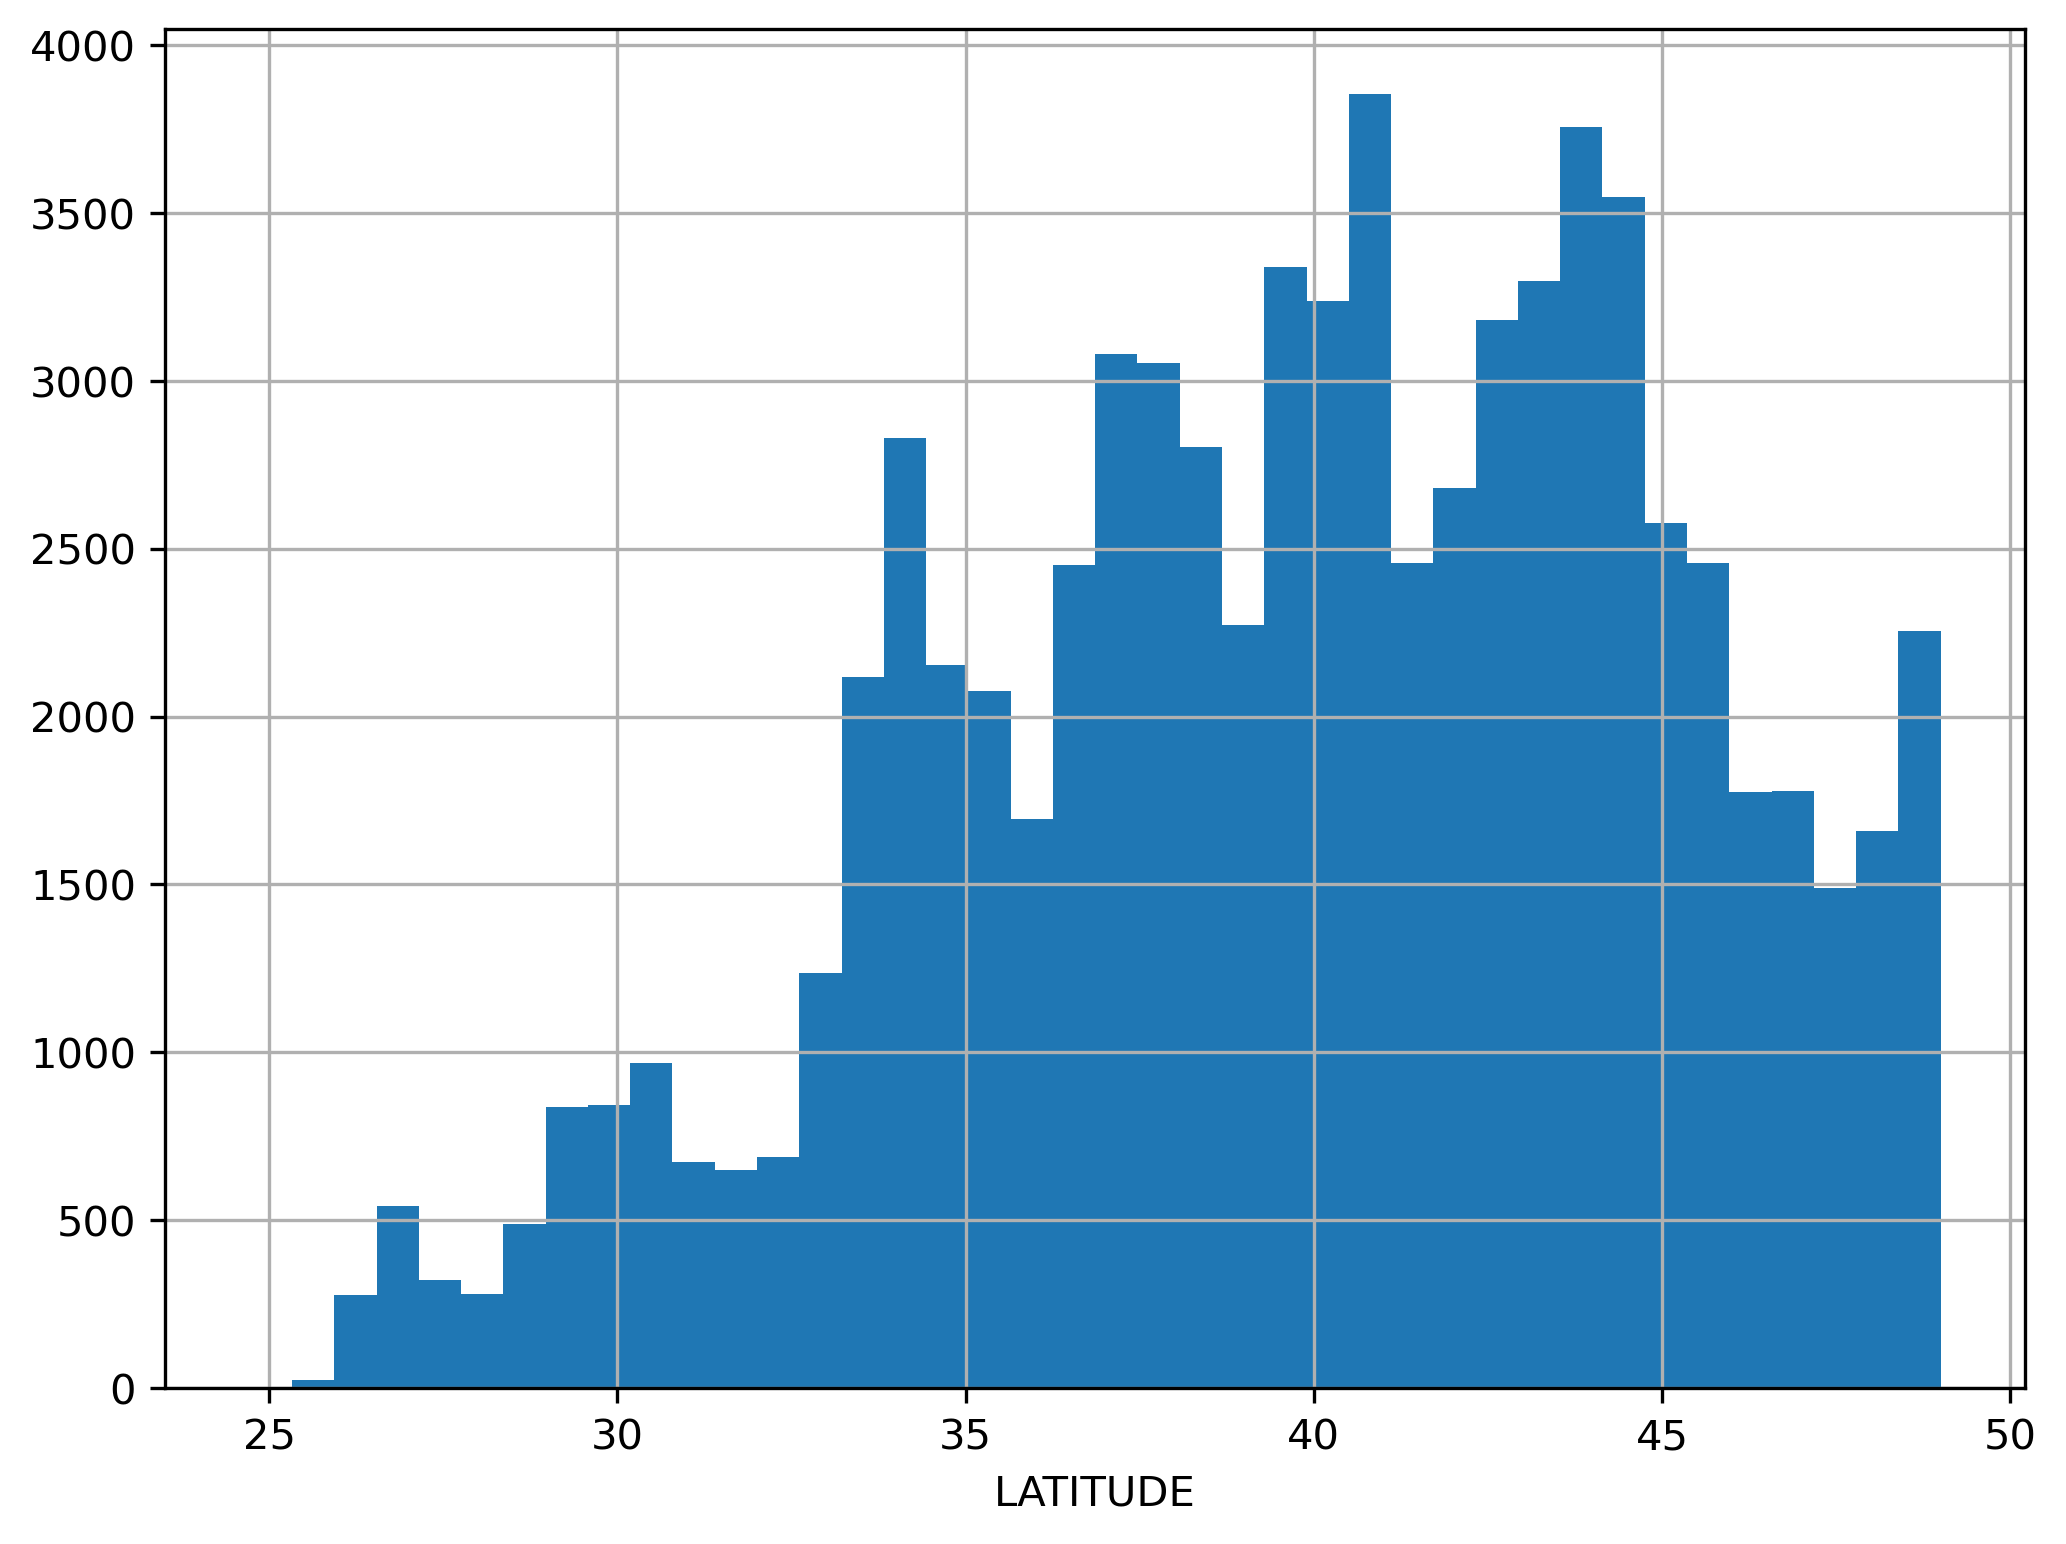

In [18]:
lat_hist_fig, lat_hist_ax = plt.subplots(
    figsize=(8,6),
    dpi=300,
)

df_cleaned.LATITUDE.hist(bins=40, ax=lat_hist_ax)
lat_hist_ax.set_xlabel('LATITUDE')

for ext in save_formats:
    lat_hist_fig.savefig(figure_dir / f'log_hist.{ext}')

plt.show()

It seems to be fairly spread out along the country, focused around 40, which may just be due to the increased land mass under consideration along that stretch. Let's compare to the distribution of fire month

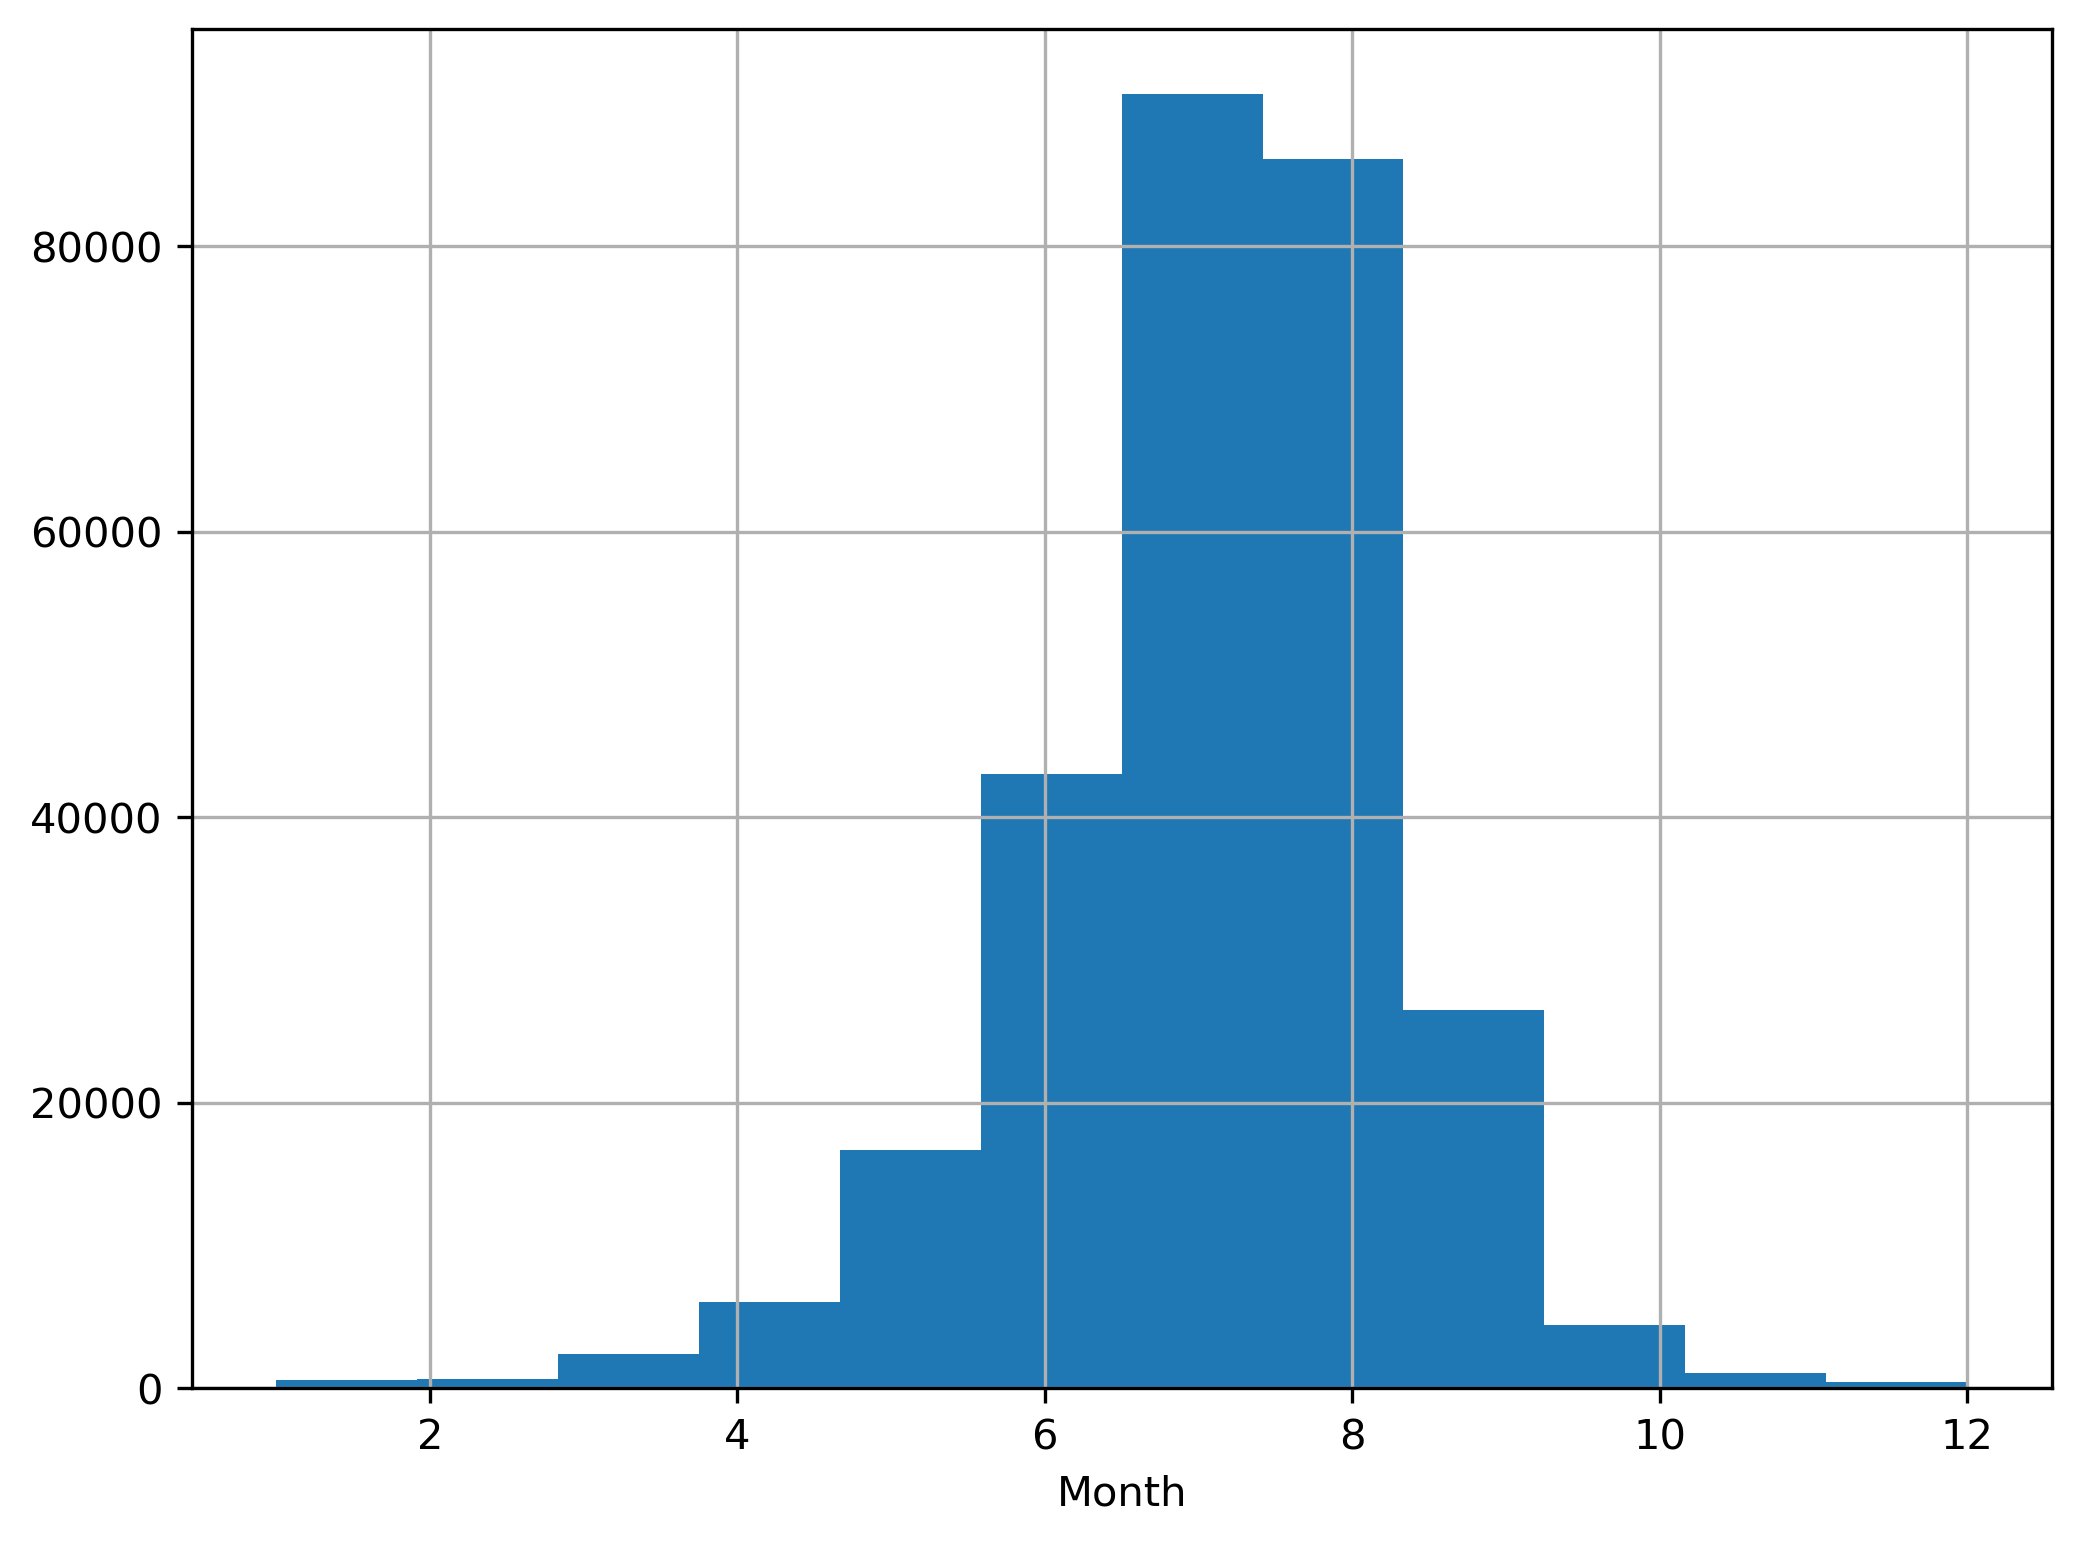

In [19]:
month_hist_fig, month_hist_ax = plt.subplots(
    figsize=(8,6),
    dpi=300,
)

df.Fire_Date.dt.month.hist(bins=12, ax=month_hist_ax)
month_hist_ax.set_xlabel('Month')

for ext in save_formats:
    month_hist_fig.savefig(figure_dir / f'month_hist.{ext}')

plt.show()

We do the same as the last cell, but by week of the year.

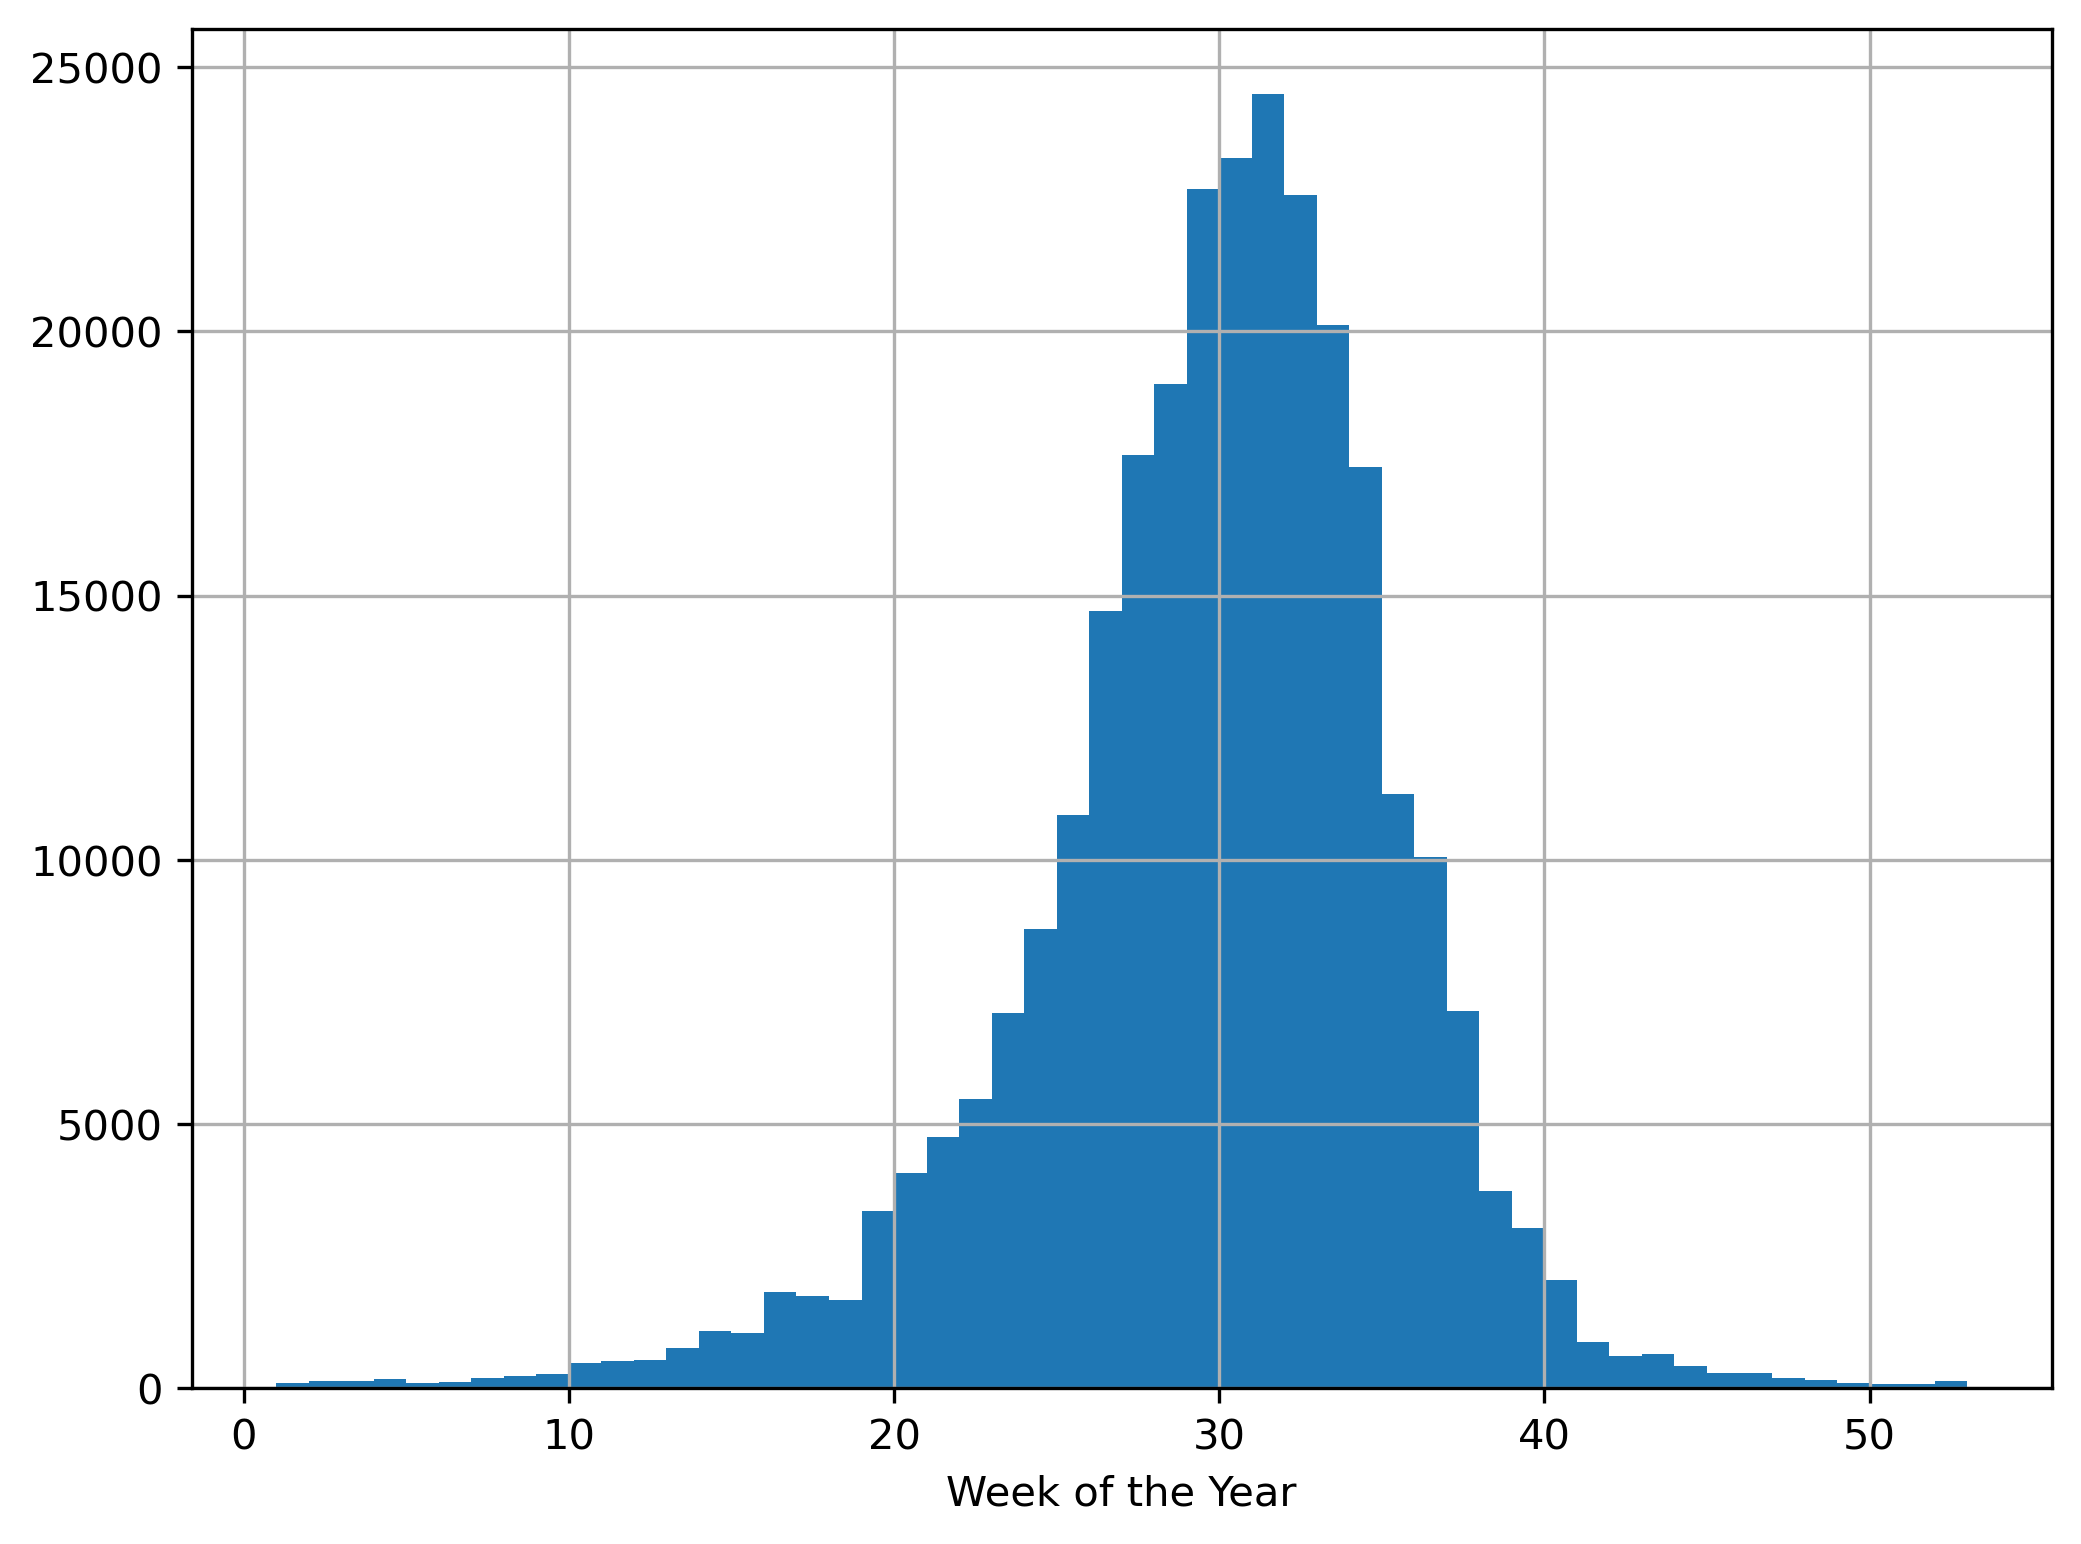

In [20]:
week_hist_fig, week_hist_ax = plt.subplots(
    figsize=(8,6),
    dpi=300,
)

df.Fire_Date.dt.isocalendar().week.hist(bins=52, ax=week_hist_ax)
week_hist_ax.set_xlabel('Week of the Year')

for ext in save_formats:
    week_hist_fig.savefig(figure_dir / f'week_hist.{ext}')

plt.show()

This is understandably very concentrated around the summer months, especially July and August. It is surprising that the month of the fire is not considered one of the better subset parameters in this dataset with class of fire as the target variable.

# Classification

In [143]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [144]:
classes_cleaned = df_days.FIRE_SIZE_CLASS[no_nan_rows]

In [145]:
df_class = df_cleaned[numeric_cols].drop(['FIRE_SIZE', 'FIRE_SIZE_CLASS_CODES'], axis=1)
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(
    df_class,
    classes_cleaned,
    test_size=0.2,
    random_state=625_742, # class code for random number seed
)
display(df_class.columns)

Index(['FIRE_YEAR', 'Days_to_extinguish_fire', 'LATITUDE', 'LONGITUDE',
       'FIPS_CODE', 'ppt', 'ppt-7', 'tmean', 'tmean-7', 'tmax', 'tmax-7',
       'tmin', 'tmin-7', 'tdmean', 'tdmean-7', 'vpdmin', 'vpdmin-7', 'vpdmax',
       'vpdmax-7', 'FIRE_MONTH'],
      dtype='object')

In [176]:
df_class_results = pd.DataFrame(
    data=[],
    index=[
        'LDA',
        'RRLDA',
        'QDA',
        'Logistic',
        'KNN',
        'SVM',
    ],
    columns=['accuracy'],
)

In [147]:
def plot_classification_accuracy(y_hat, y_test, x_test):
    class_acc_fig, class_acc_ax = plt.subplots(
    figsize=(8,6),
    dpi=300,
    )
    correctIdxs = y_hat==y_test
    correctlyClassified = x_test.iloc[correctIdxs.values,:]
    correctlyClassified.plot.scatter(x='LONGITUDE', y='LATITUDE', ax=class_acc_ax, c='blue', s=6)

    incorrectlyClassified = x_test.iloc[~correctIdxs.values,:]
    incorrectlyClassified.plot.scatter(x='LONGITUDE', y='LATITUDE', ax=class_acc_ax, c='red', s=6)
    
    return class_acc_fig, class_acc_ax


In [148]:
def plot_variable_histograms(y_hat, y_test, x_test):
    class_hist_fig, class_hist_ax = plt.subplots(
        nrows = 5,
        ncols = 4,
        figsize=(8,6),
        dpi=300,
    )
    all_axes = class_hist_ax.flatten()
    class_hist_fig.subplots_adjust(hspace=1)
    variables = X_class_test.columns.tolist()
    correctIdxs = y_hat==y_test
    correctlyClassified = x_test.iloc[correctIdxs.values,:]

    incorrectlyClassified = x_test.iloc[~correctIdxs.values,:]

    for i in range(0,len(variables)):
        var = variables[i]
        ax_here = all_axes[i]

        ax_here.hist((correctlyClassified[var], incorrectlyClassified[var]),histtype='bar', color=['blue', 'red'])
        ax_here.tick_params(axis='x', labelsize=6)
        ax_here.tick_params(axis='y', labelsize=6)
        ax_here.set_title(var, fontsize=8)
        
    return class_hist_fig, class_hist_ax

In [149]:
def plot_fire_code_histograms(y_hat, y_test):
    fire_code_fig, fire_code_ax = plt.subplots(
        figsize=(8,6),
        dpi=300,
    )
    correctIdxs = y_hat==y_test
    correctlyClassified = y_test.iloc[correctIdxs.values].sort_values(inplace=False)

    incorrectlyClassified = y_test.iloc[~correctIdxs.values].sort_values(inplace=False)

    fire_code_ax.hist((incorrectlyClassified, correctlyClassified),histtype='bar', color=['red', 'blue'], label = ['Incorrect', 'Correct'])
    fire_code_ax.tick_params(axis='x', labelsize=12)
    fire_code_ax.tick_params(axis='y', labelsize=12)
    fire_code_ax.set_title('Classification by Fire Class Code', fontsize=18)
    fire_code_ax.legend()
    
    return fire_code_fig, fire_code_ax


## LDA

Try to classify the fire sizes with Linear Discriminant Analysis as a baseline, but remove the FIRE_SIZE-specific columns, which would result in over performing.  Try the different LDA methods in Python

In [150]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

solvers = ['svd','lsqr','eigen']
# lda_accuracy = np.zeros((len(solvers),1))
lda_accuracy = []

for solver_name in solvers:

    lda = make_pipeline(
        StandardScaler(),
        LinearDiscriminantAnalysis(solver=solver_name),
    )

    lda.fit(X_class_train, y_class_train)
    y_lda = lda.predict(X_class_test)
    lda_accuracy.append(
        sum(y_lda==y_class_test)/len(y_lda)
    )

lda_results_df = pd.DataFrame(lda_accuracy,solvers,columns=['LDA accuracy'])

df_class_results.loc['LDA','accuracy'] = max(lda_accuracy)

display(lda_results_df)

LDA accuracy
svd        0.621904
lsqr       0.622102
eigen      0.622102

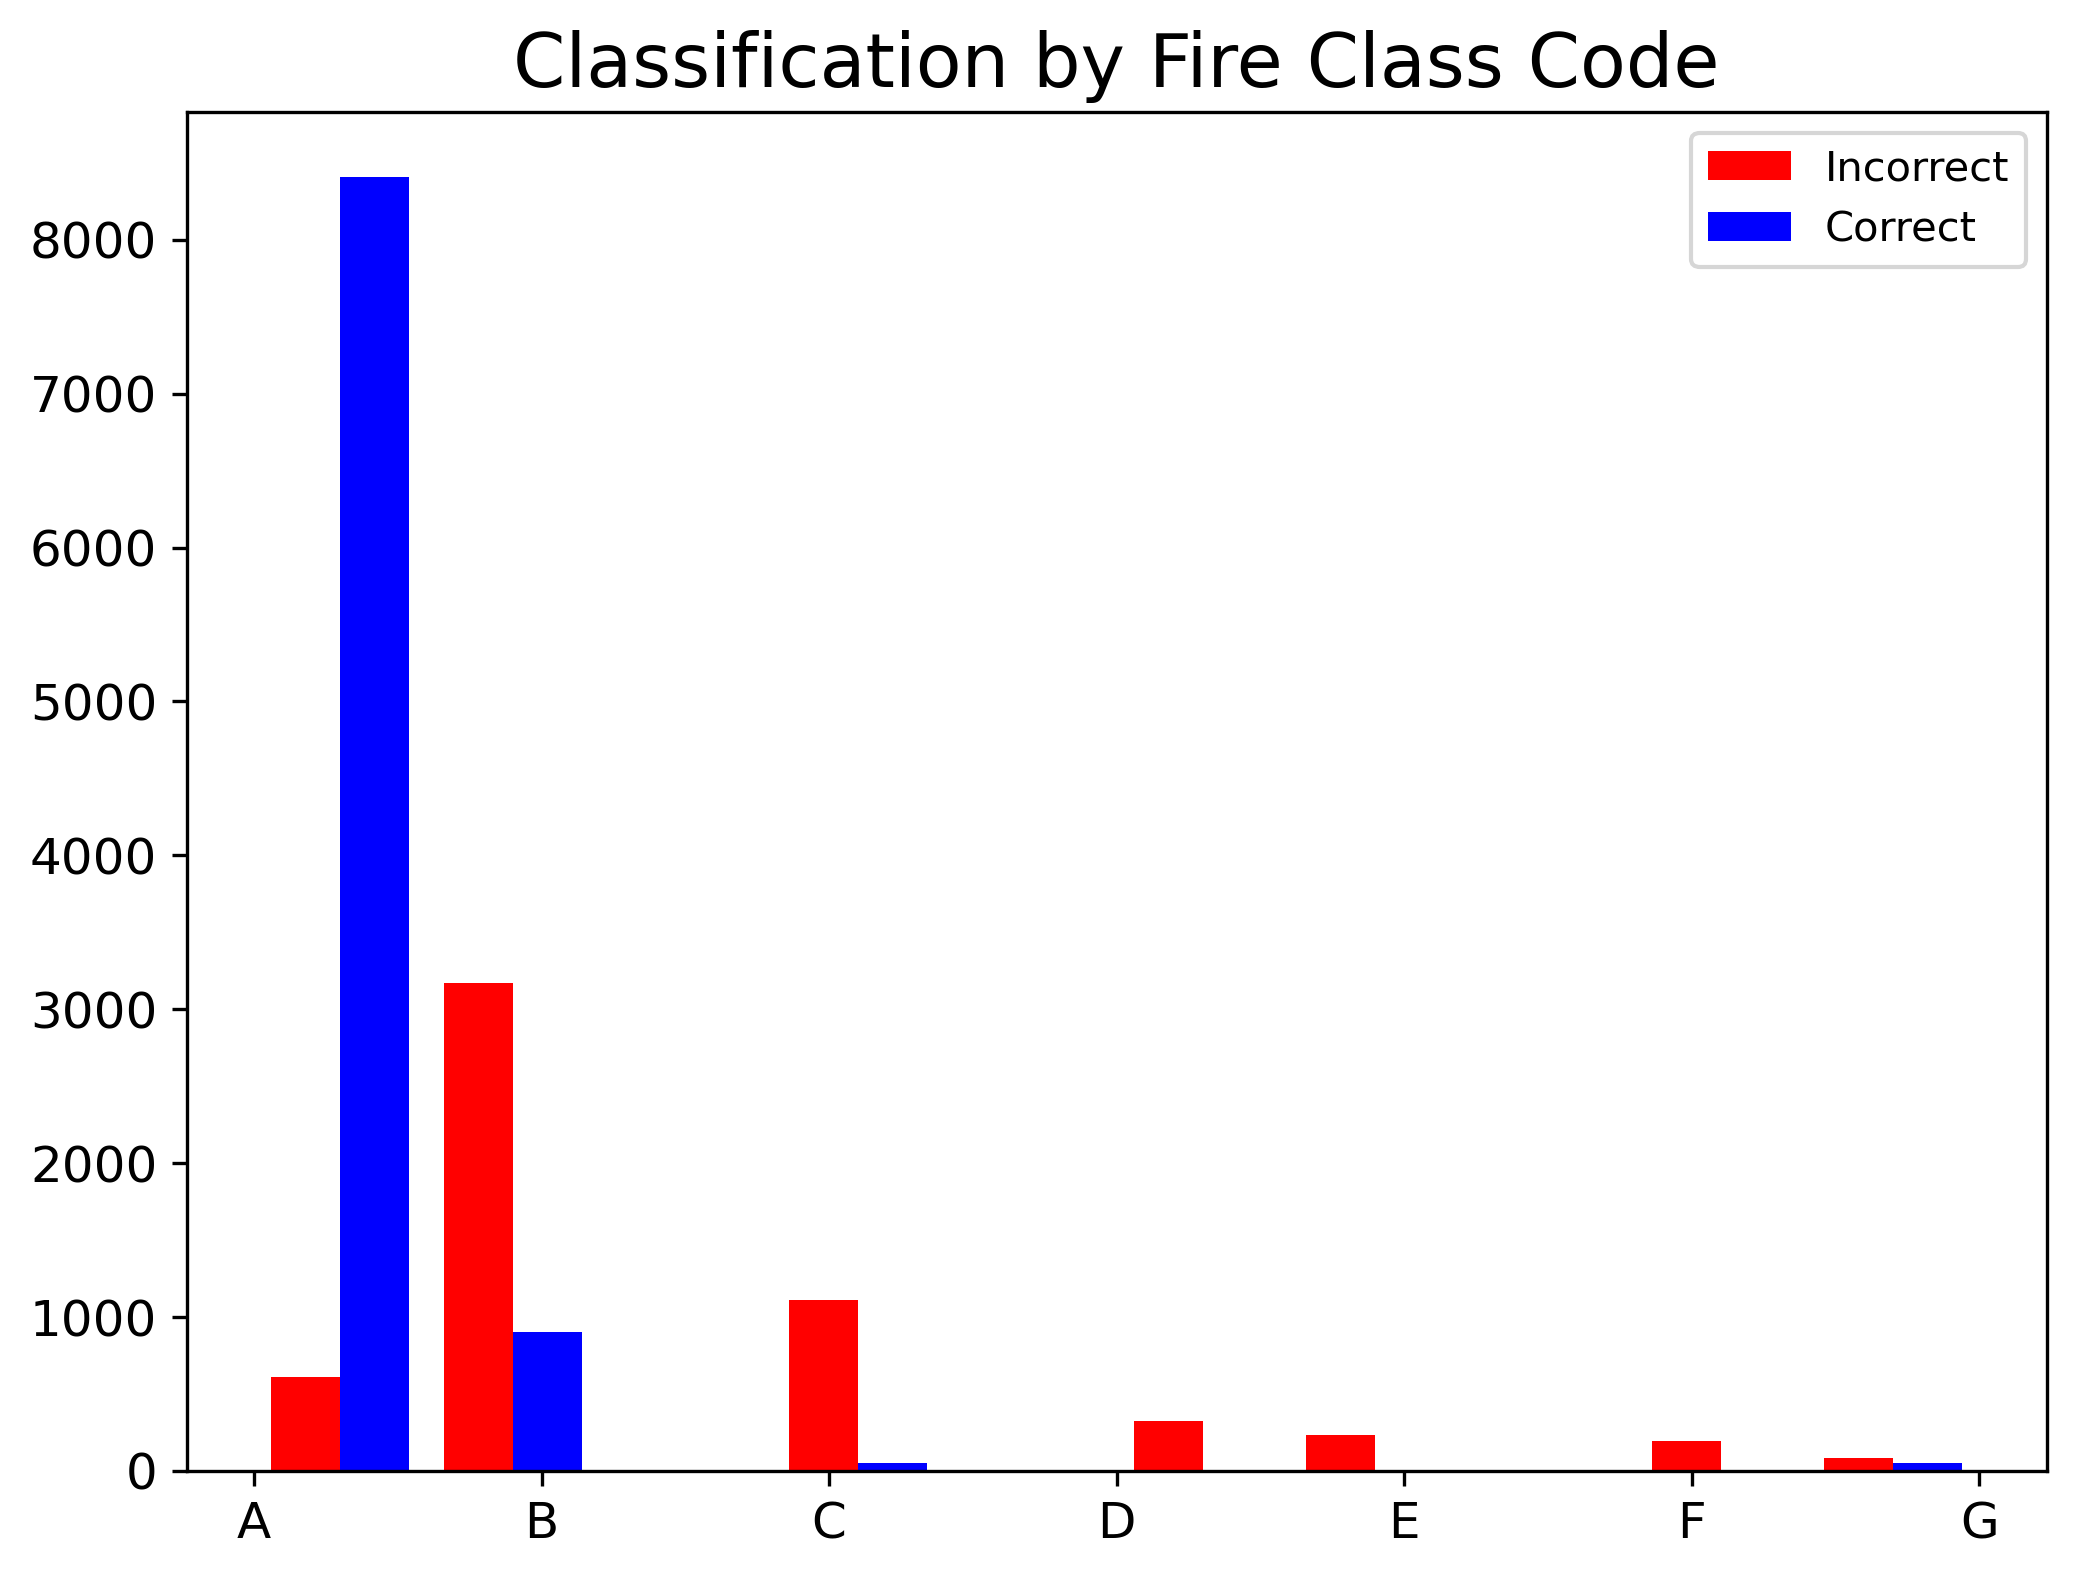

In [151]:
lda_fire_code_fig, lda_fire_code_ax = plot_fire_code_histograms(y_lda, y_class_test)

for ext in save_formats:
    lda_fire_code_fig.savefig(figure_dir / f'lda_fire_code_hist.{ext}')

plt.show()

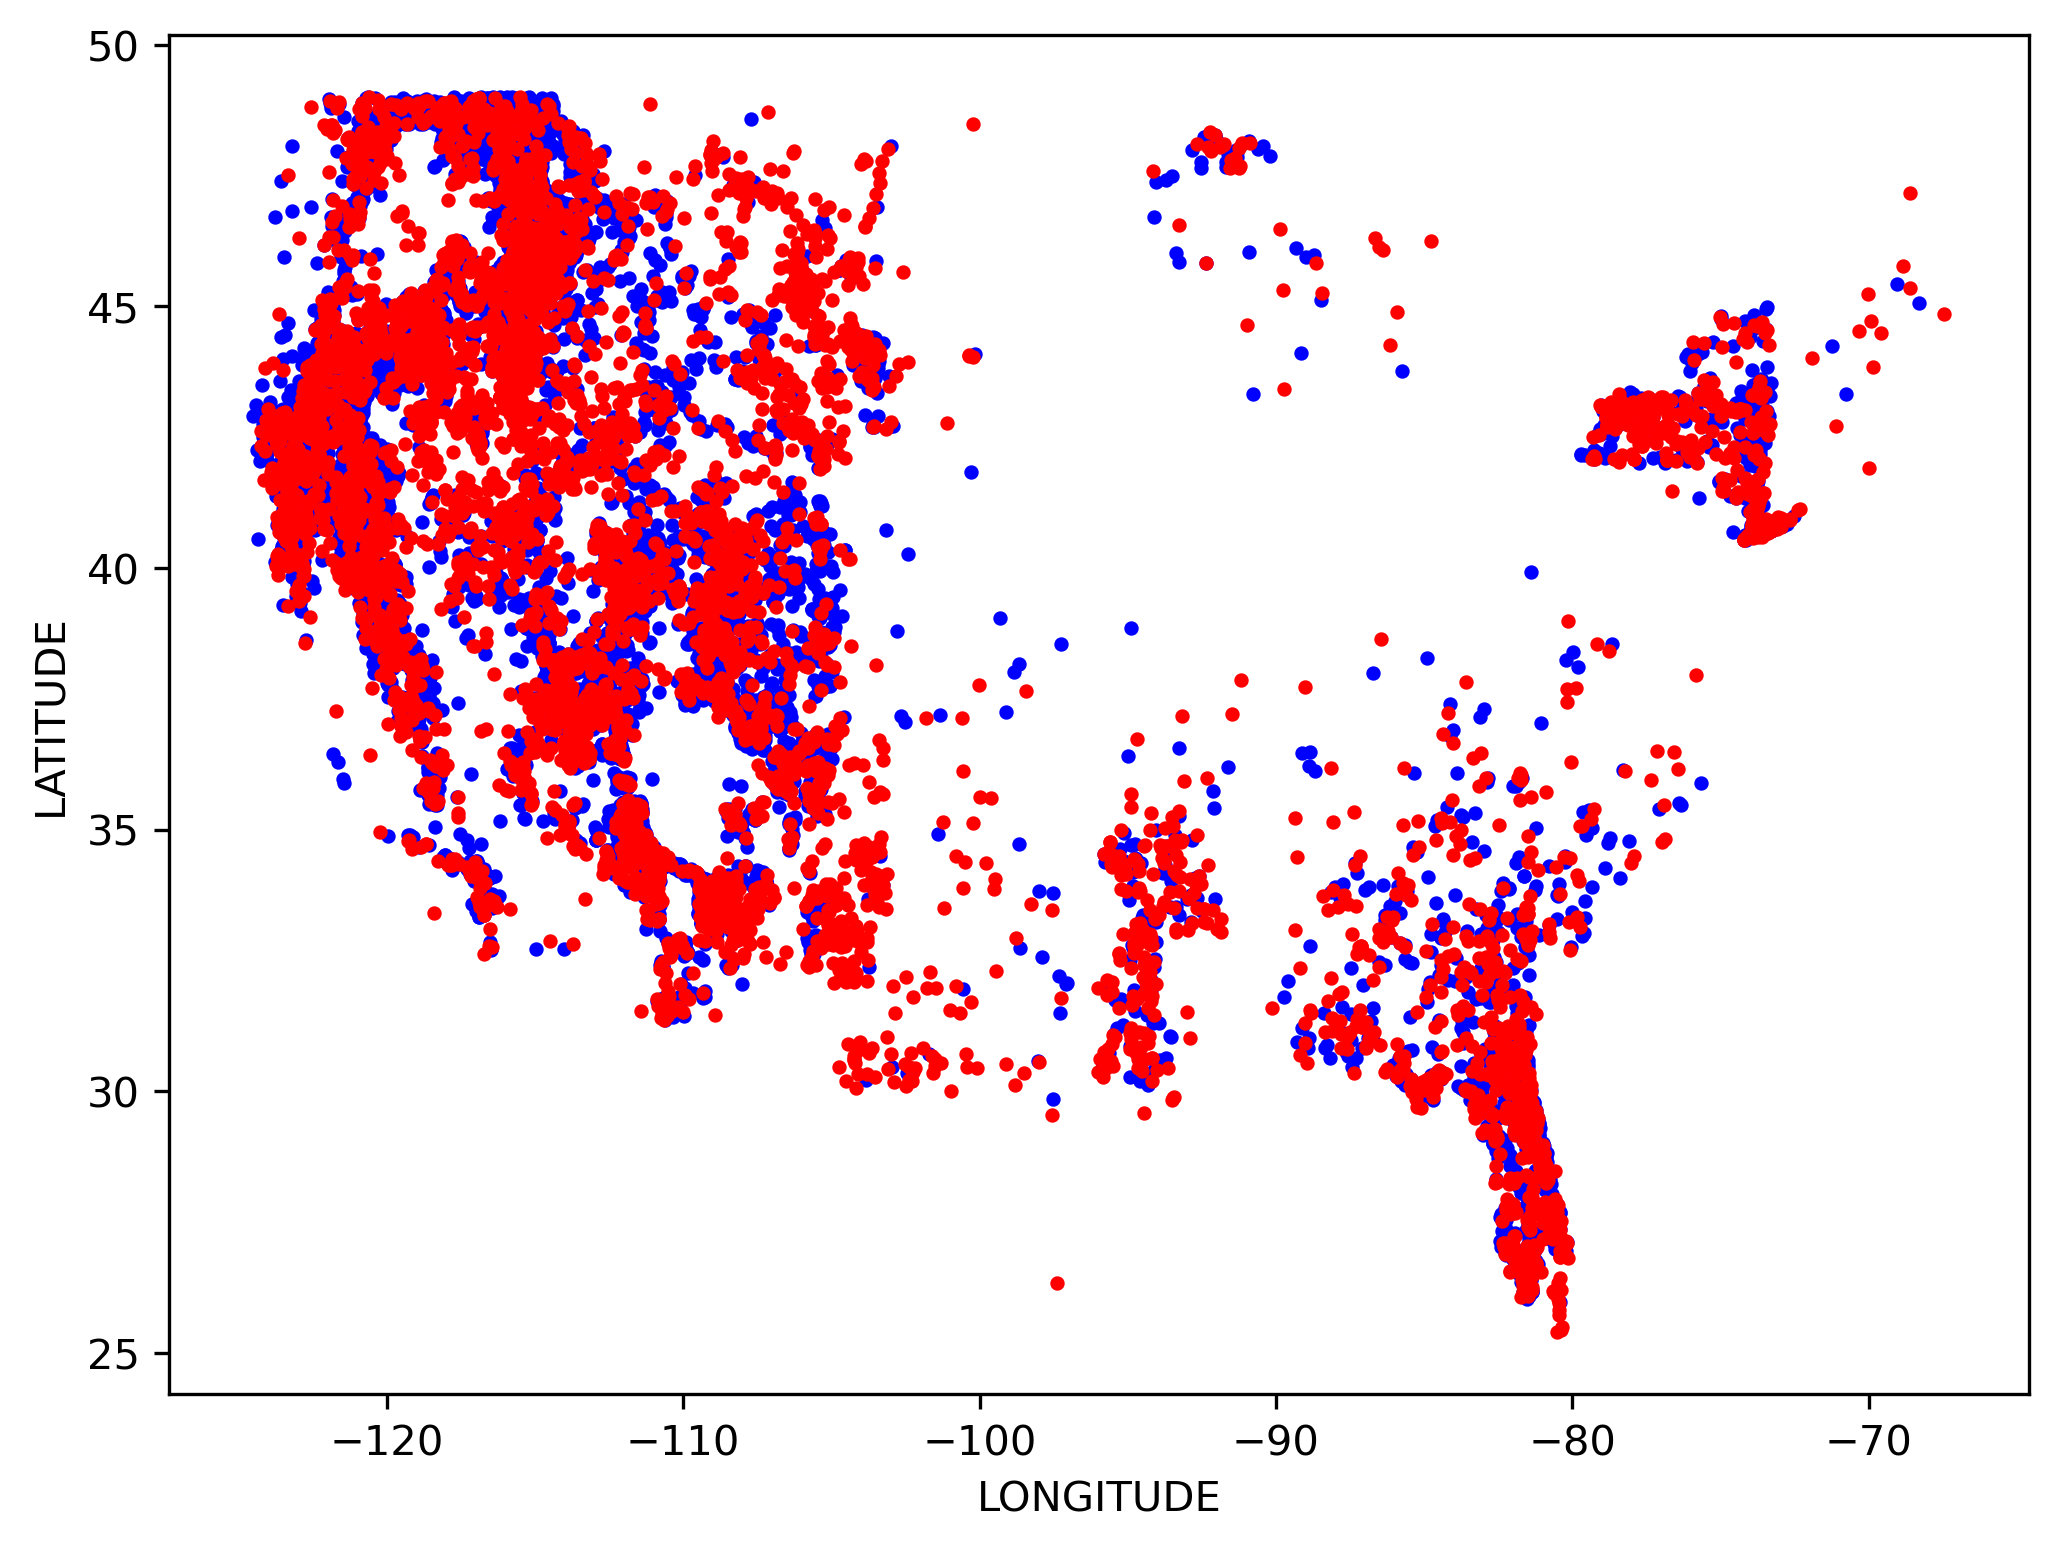

In [152]:
lda_class_acc_fig, lda_class_acc_ax = plot_classification_accuracy(y_lda, y_class_test, X_class_test)

for ext in save_formats:
    lda_class_acc_fig.savefig(figure_dir / f'lda_class_accuracy.{ext}')

plt.show()

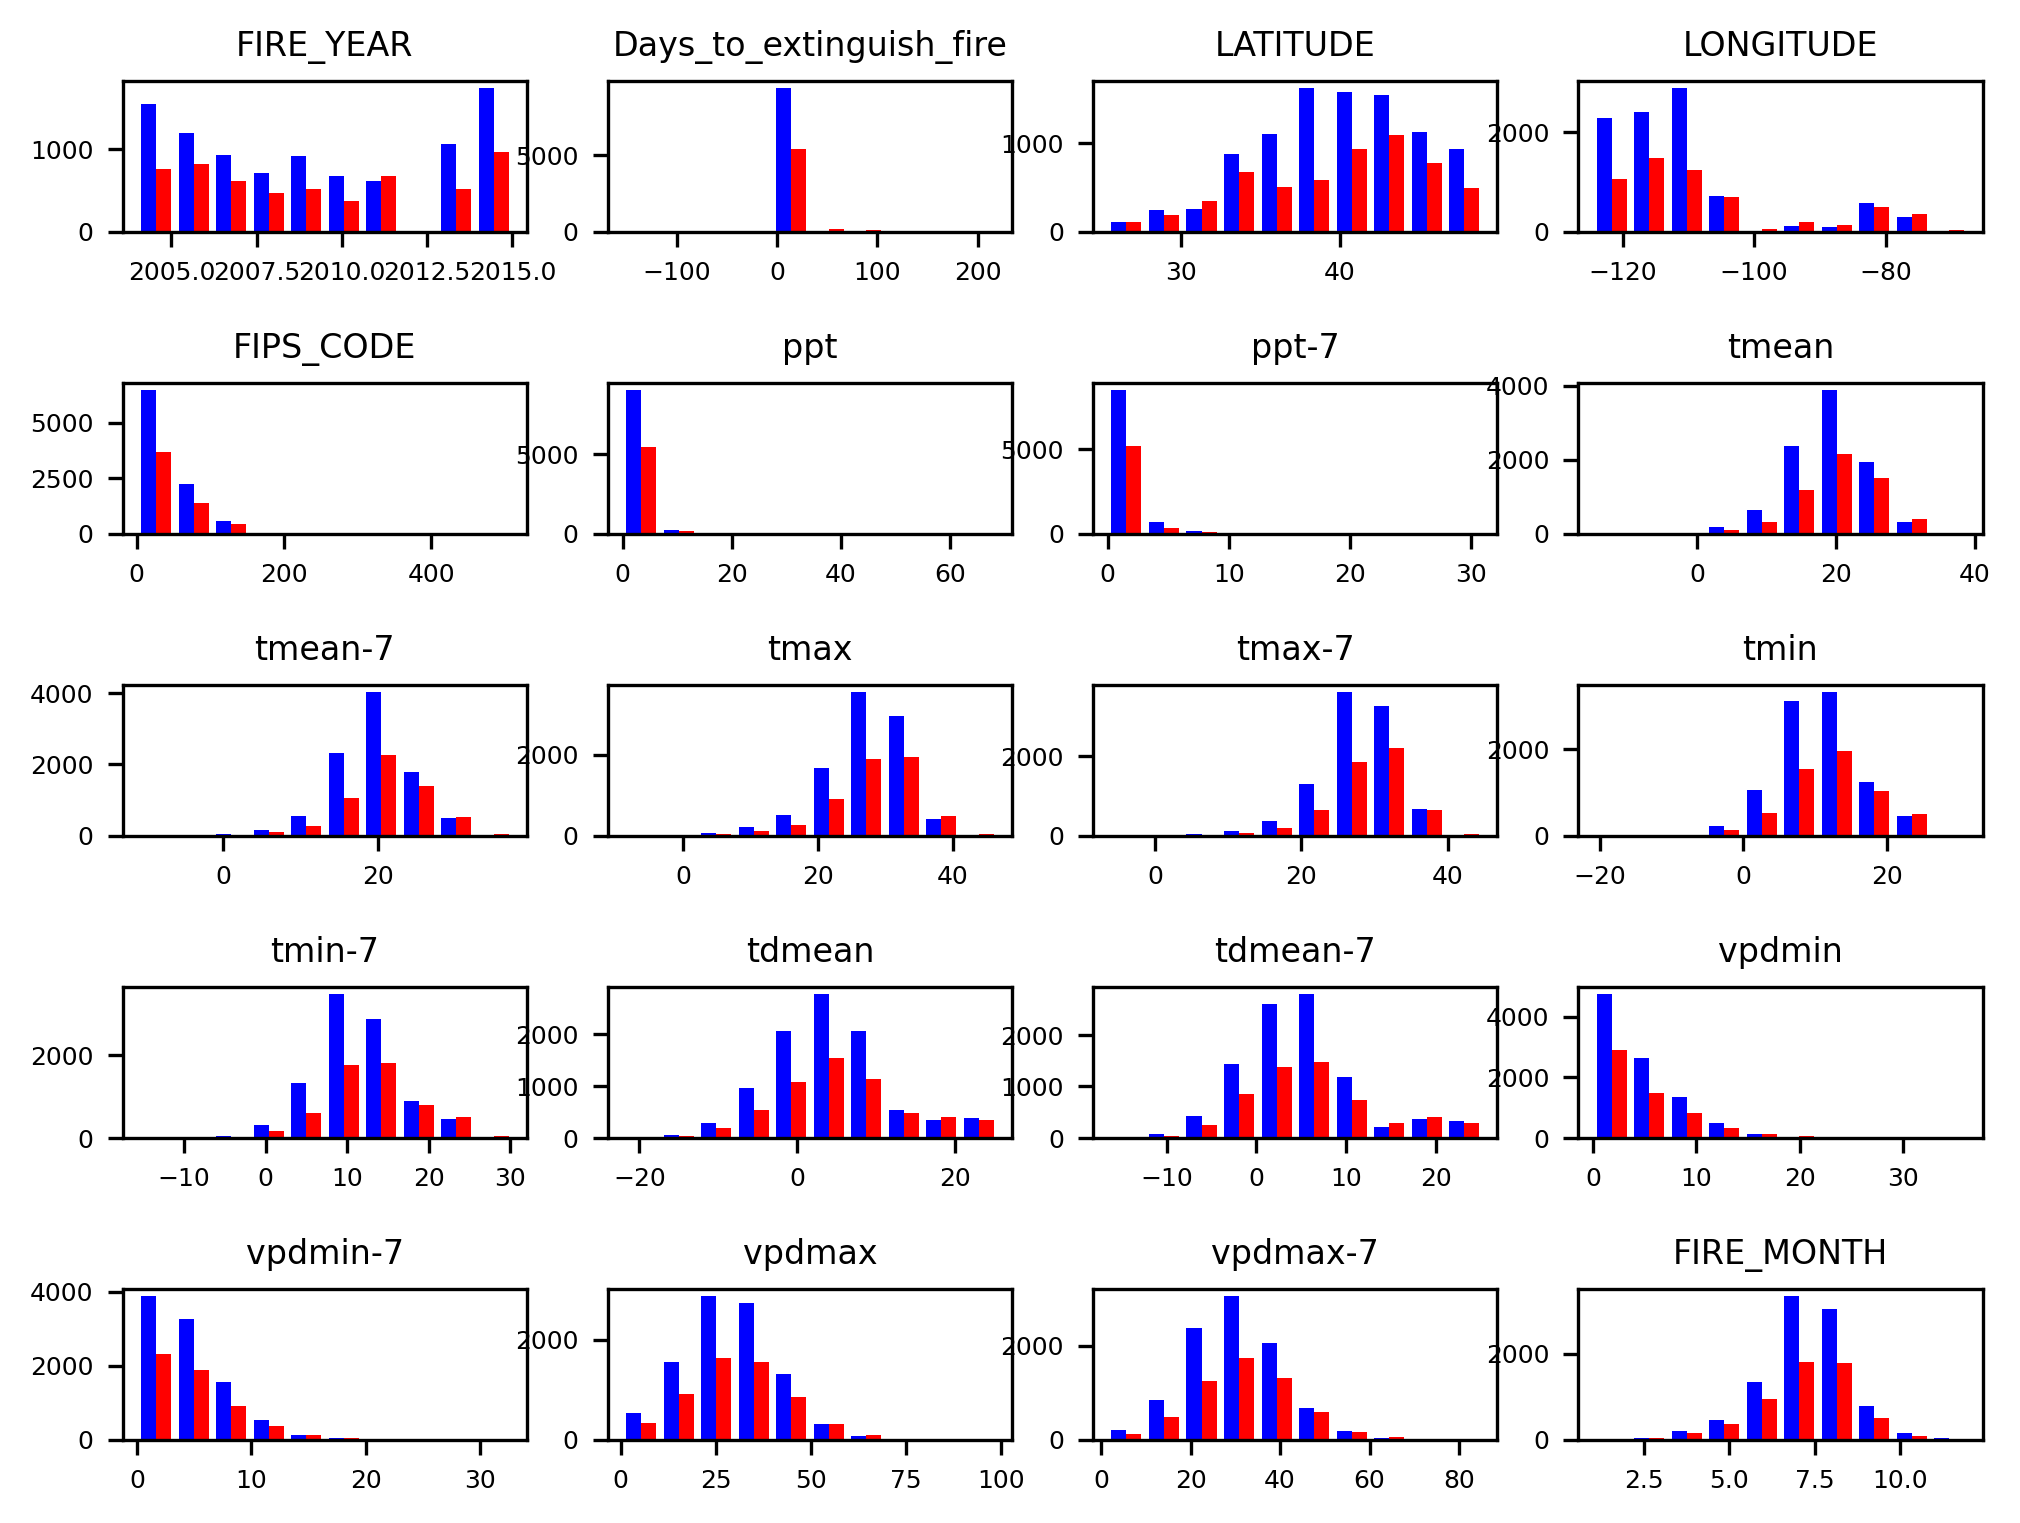

In [153]:
lda_var_hist_fig, lda_var_hist_ax = plot_variable_histograms(y_lda, y_class_test, X_class_test)

for ext in save_formats:
    lda_var_hist_fig.savefig(figure_dir / f'lda_var_hist.{ext}')

plt.show()

## Reduced Rank Linear Discriminant Analysis

In [178]:
p = len(df_class.columns)

solvers = ['svd','lsqr','eigen']

num_classes = len(classes_cleaned.unique())
rrlda_max_components = min(p, num_classes - 1)

df_rrlda = pd.DataFrame(
    data=[], 
    index=solvers,
    columns=[f'k={ii}' for ii in range(1, rrlda_max_components+1)],
)

for (k, solver) in itertools.product(range(1,rrlda_max_components+1), solvers):
    rrlda = make_pipeline(
        StandardScaler(),
        LinearDiscriminantAnalysis(n_components=k),
        LinearDiscriminantAnalysis(solver=solver_name),
    )

    rrlda.fit(X_class_train, y_class_train)
    y_rrlda = rrlda.predict(X_class_test)
    df_rrlda.loc[solver, f'k={k}'] = sum(y_rrlda==y_class_test)/len(y_rrlda)

df_class_results.loc['RRLDA','accuracy'] = df_rrlda.max().max()
    
display(df_rrlda)

k=1       k=2       k=3      k=4      k=5       k=6
svd    0.596341  0.623951  0.622168  0.62197  0.62197  0.621904
lsqr   0.596341  0.623951  0.622168  0.62197  0.62197  0.621904
eigen  0.596341  0.623951  0.622168  0.62197  0.62197  0.621904

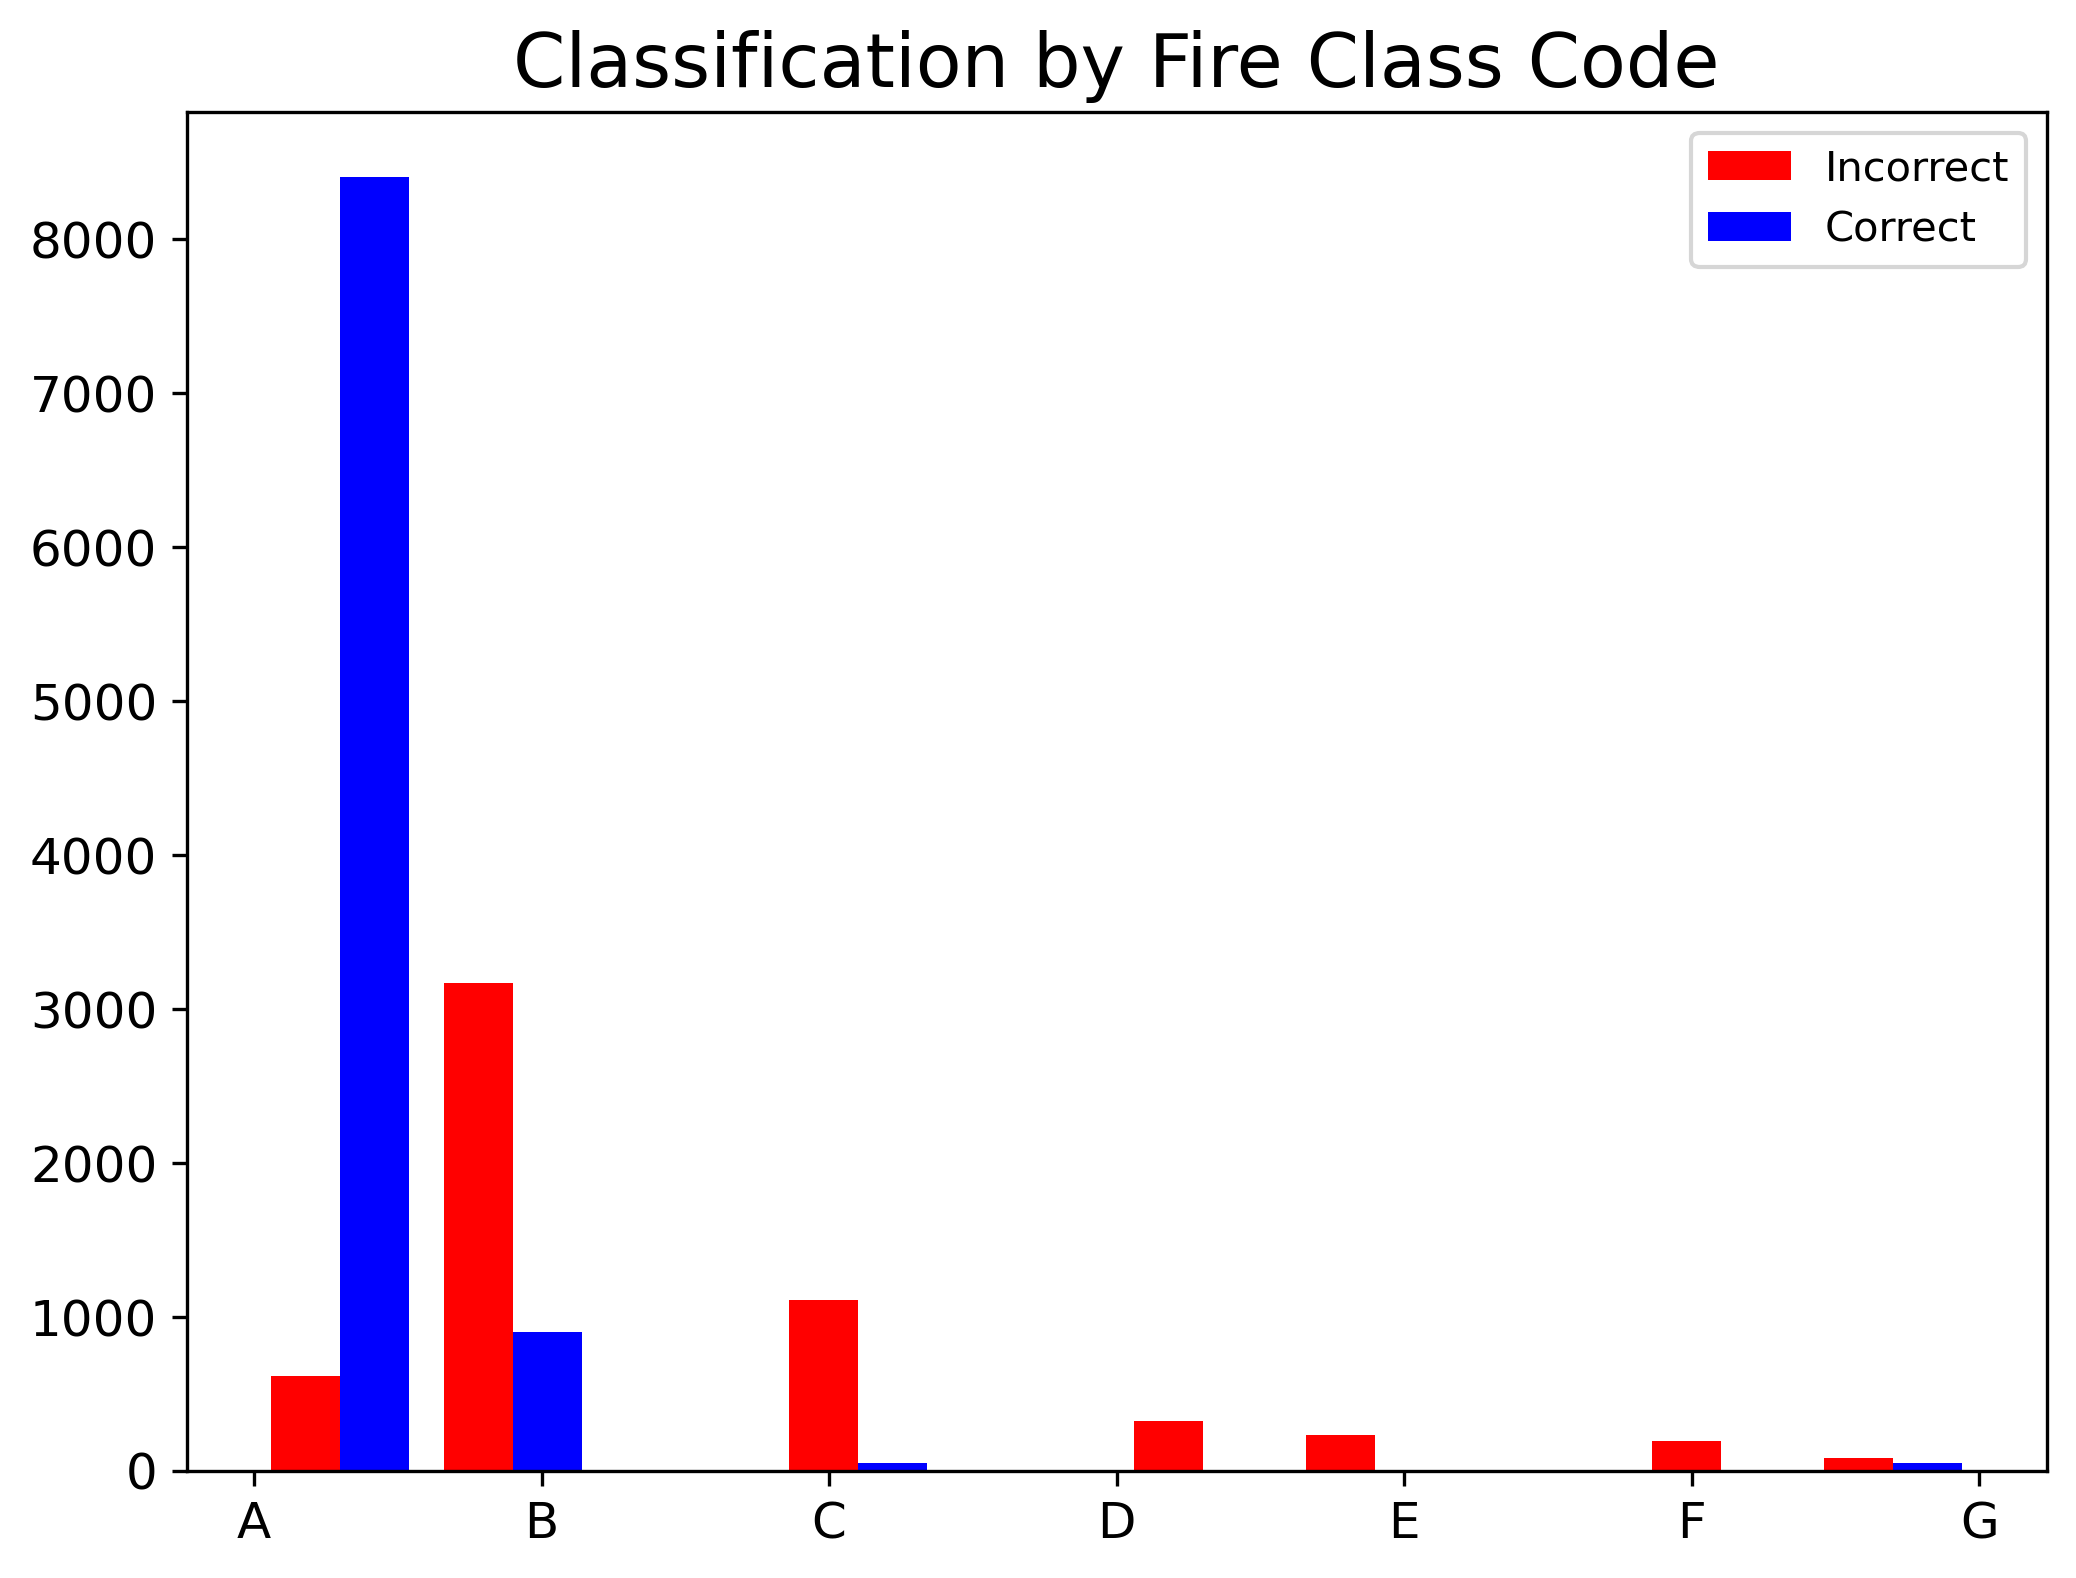

In [155]:
rrlda_fire_code_fig, rrlda_fire_code_ax = plot_fire_code_histograms(y_rrlda, y_class_test)

for ext in save_formats:
    rrlda_fire_code_fig.savefig(figure_dir / f'rrlda_fire_code_hist.{ext}')

plt.show()

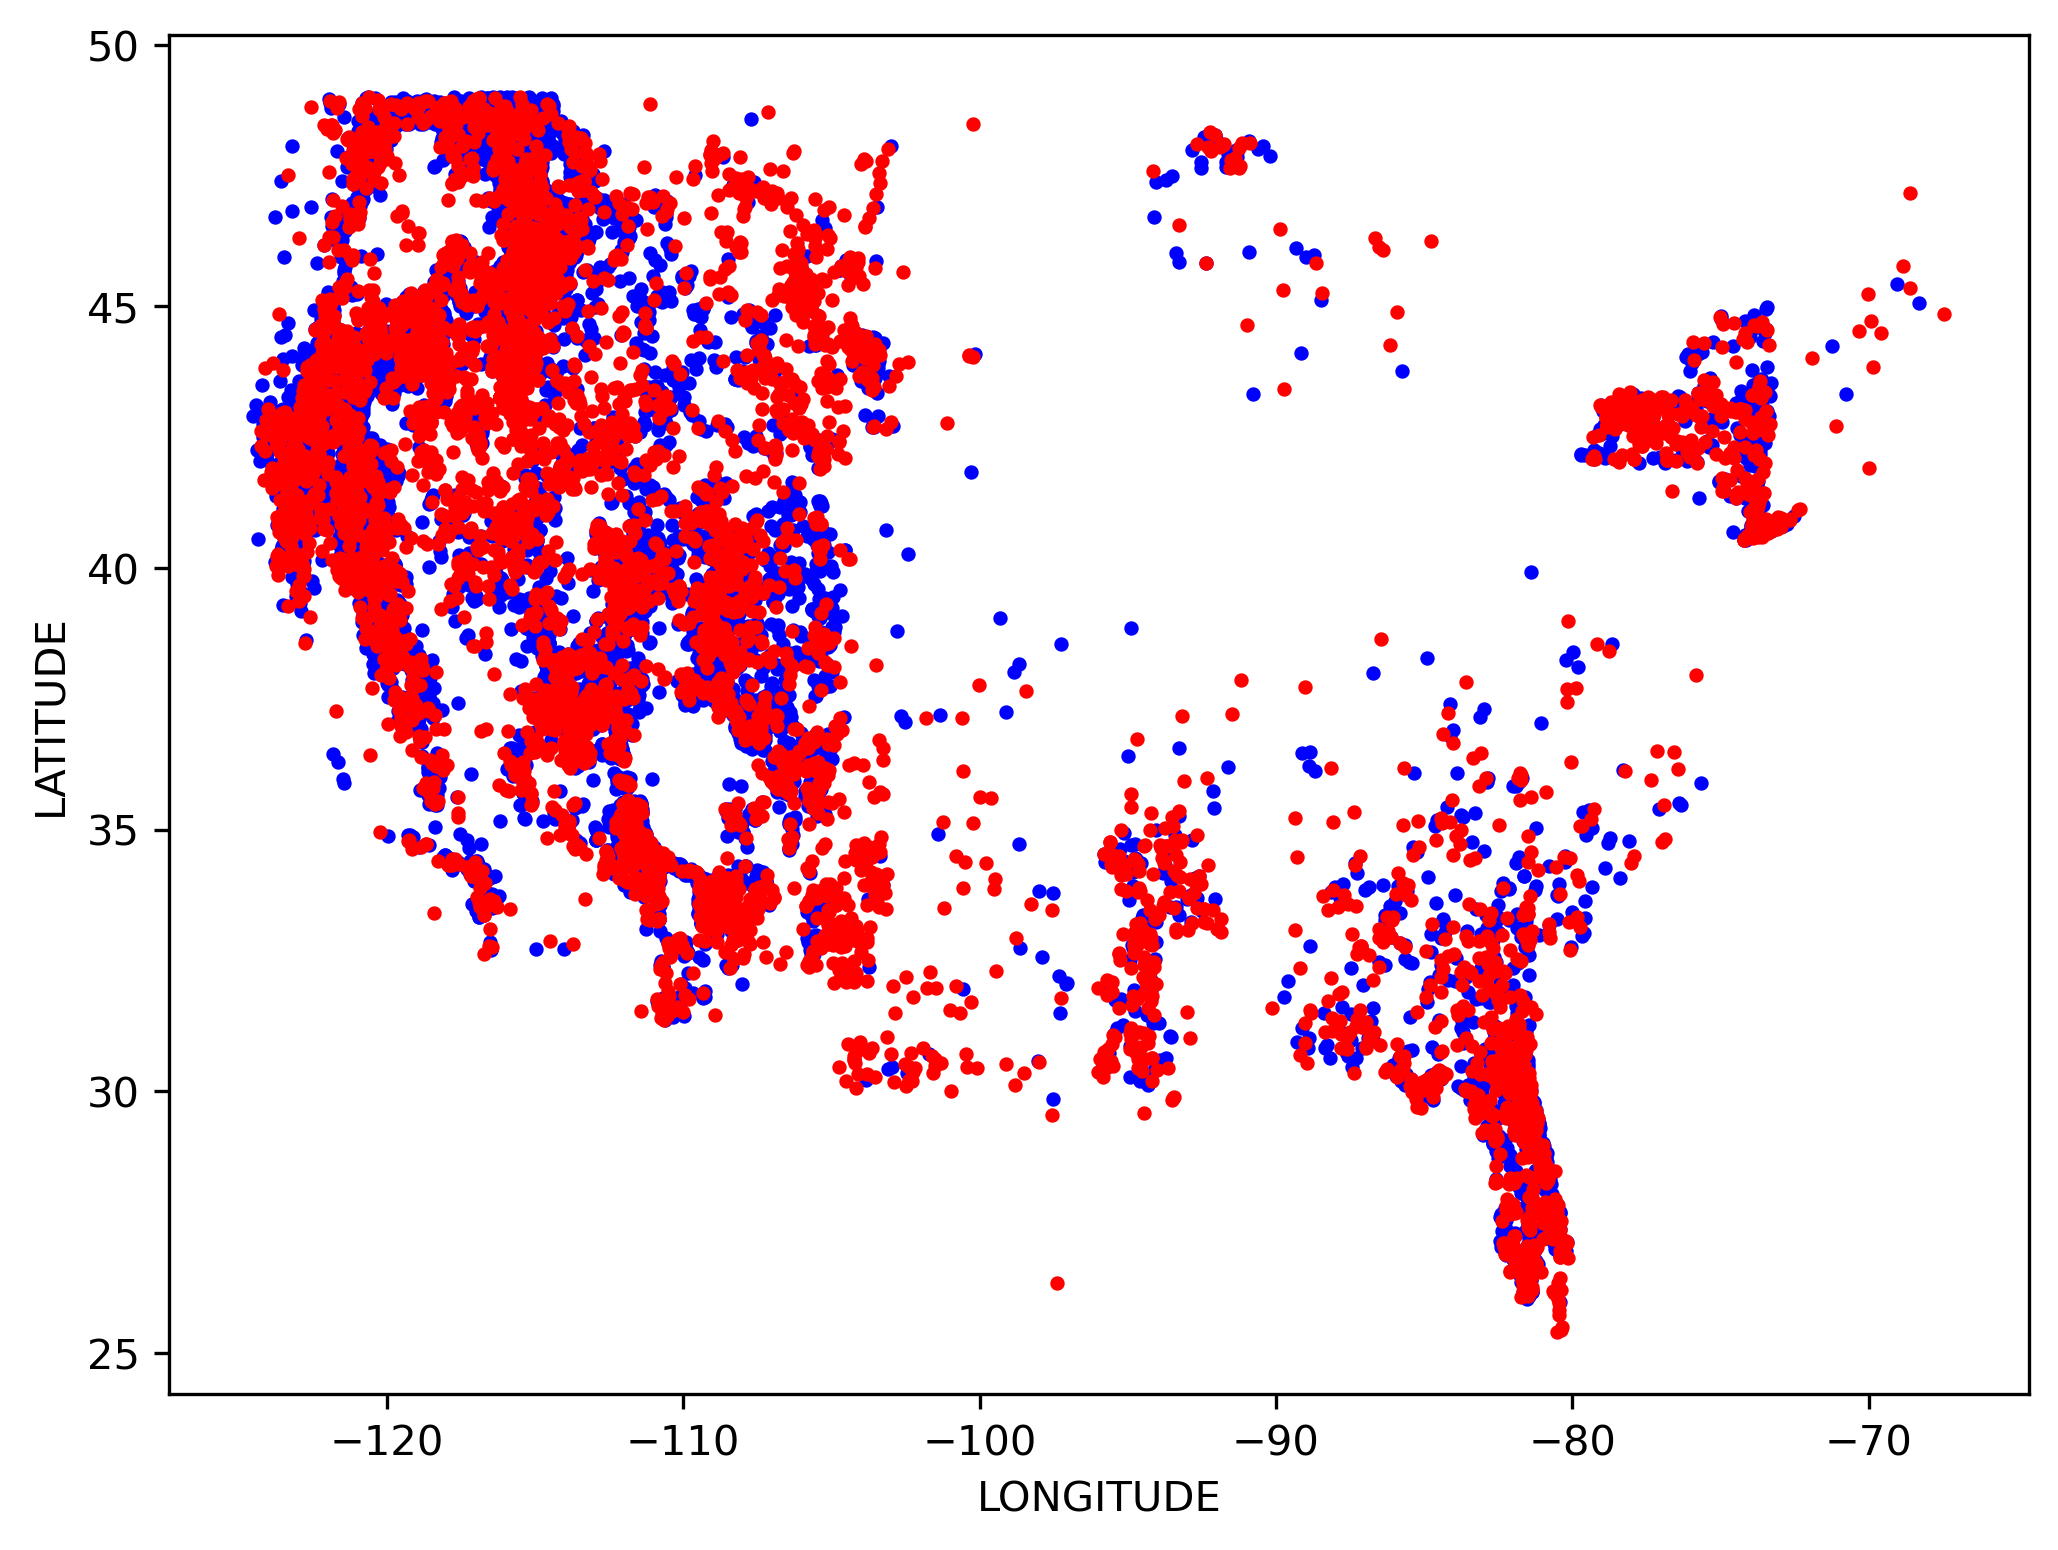

In [156]:
rrlda_class_acc_fig, rrlda_class_acc_ax = plot_classification_accuracy(y_rrlda, y_class_test, X_class_test)

for ext in save_formats:
    rrlda_class_acc_fig.savefig(figure_dir / f'rrlda_class_accuracy_hist.{ext}')

plt.show()

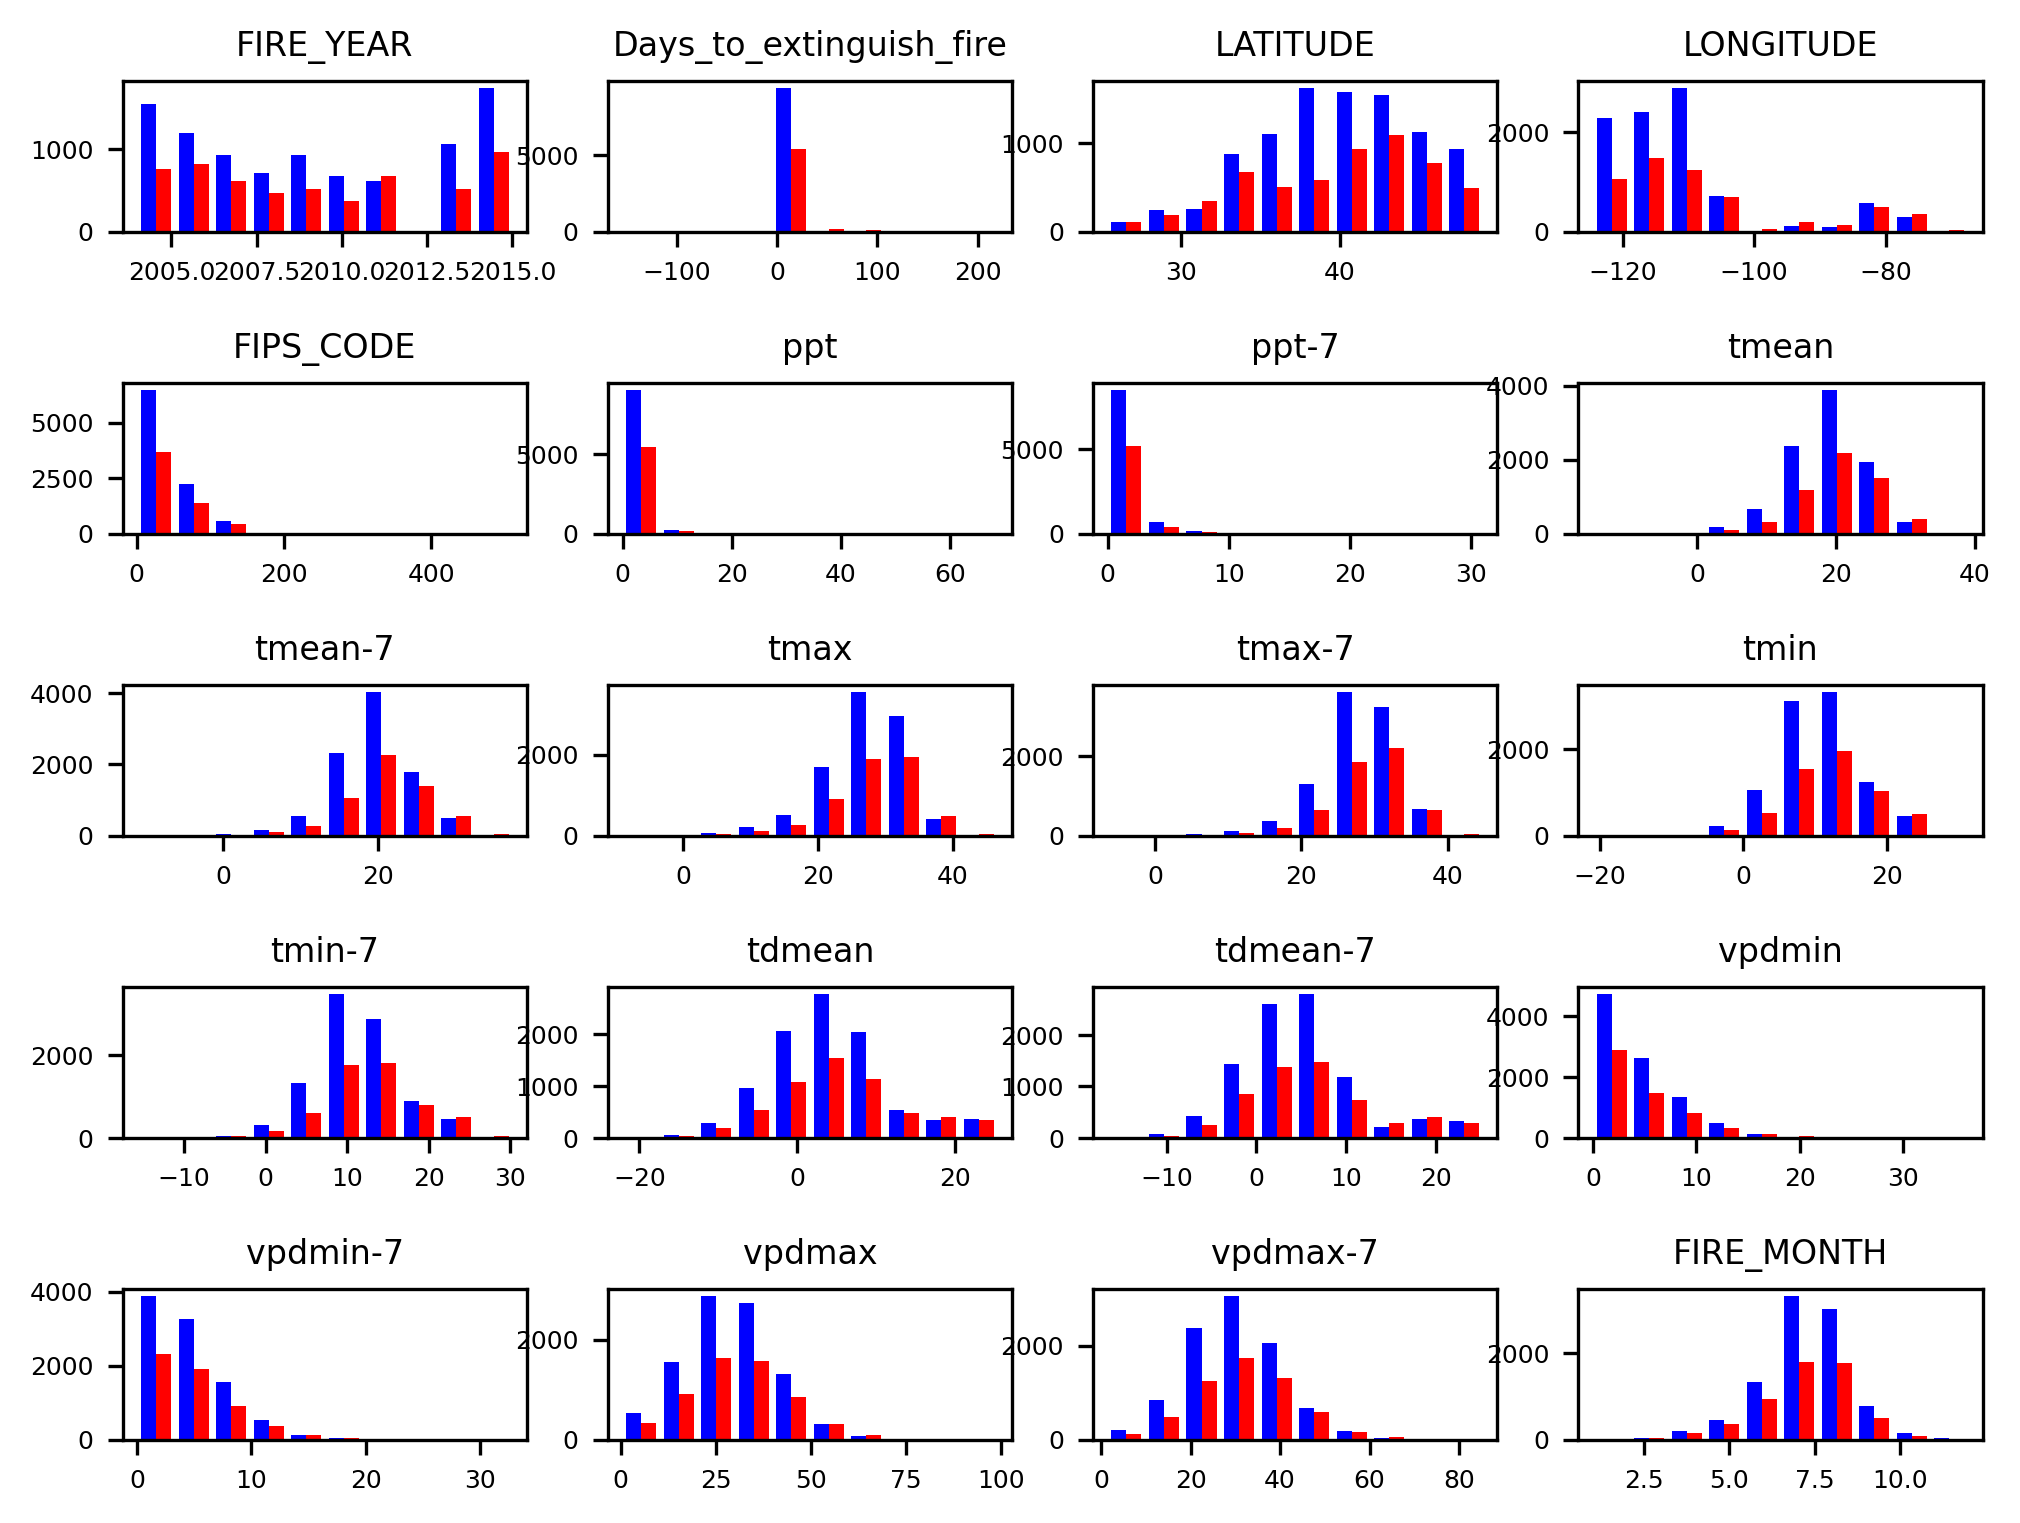

In [157]:
rrlda_var_hist_fig, rrlda_var_hist_ax = plot_variable_histograms(y_rrlda, y_class_test, X_class_test)

for ext in save_formats:
    rrlda_var_hist_fig.savefig(figure_dir / f'rrlda_var_hist.{ext}')

plt.show()

## QDA

Now try Quadratic Discriminant Analysis

In [179]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = make_pipeline(
    StandardScaler(),
    QuadraticDiscriminantAnalysis(),
)

qda.fit(X_class_train, y_class_train)
y_qda = qda.predict(X_class_test)
qda_accuracy = sum(y_qda==y_class_test)/len(y_qda)

df_class_results.loc['QDA','accuracy'] = qda_accuracy

display(qda_accuracy)

0.5927736310192219

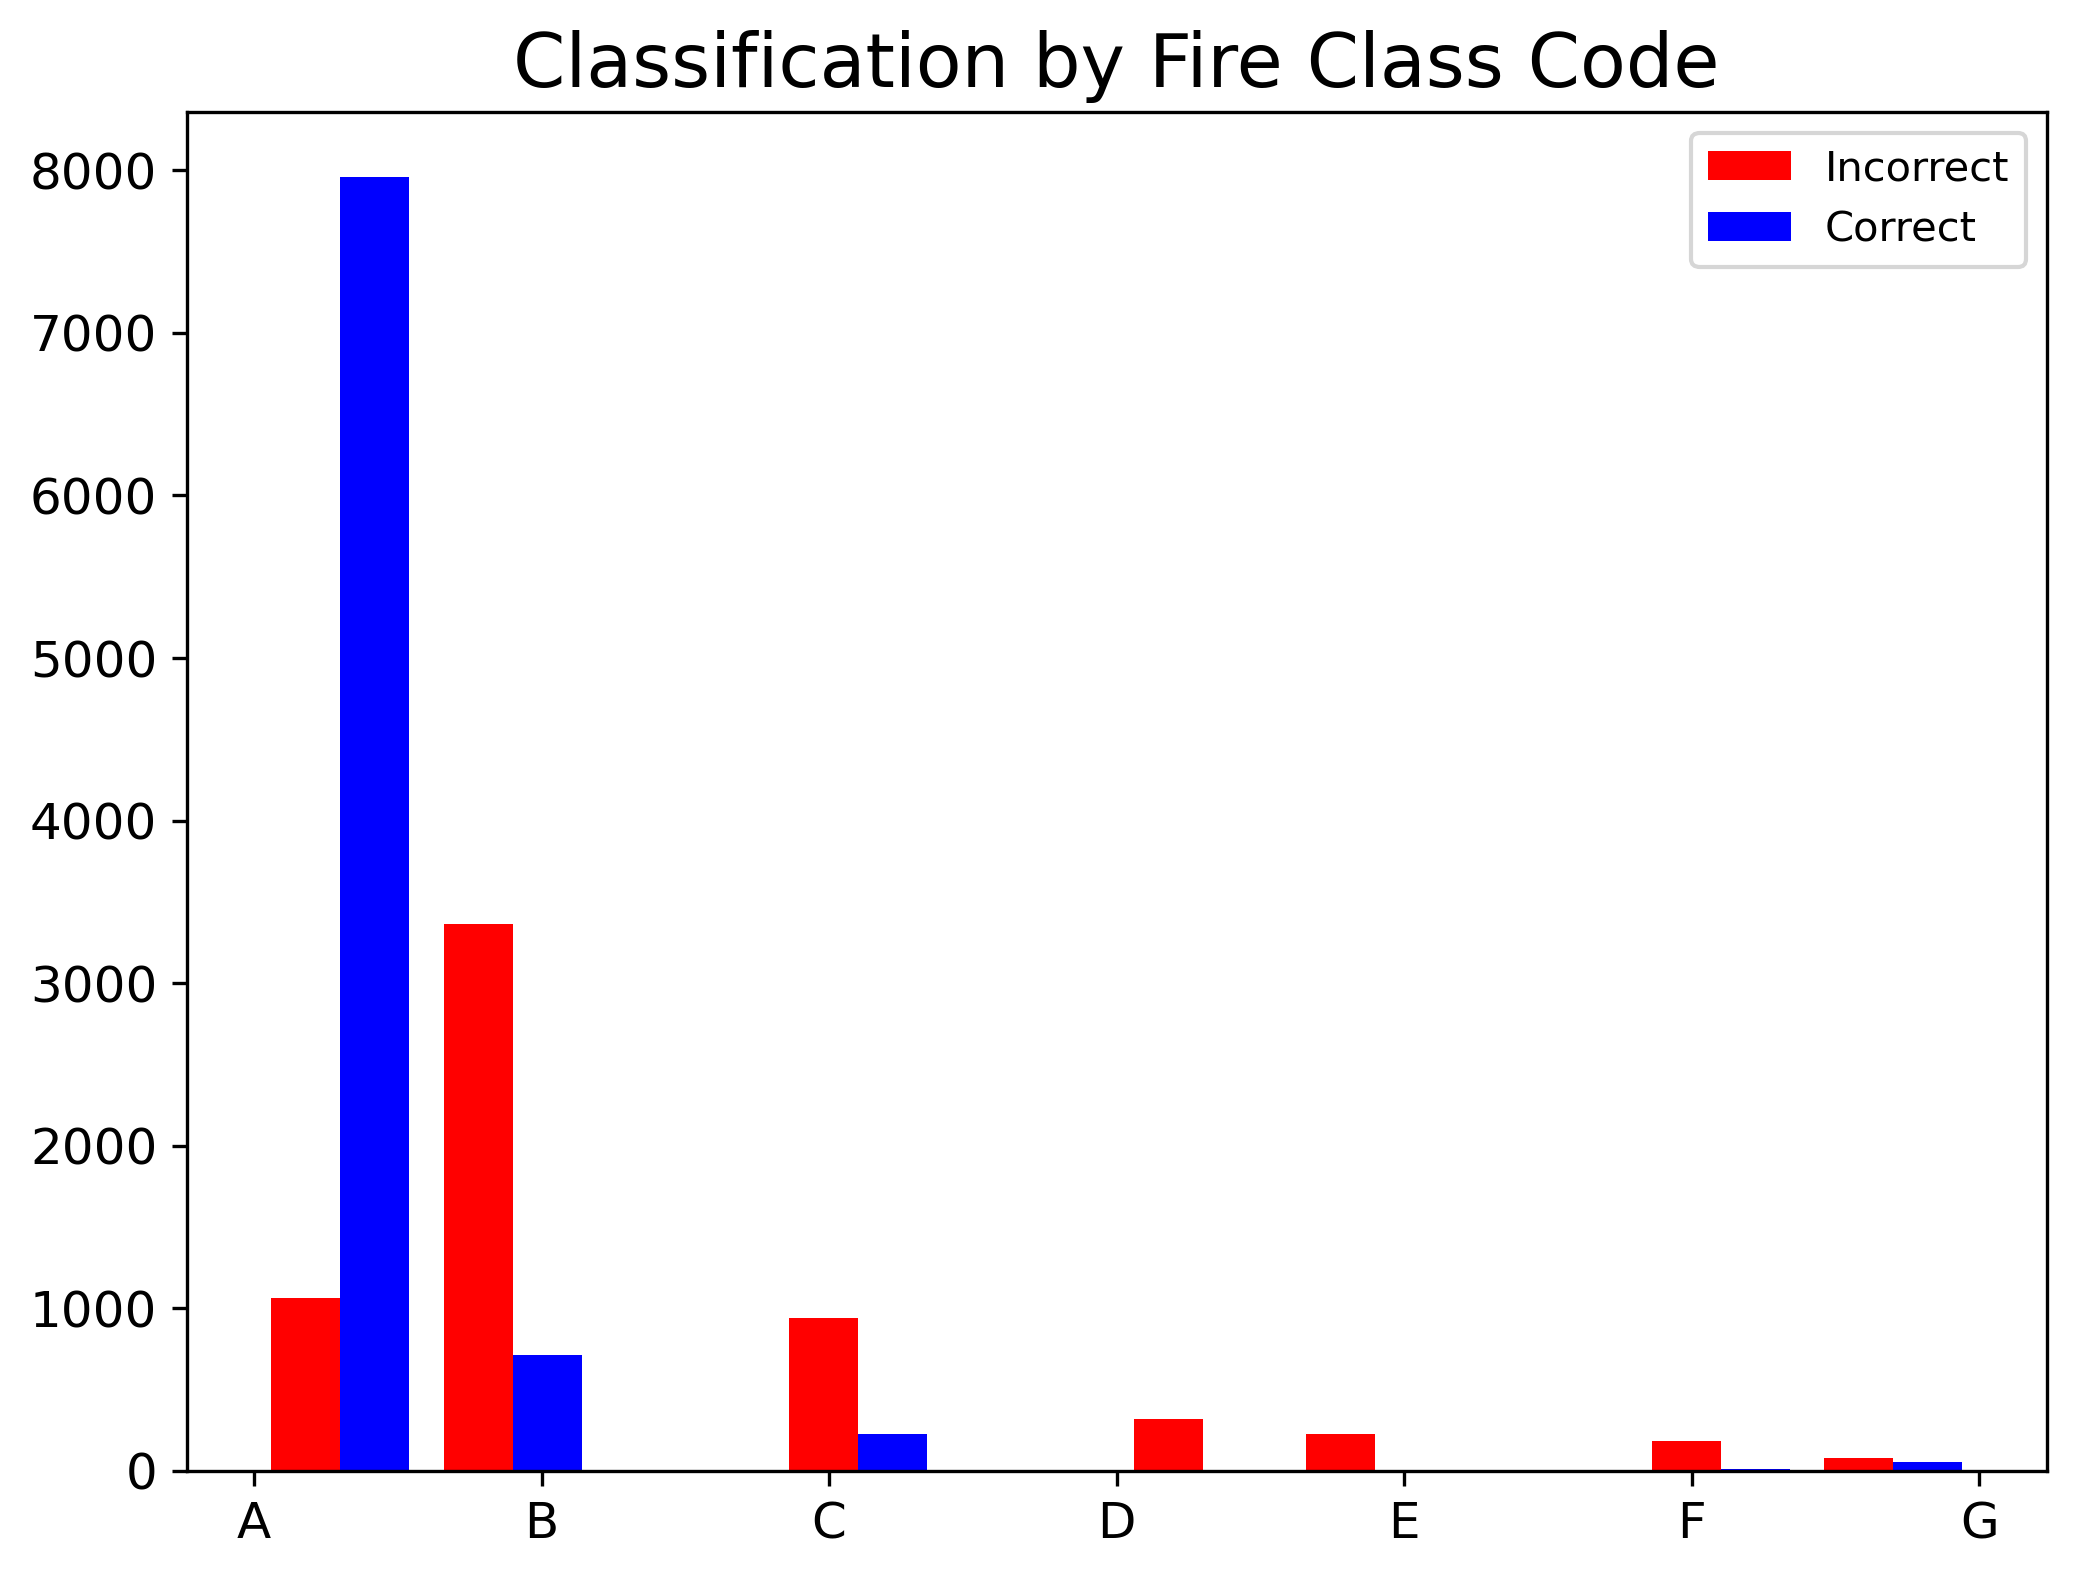

In [159]:
qda_fire_code_fig, qda_fire_code_ax = plot_fire_code_histograms(y_qda, y_class_test)

for ext in save_formats:
    qda_fire_code_fig.savefig(figure_dir / f'qda_fire_code_hist.{ext}')

plt.show()

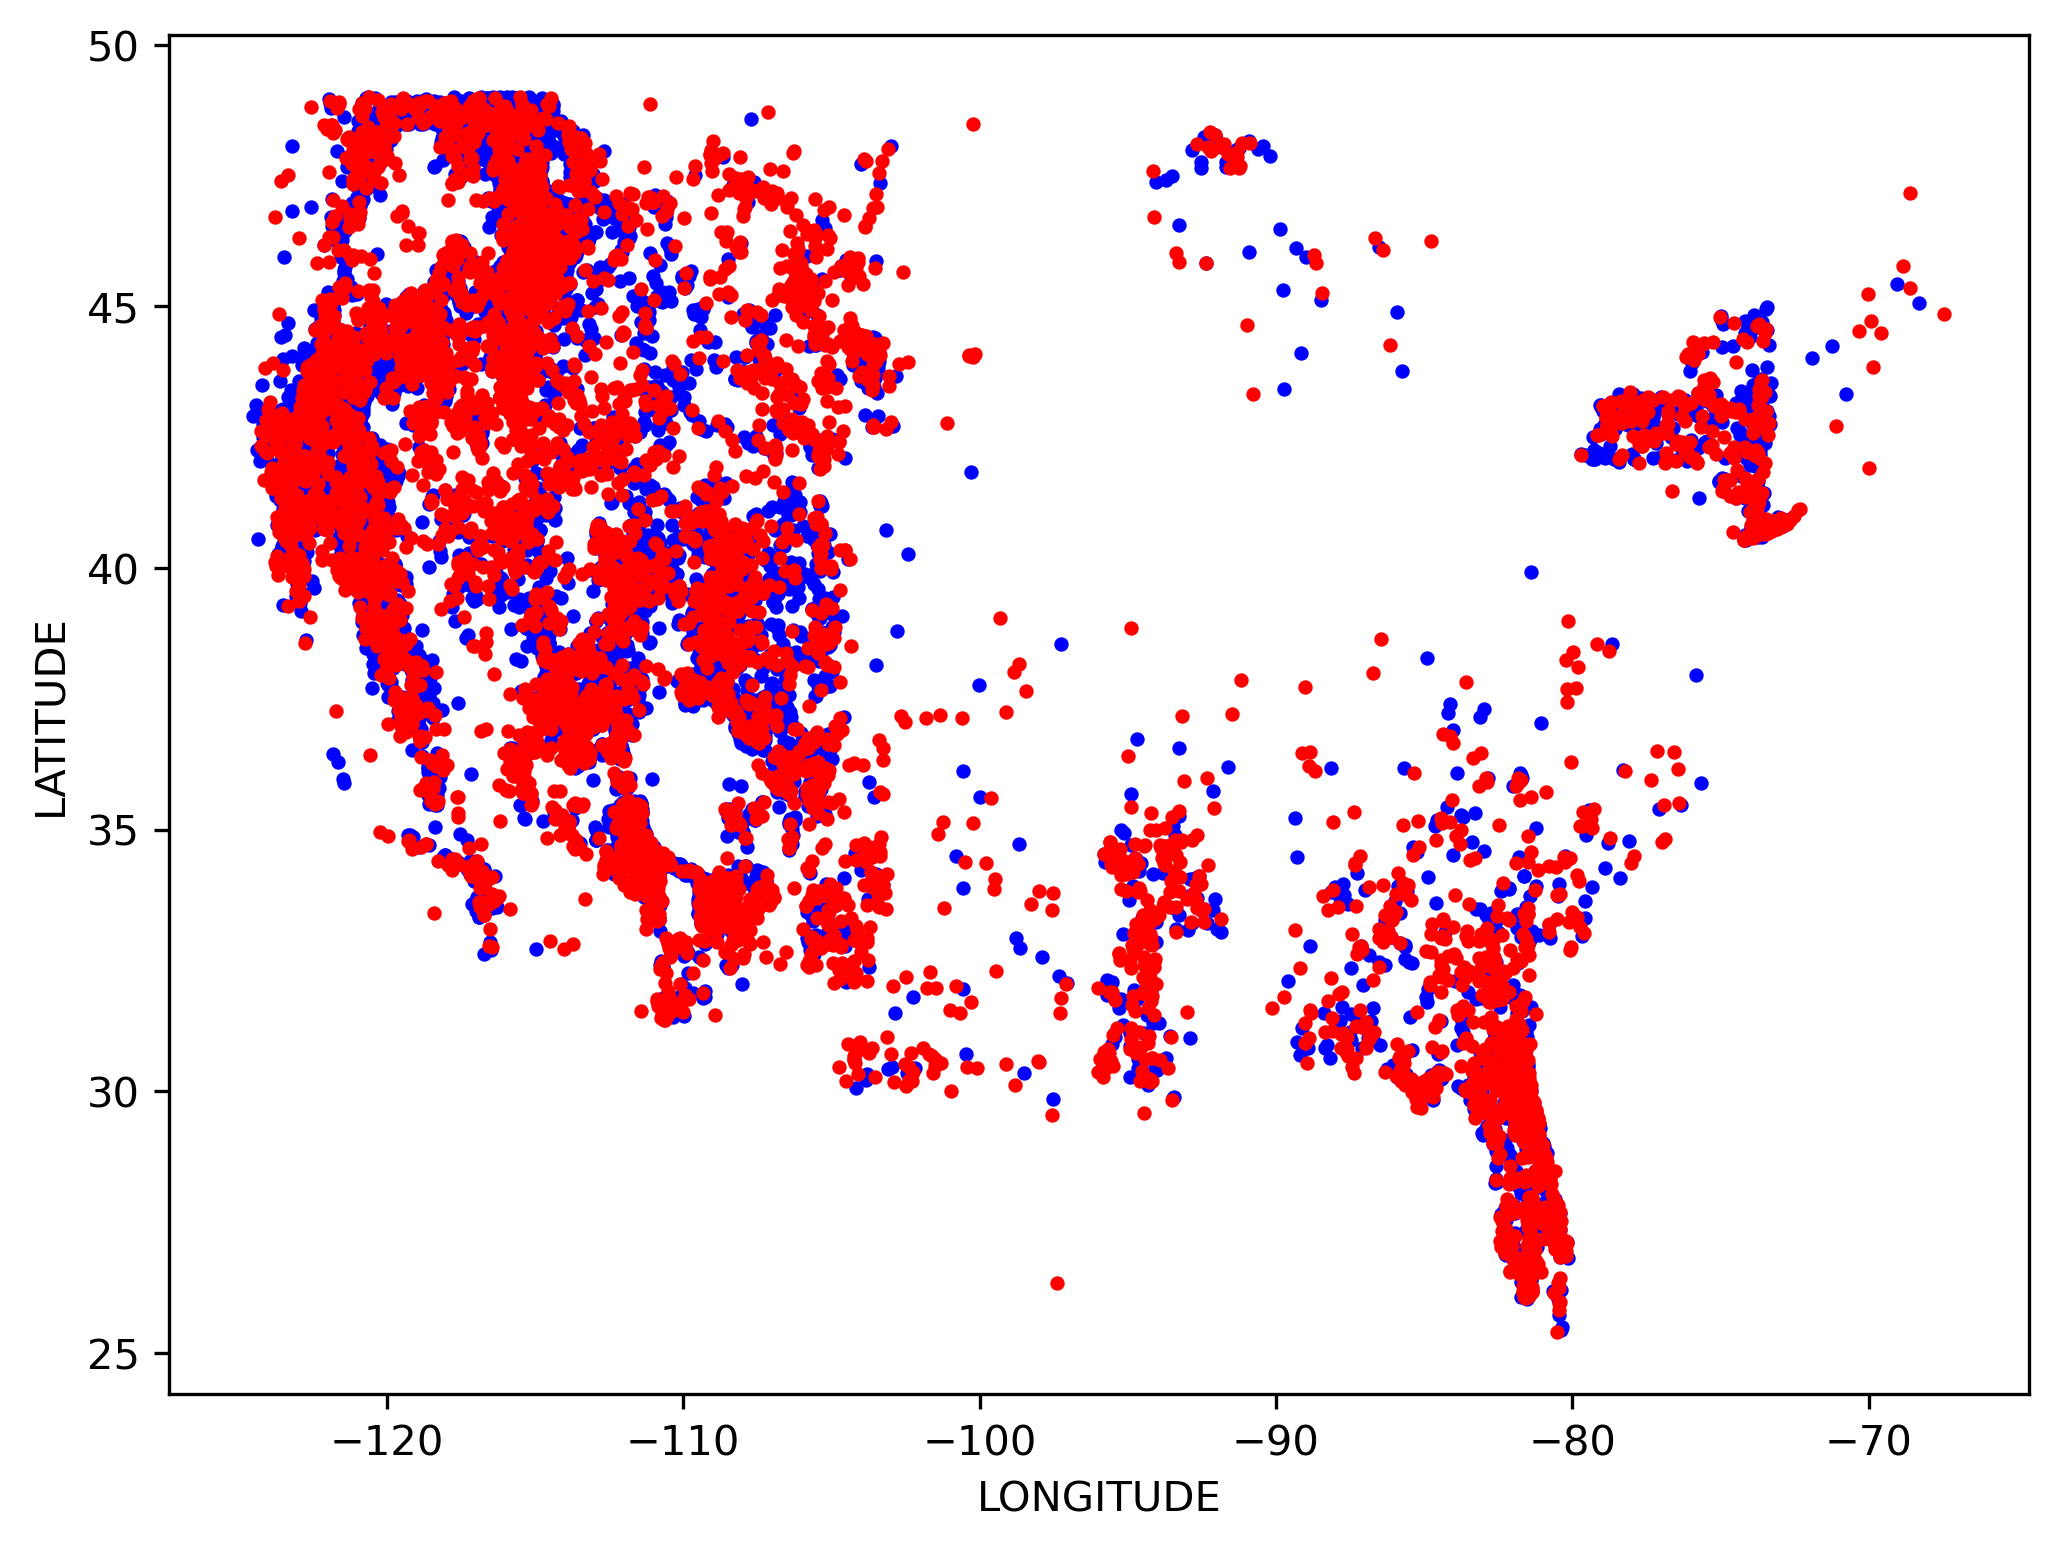

In [160]:
qda_class_acc_fig, qda_class_acc_ax = plot_classification_accuracy(y_qda, y_class_test, X_class_test)

for ext in save_formats:
    qda_class_acc_fig.savefig(figure_dir / f'qda_class_accuracy_hist.{ext}')

plt.show()

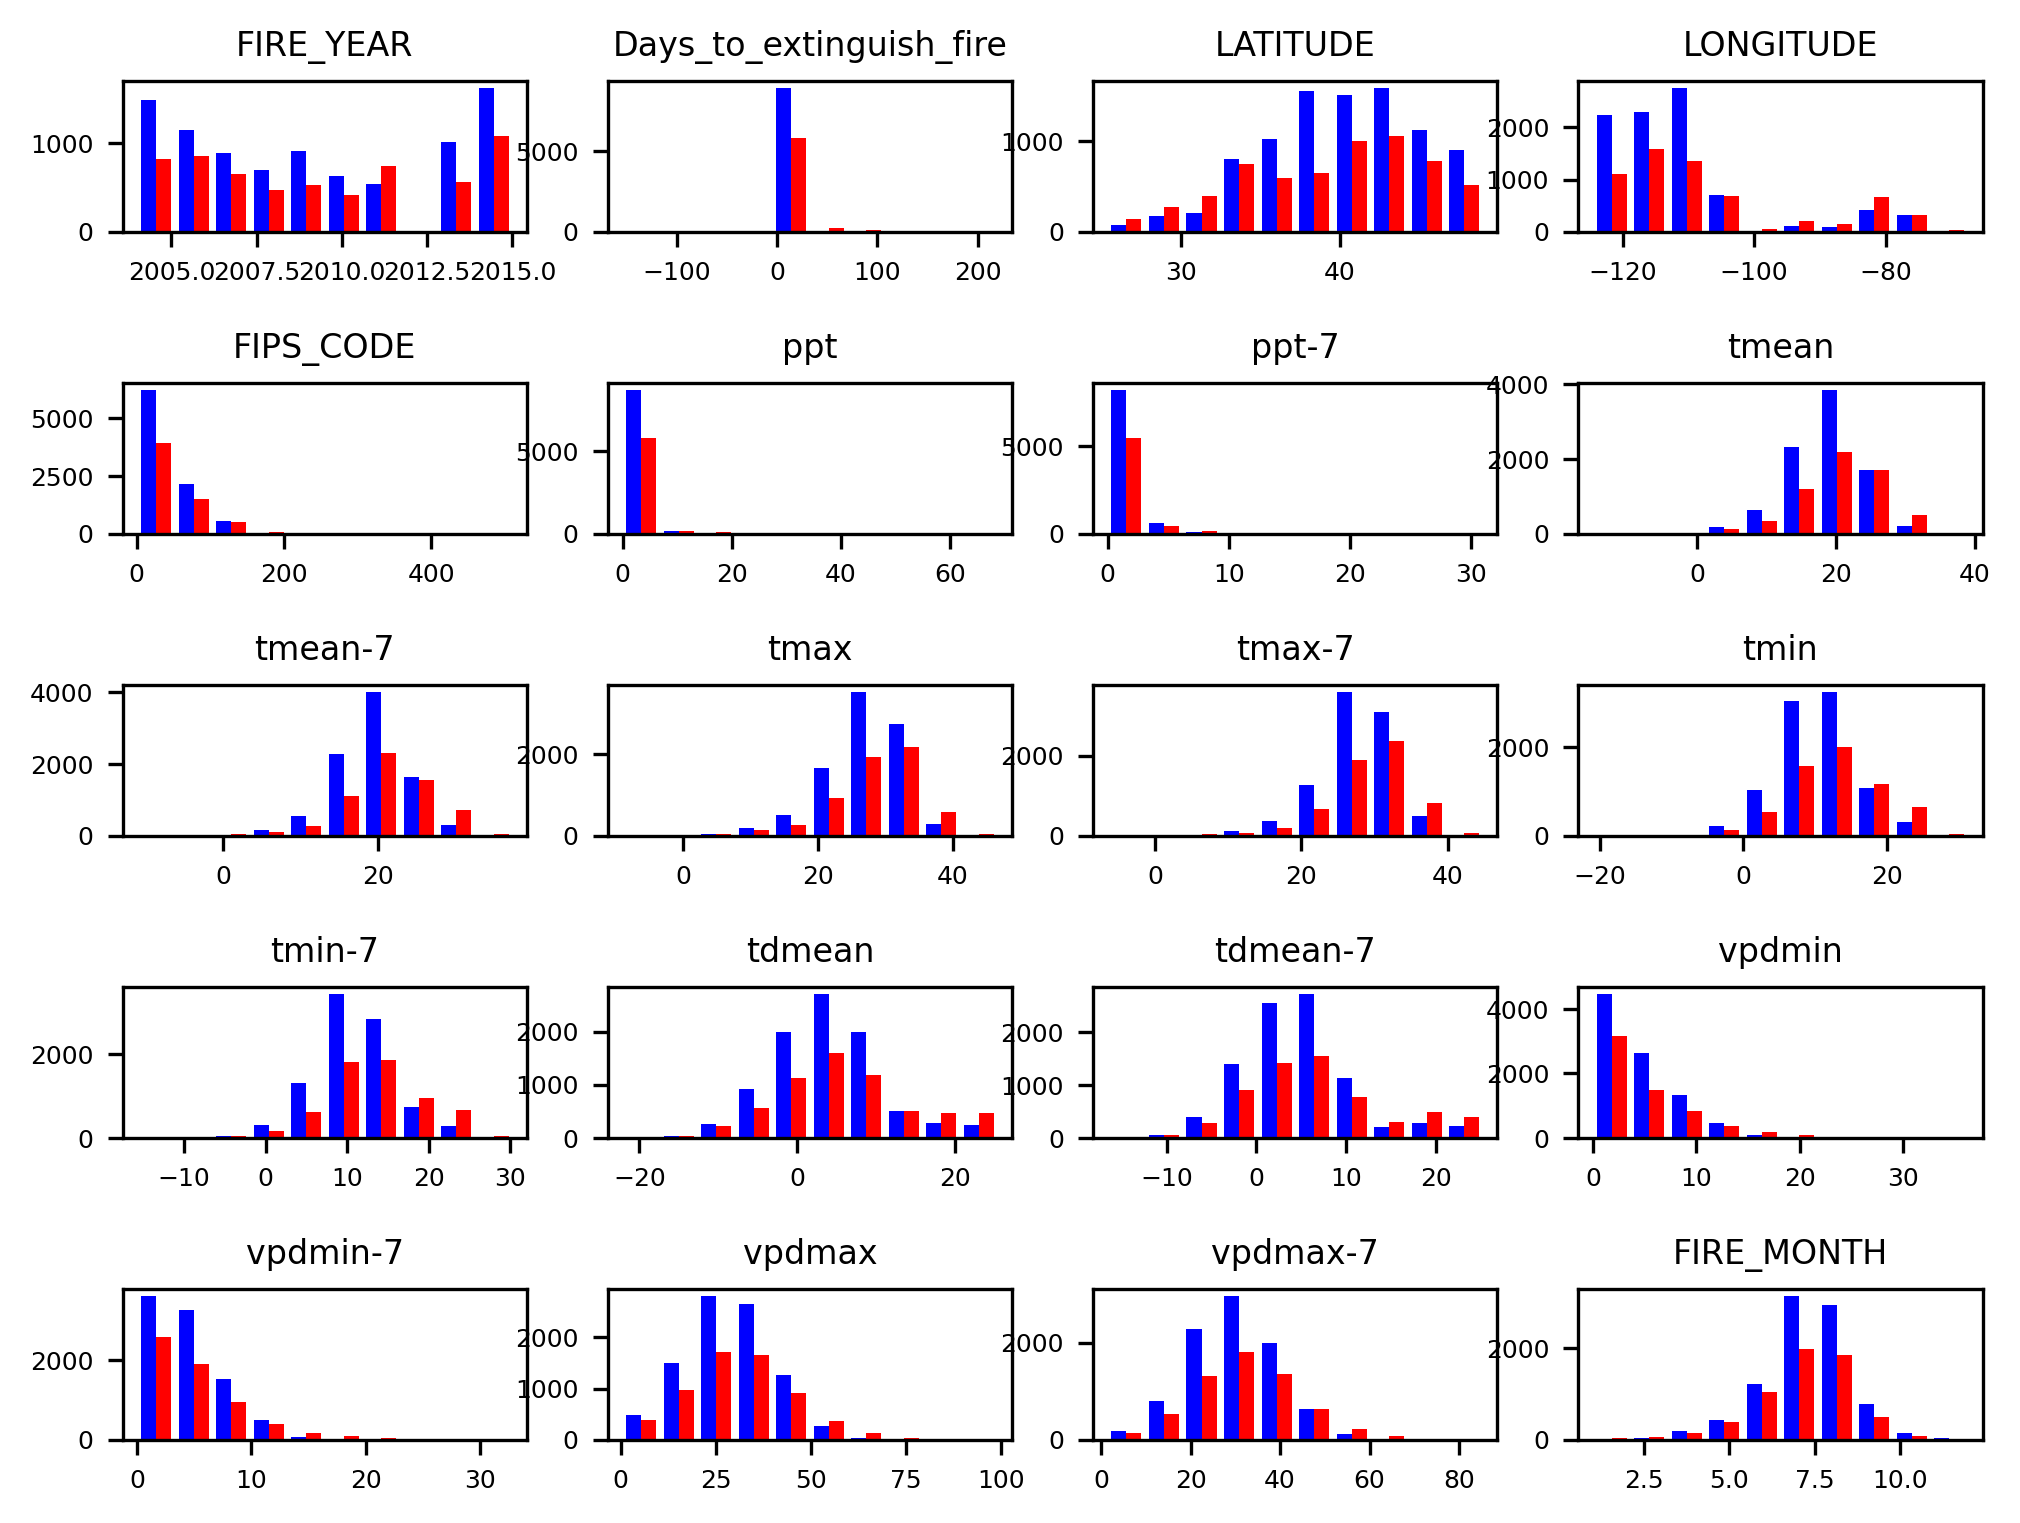

In [161]:
qda_var_hist_fig, qda_var_hist_ax = plot_variable_histograms(y_qda, y_class_test, X_class_test)

for ext in save_formats:
    qda_var_hist_fig.savefig(figure_dir / f'qda_var_hist.{ext}')

plt.show()

## Logistic Regression

In [180]:
from sklearn.linear_model import LogisticRegression

log_reg = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=1000,
        tol=1E-6,
        multi_class='multinomial',
    ),
)

log_reg.fit(X_class_train, y_class_train)
y_log_reg = log_reg.predict(X_class_test)
log_reg_accuracy = sum(y_log_reg==y_class_test)/len(y_log_reg)

df_class_results.loc['Logistic','accuracy'] = log_reg_accuracy

display(log_reg_accuracy)

0.626593566285752

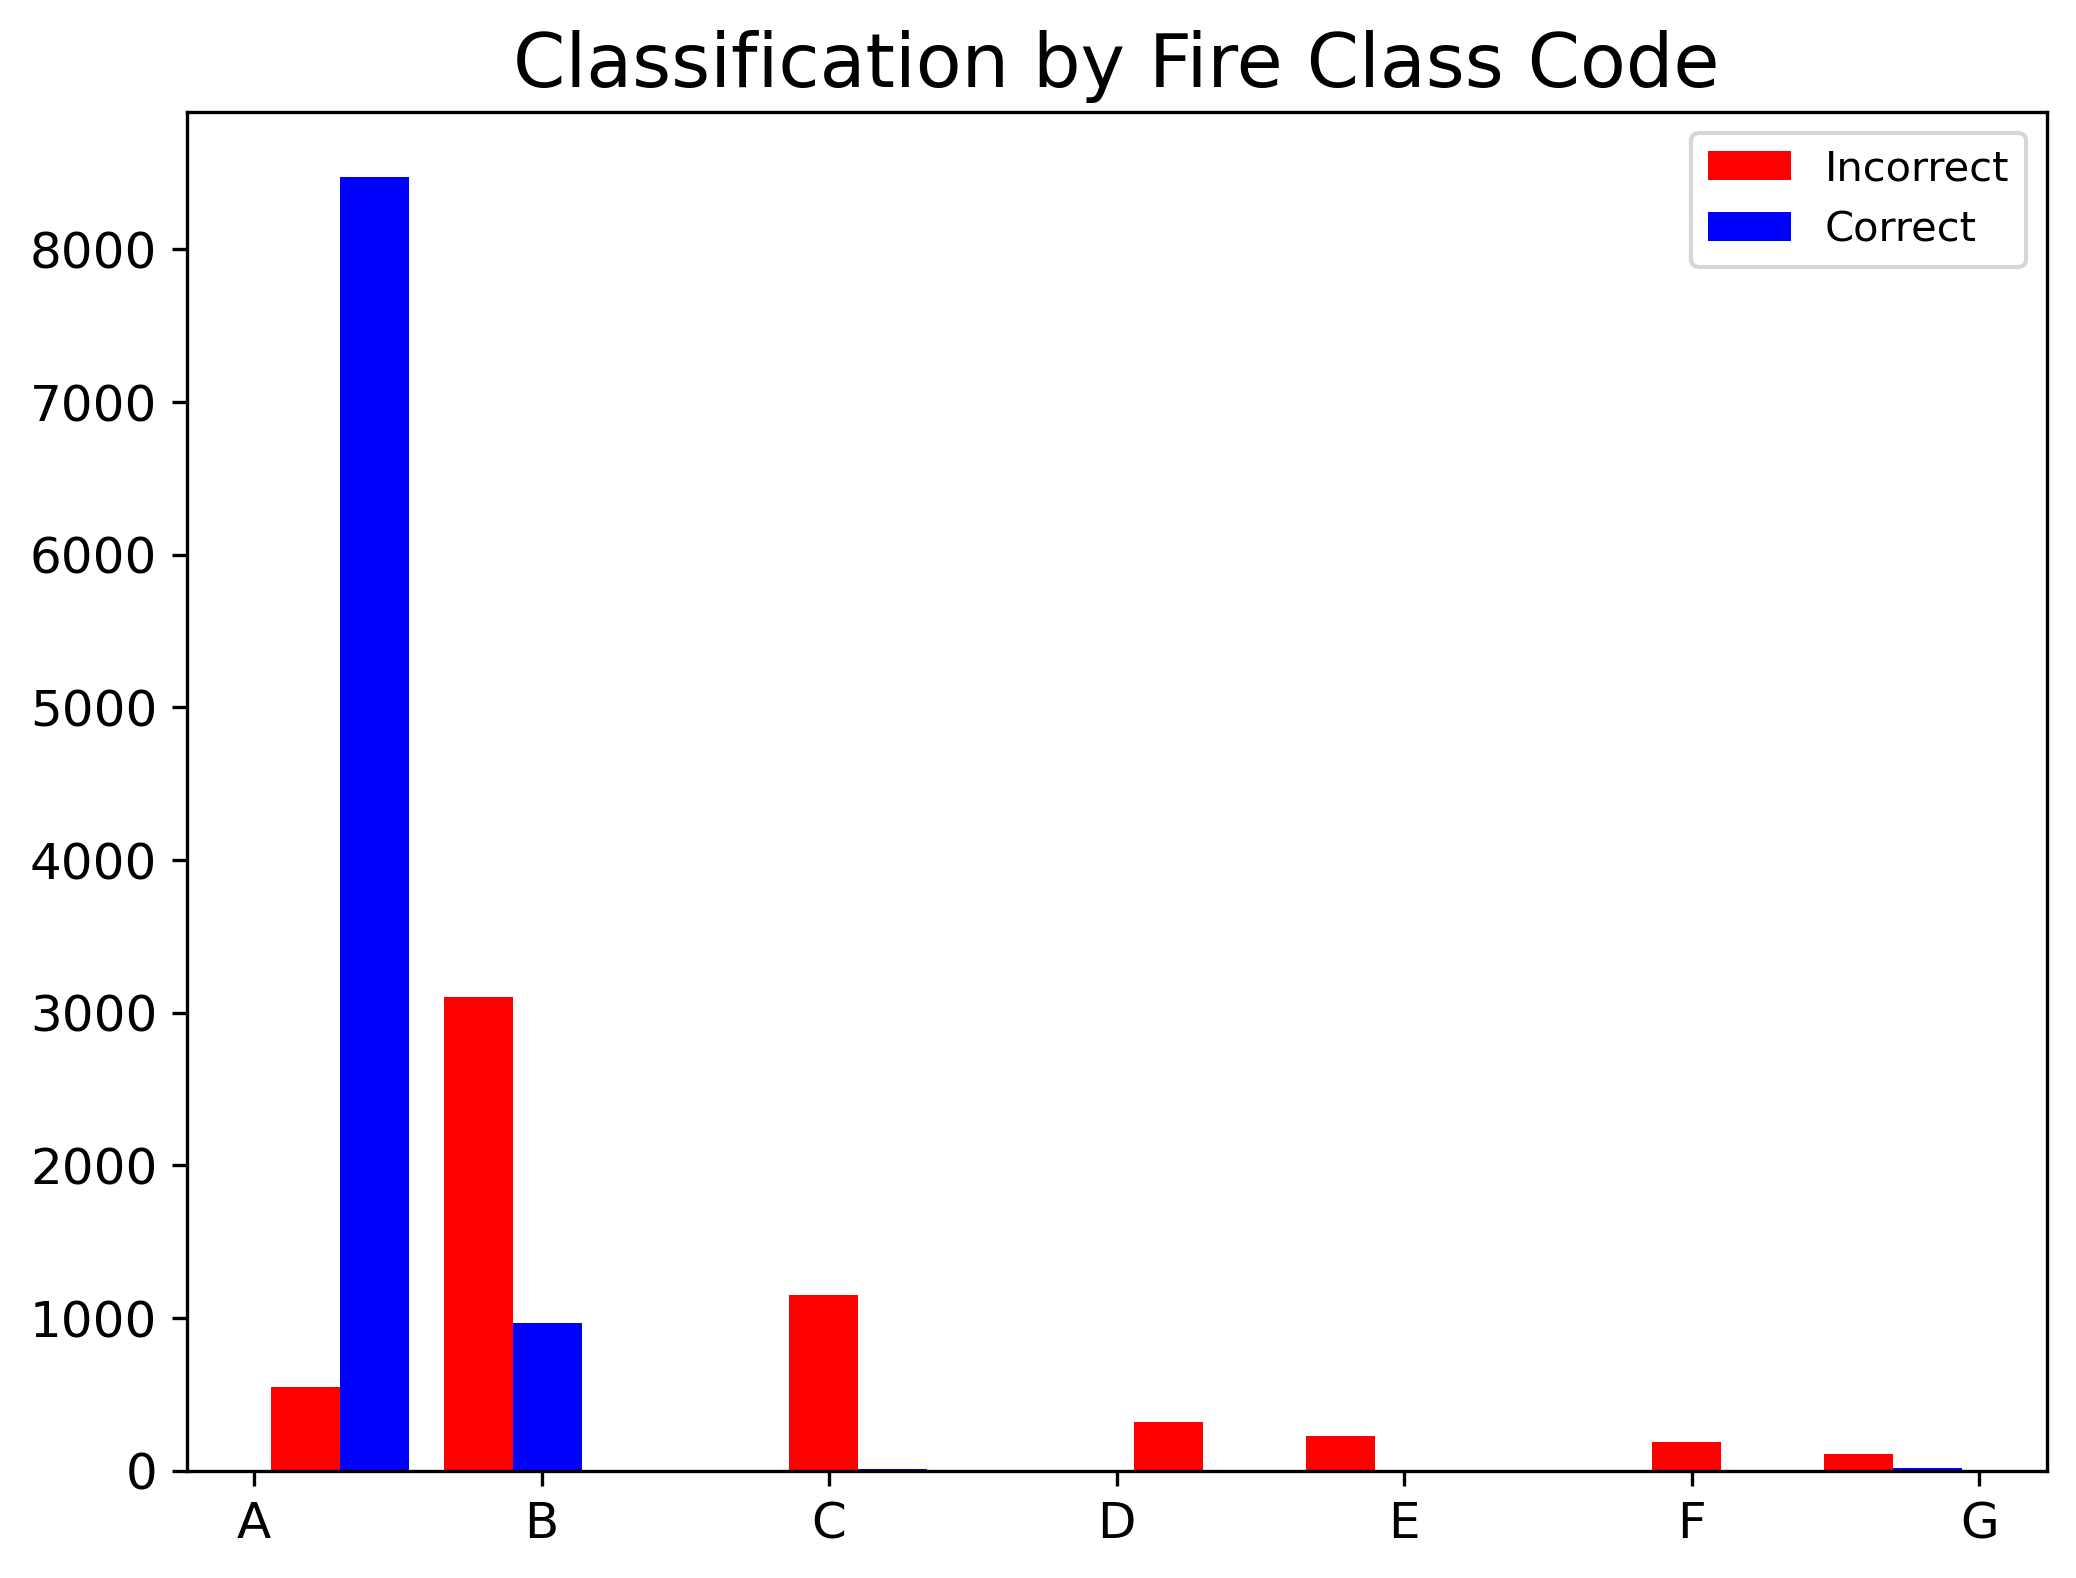

In [163]:
log_reg_fire_code_fig, log_reg_fire_code_ax = plot_fire_code_histograms(y_log_reg, y_class_test)

for ext in save_formats:
    log_reg_fire_code_fig.savefig(figure_dir / f'log_reg_fire_code_hist.{ext}')

plt.show()

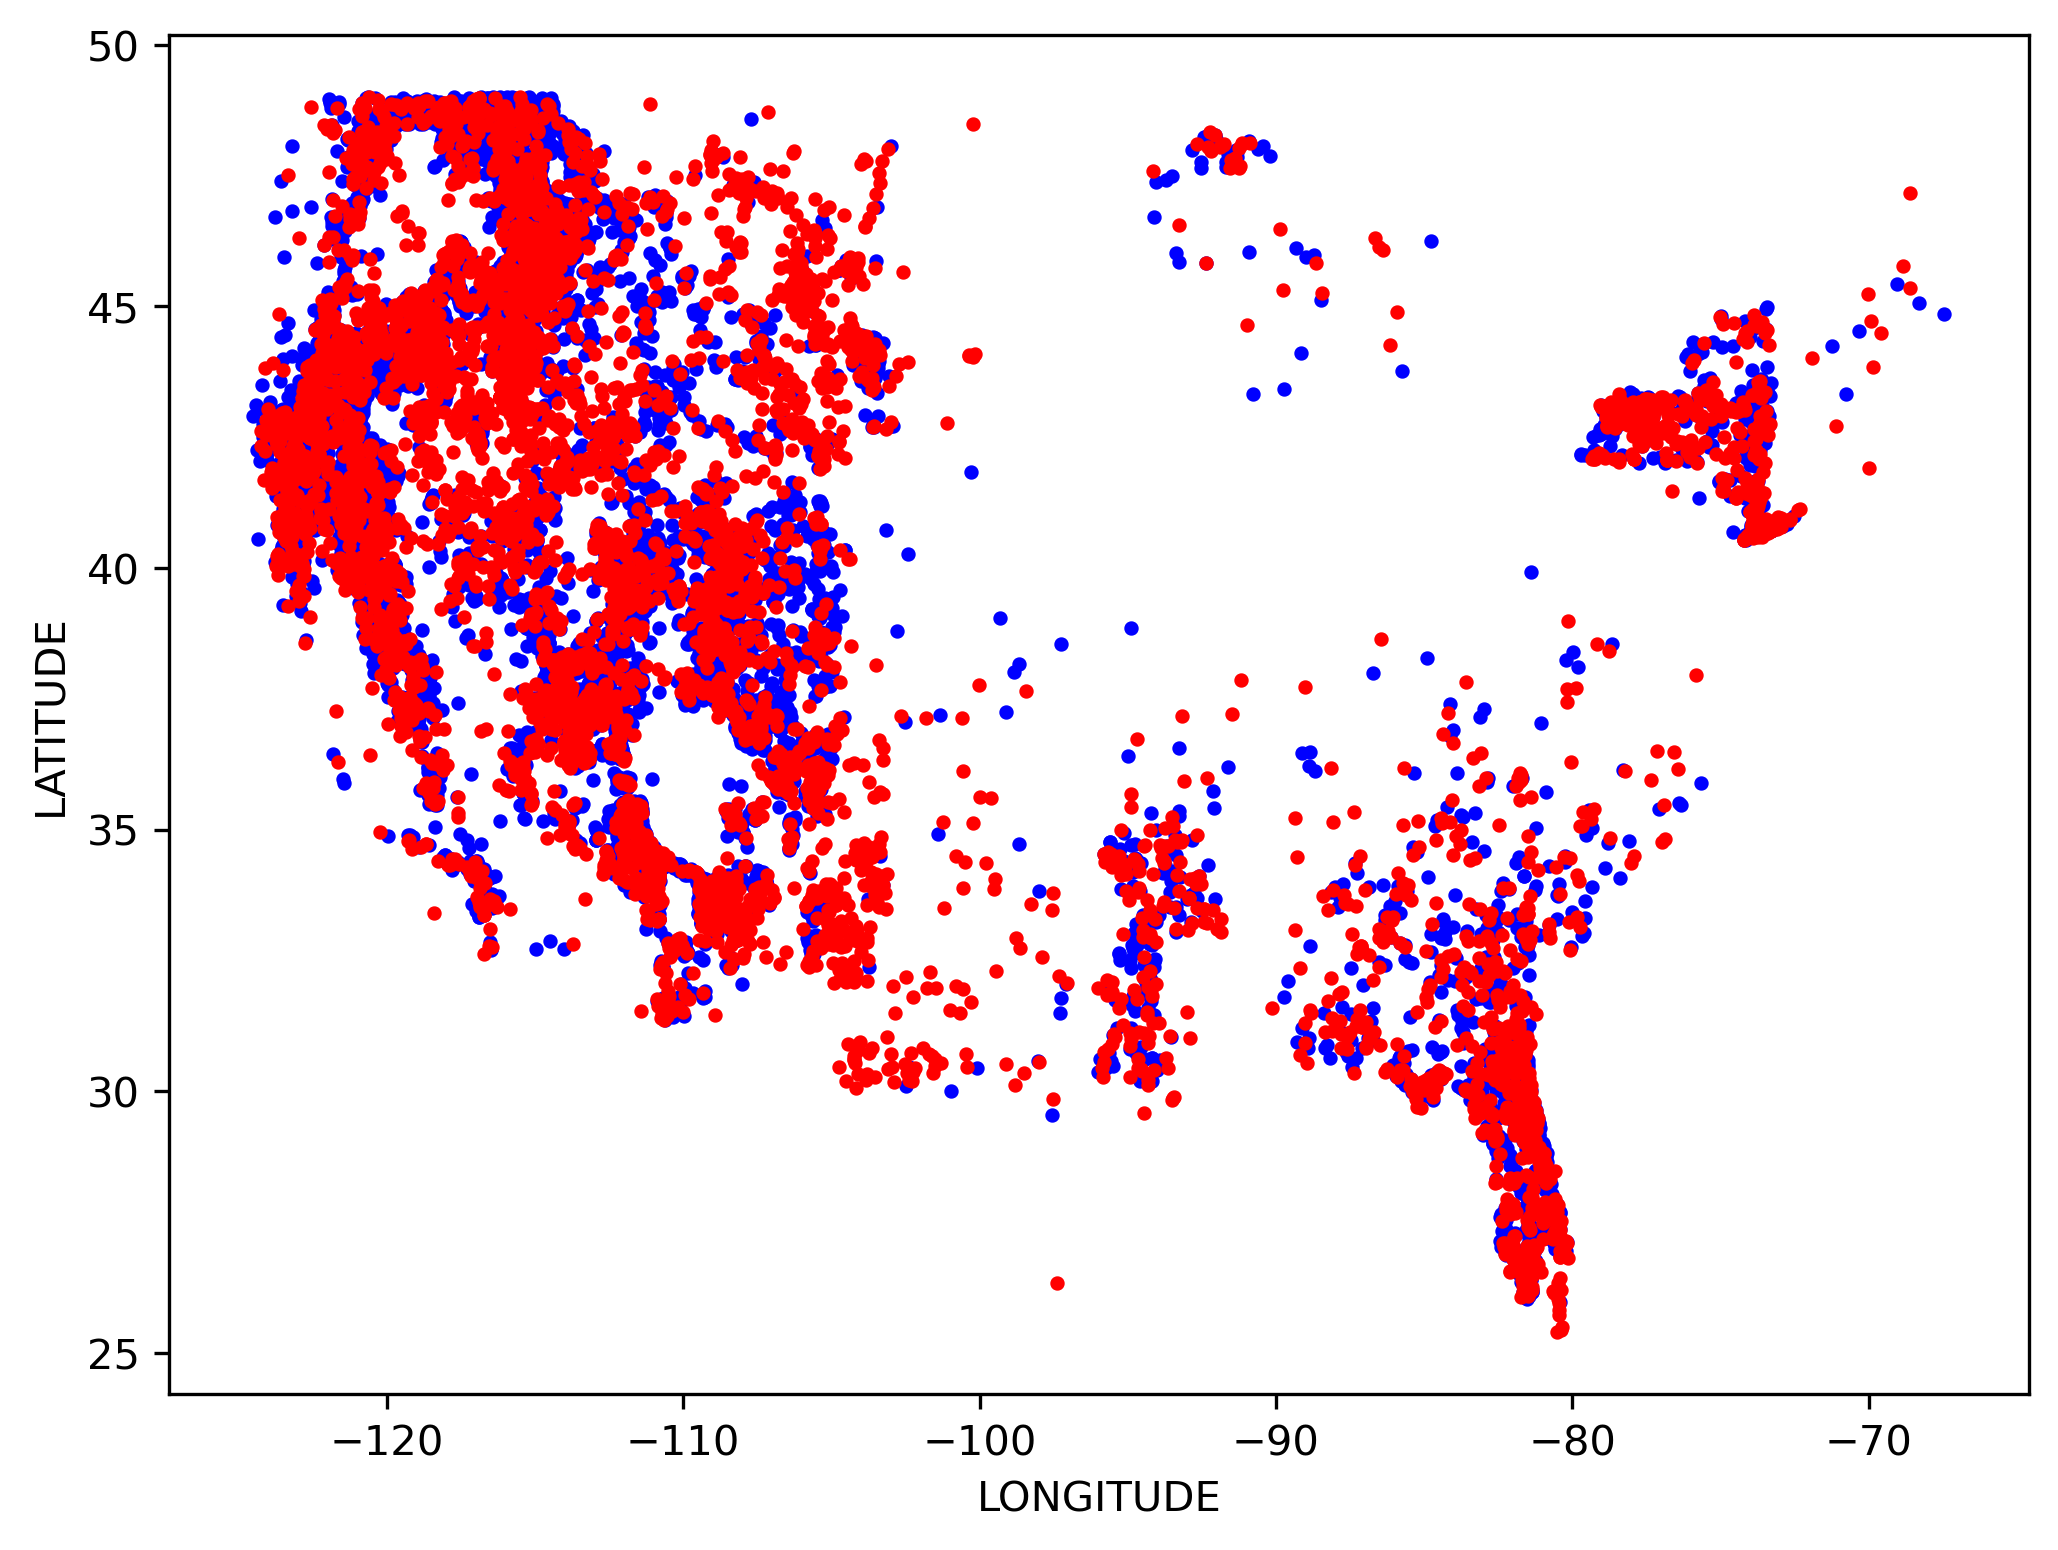

In [164]:
log_reg_class_acc_fig, log_reg_class_acc_ax = plot_classification_accuracy(y_log_reg, y_class_test, X_class_test)

for ext in save_formats:
    log_reg_class_acc_fig.savefig(figure_dir / f'log_reg_class_accuracy_hist.{ext}')

plt.show()

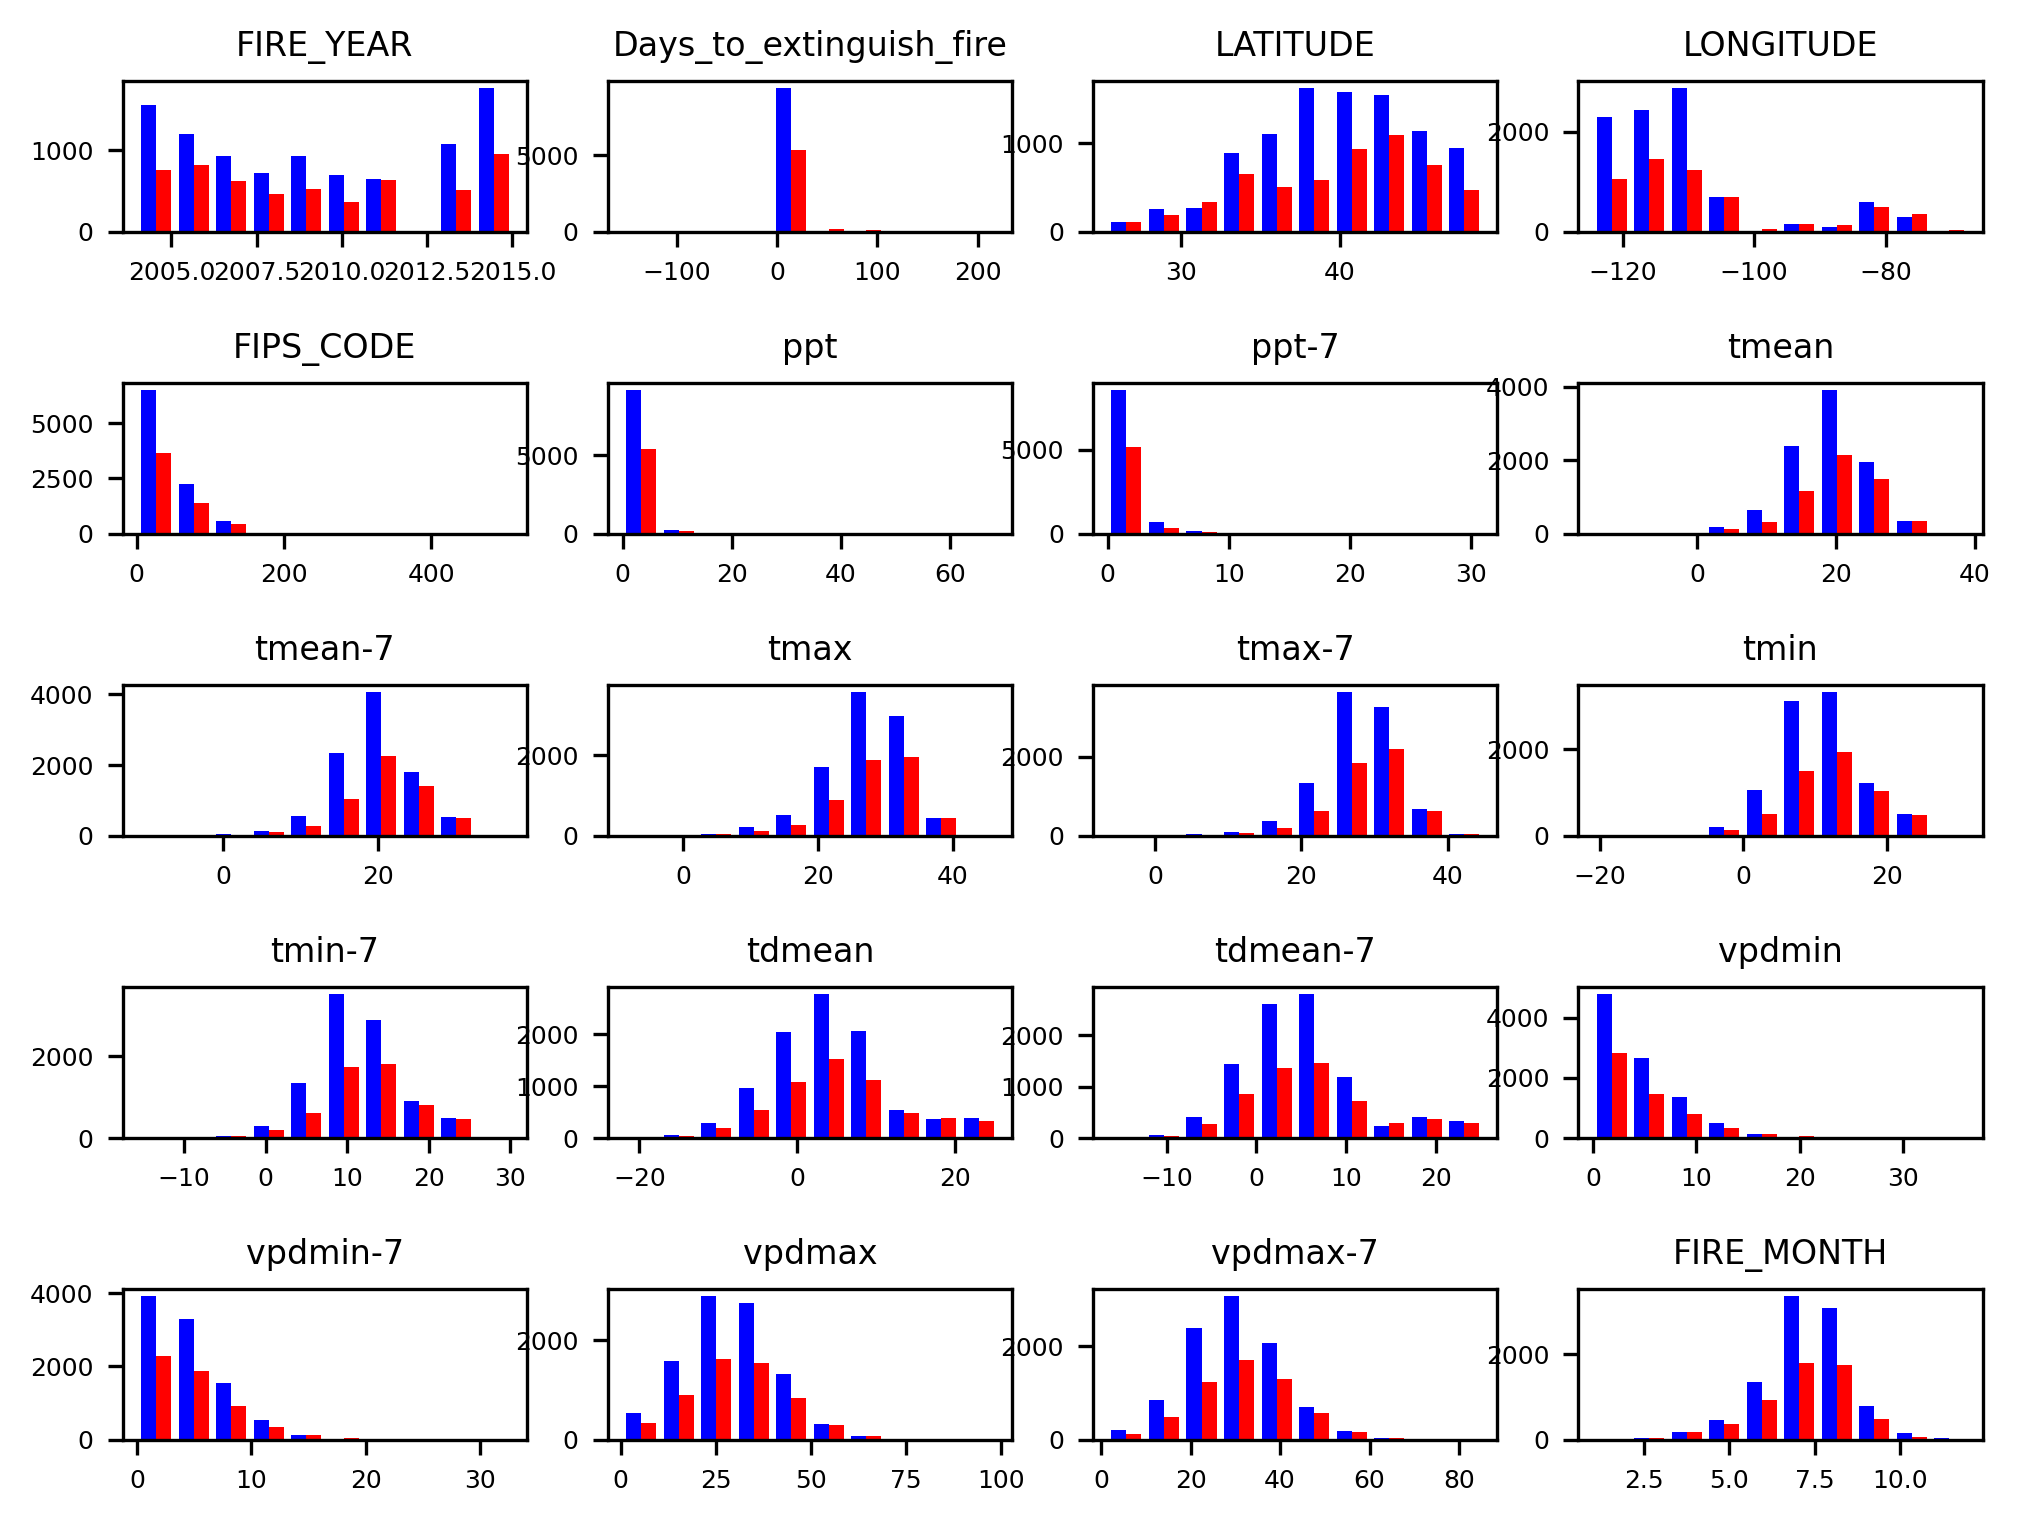

In [165]:
log_reg_var_hist_fig, log_reg_var_hist_ax = plot_variable_histograms(y_log_reg, y_class_test, X_class_test)

for ext in save_formats:
    log_reg_var_hist_fig.savefig(figure_dir / f'log_reg_var_hist.{ext}')

plt.show()

## K Nearest Neighbors

In [181]:
from sklearn.neighbors import KNeighborsClassifier

knn = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=15),
)

knn.fit(X_class_train, y_class_train)
y_knn = knn.predict(X_class_test)
knn_accuracy = sum(y_knn==y_class_test)/len(y_knn)

df_class_results.loc['KNN','accuracy'] = knn_accuracy

display(knn_accuracy)

0.6429090428694101

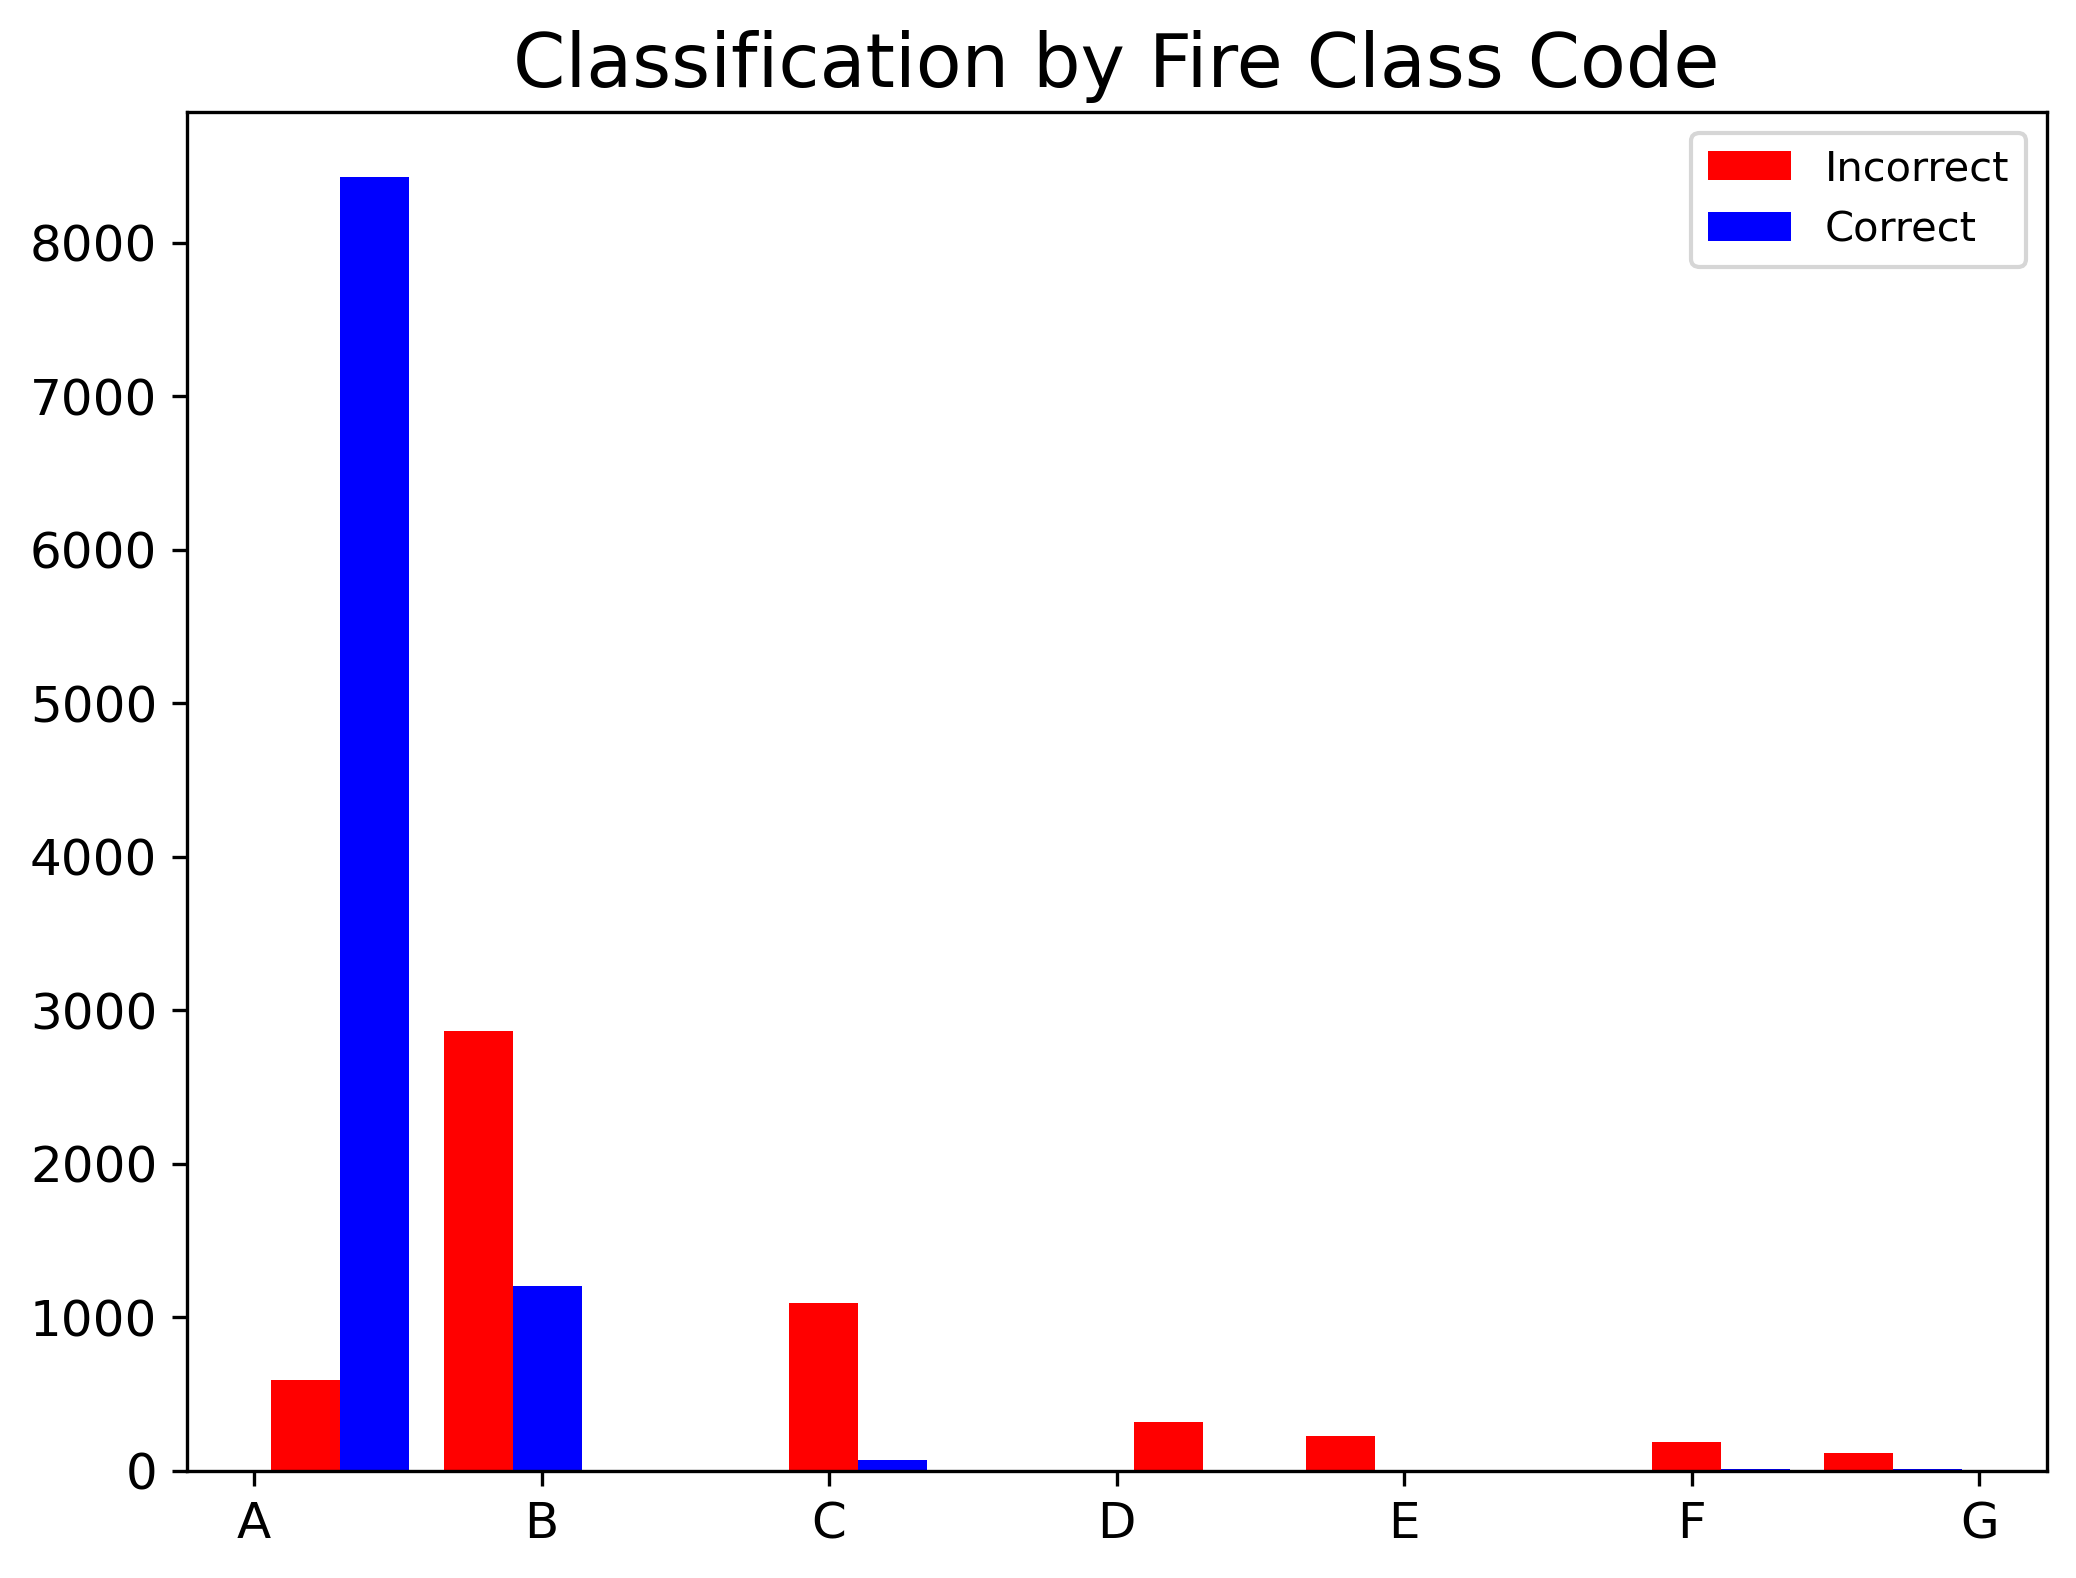

In [167]:
knn_fire_code_fig, knn_fire_code_ax = plot_fire_code_histograms(y_knn, y_class_test)

for ext in save_formats:
    knn_fire_code_fig.savefig(figure_dir / f'knn_fire_code_hist.{ext}')

plt.show()

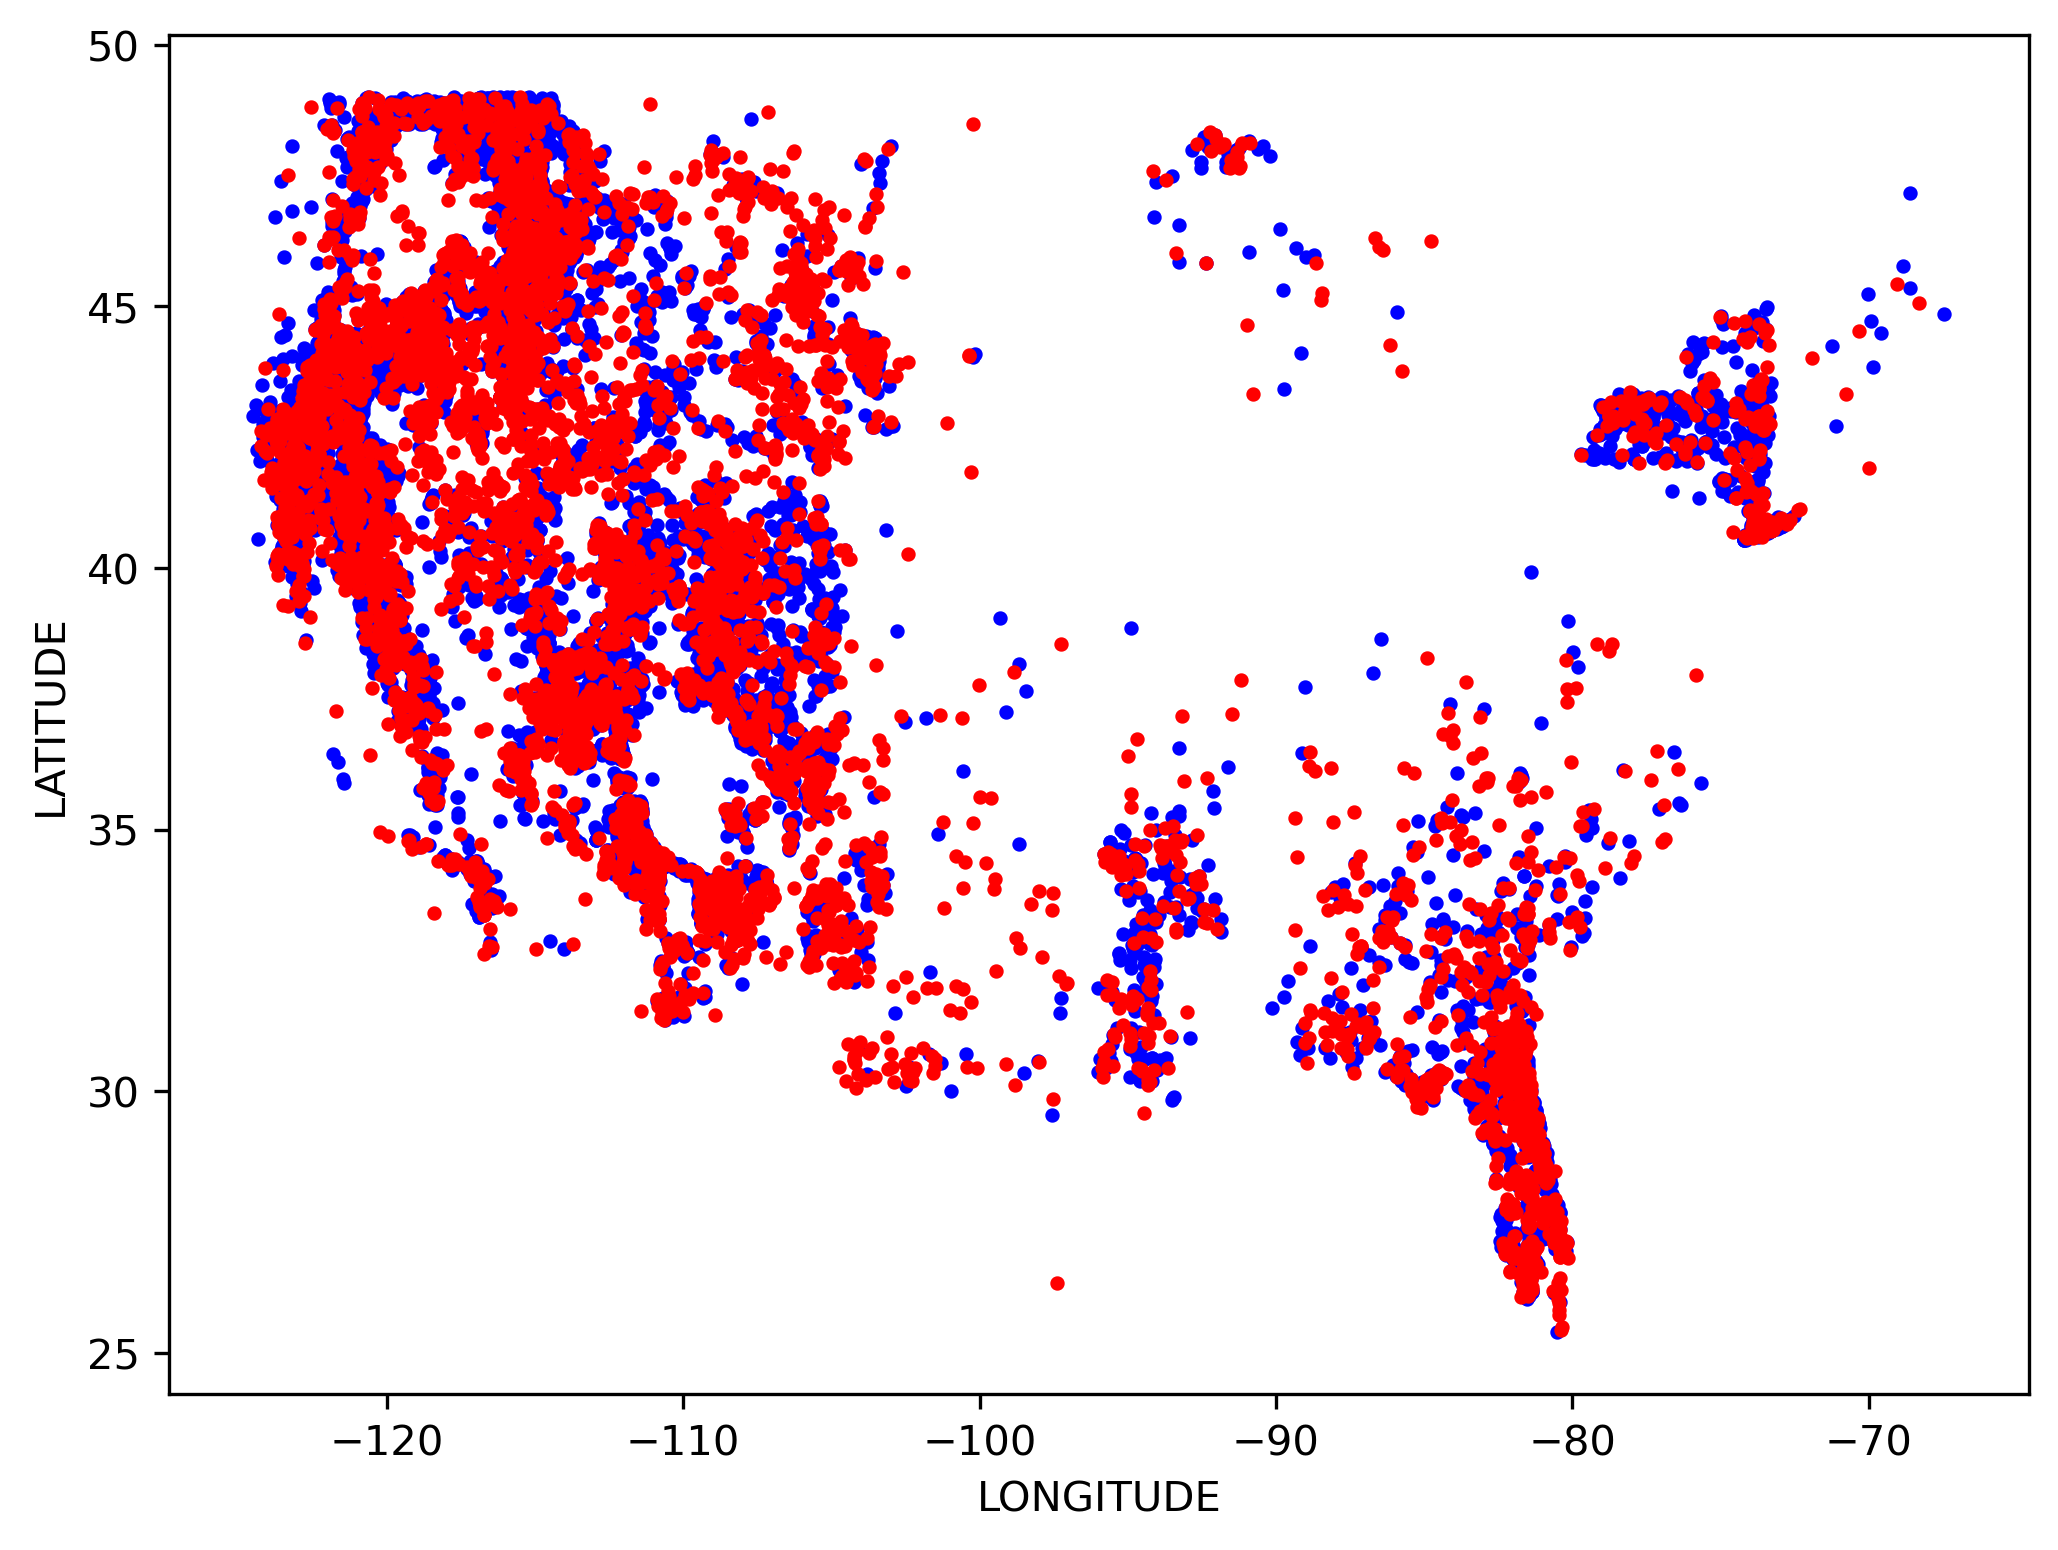

In [168]:
knn_class_acc_fig, knn_class_acc_ax = plot_classification_accuracy(y_knn, y_class_test, X_class_test)

for ext in save_formats:
    knn_class_acc_fig.savefig(figure_dir / f'knn_class_accuracy_hist.{ext}')

plt.show()

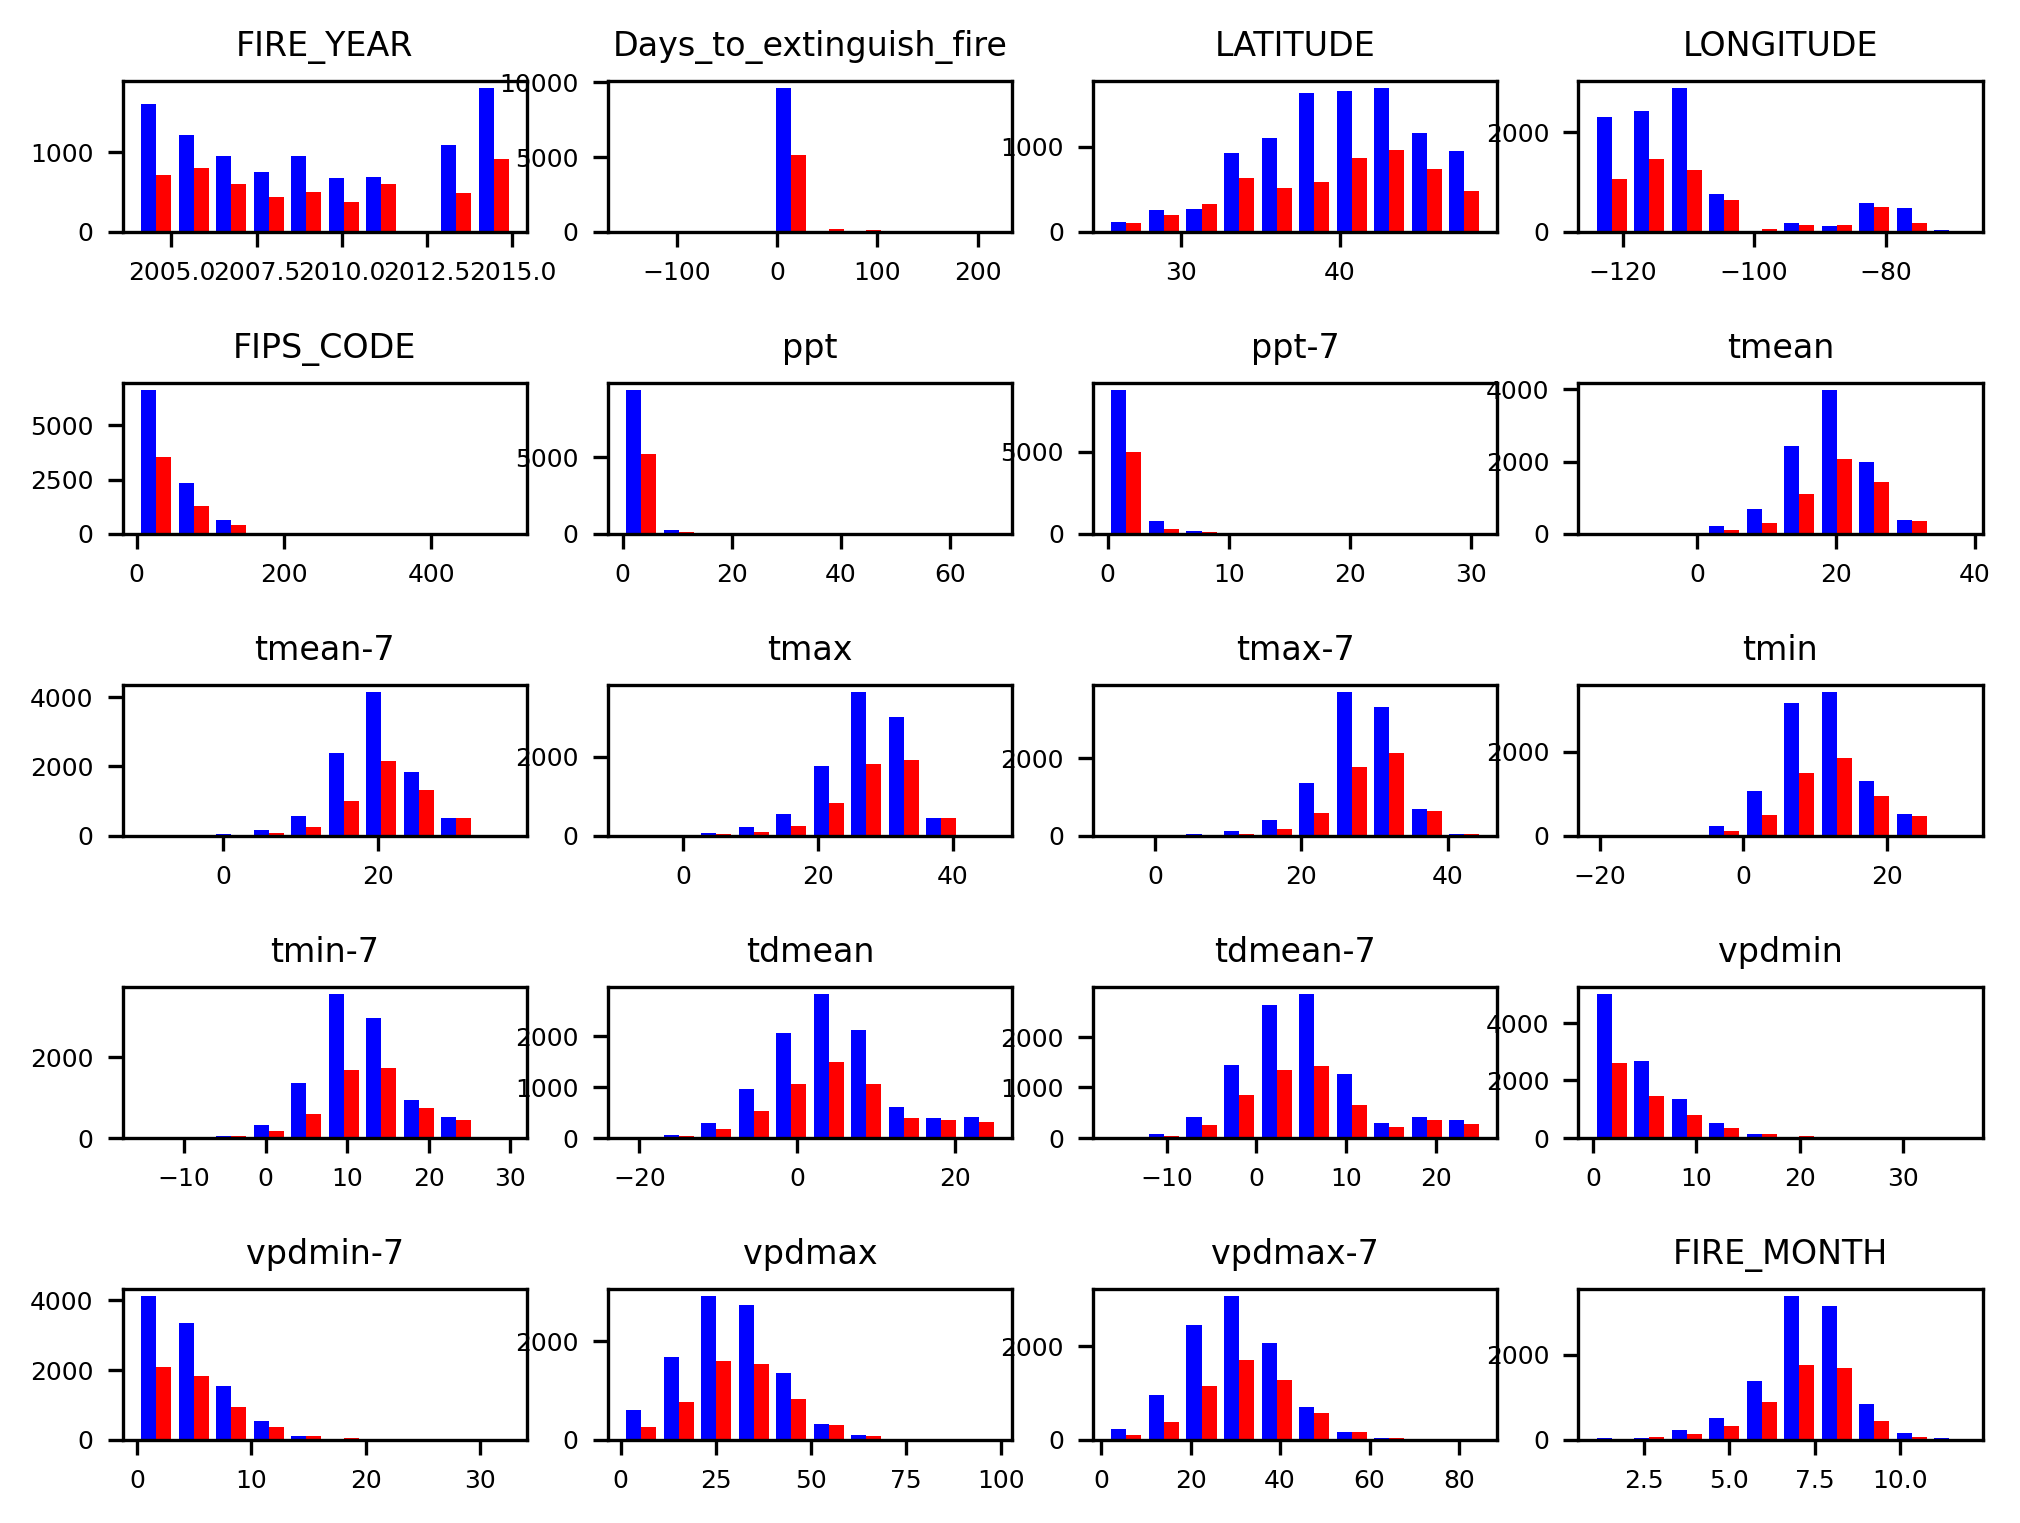

In [169]:
knn_var_hist_fig, knn_var_hist_ax = plot_variable_histograms(y_knn, y_class_test, X_class_test)

for ext in save_formats:
    knn_var_hist_fig.savefig(figure_dir / f'knn_var_hist.{ext}')

plt.show()

## Support Vector Machines

In [205]:
from sklearn import svm

svc = make_pipeline(
    StandardScaler(),
    svm.SVC(
        #max_iter=1000,
        kernel = 'sigmoid',
        tol=1E-6,
    ),
)

svc.fit(X_class_train, y_class_train)
y_svc = svc.predict(X_class_test)
svc_accuracy = sum(y_svc==y_class_test)/len(y_svc)

df_class_results.loc['SVM','accuracy'] = svc_accuracy

display(svc_accuracy)

0.5006275183301407

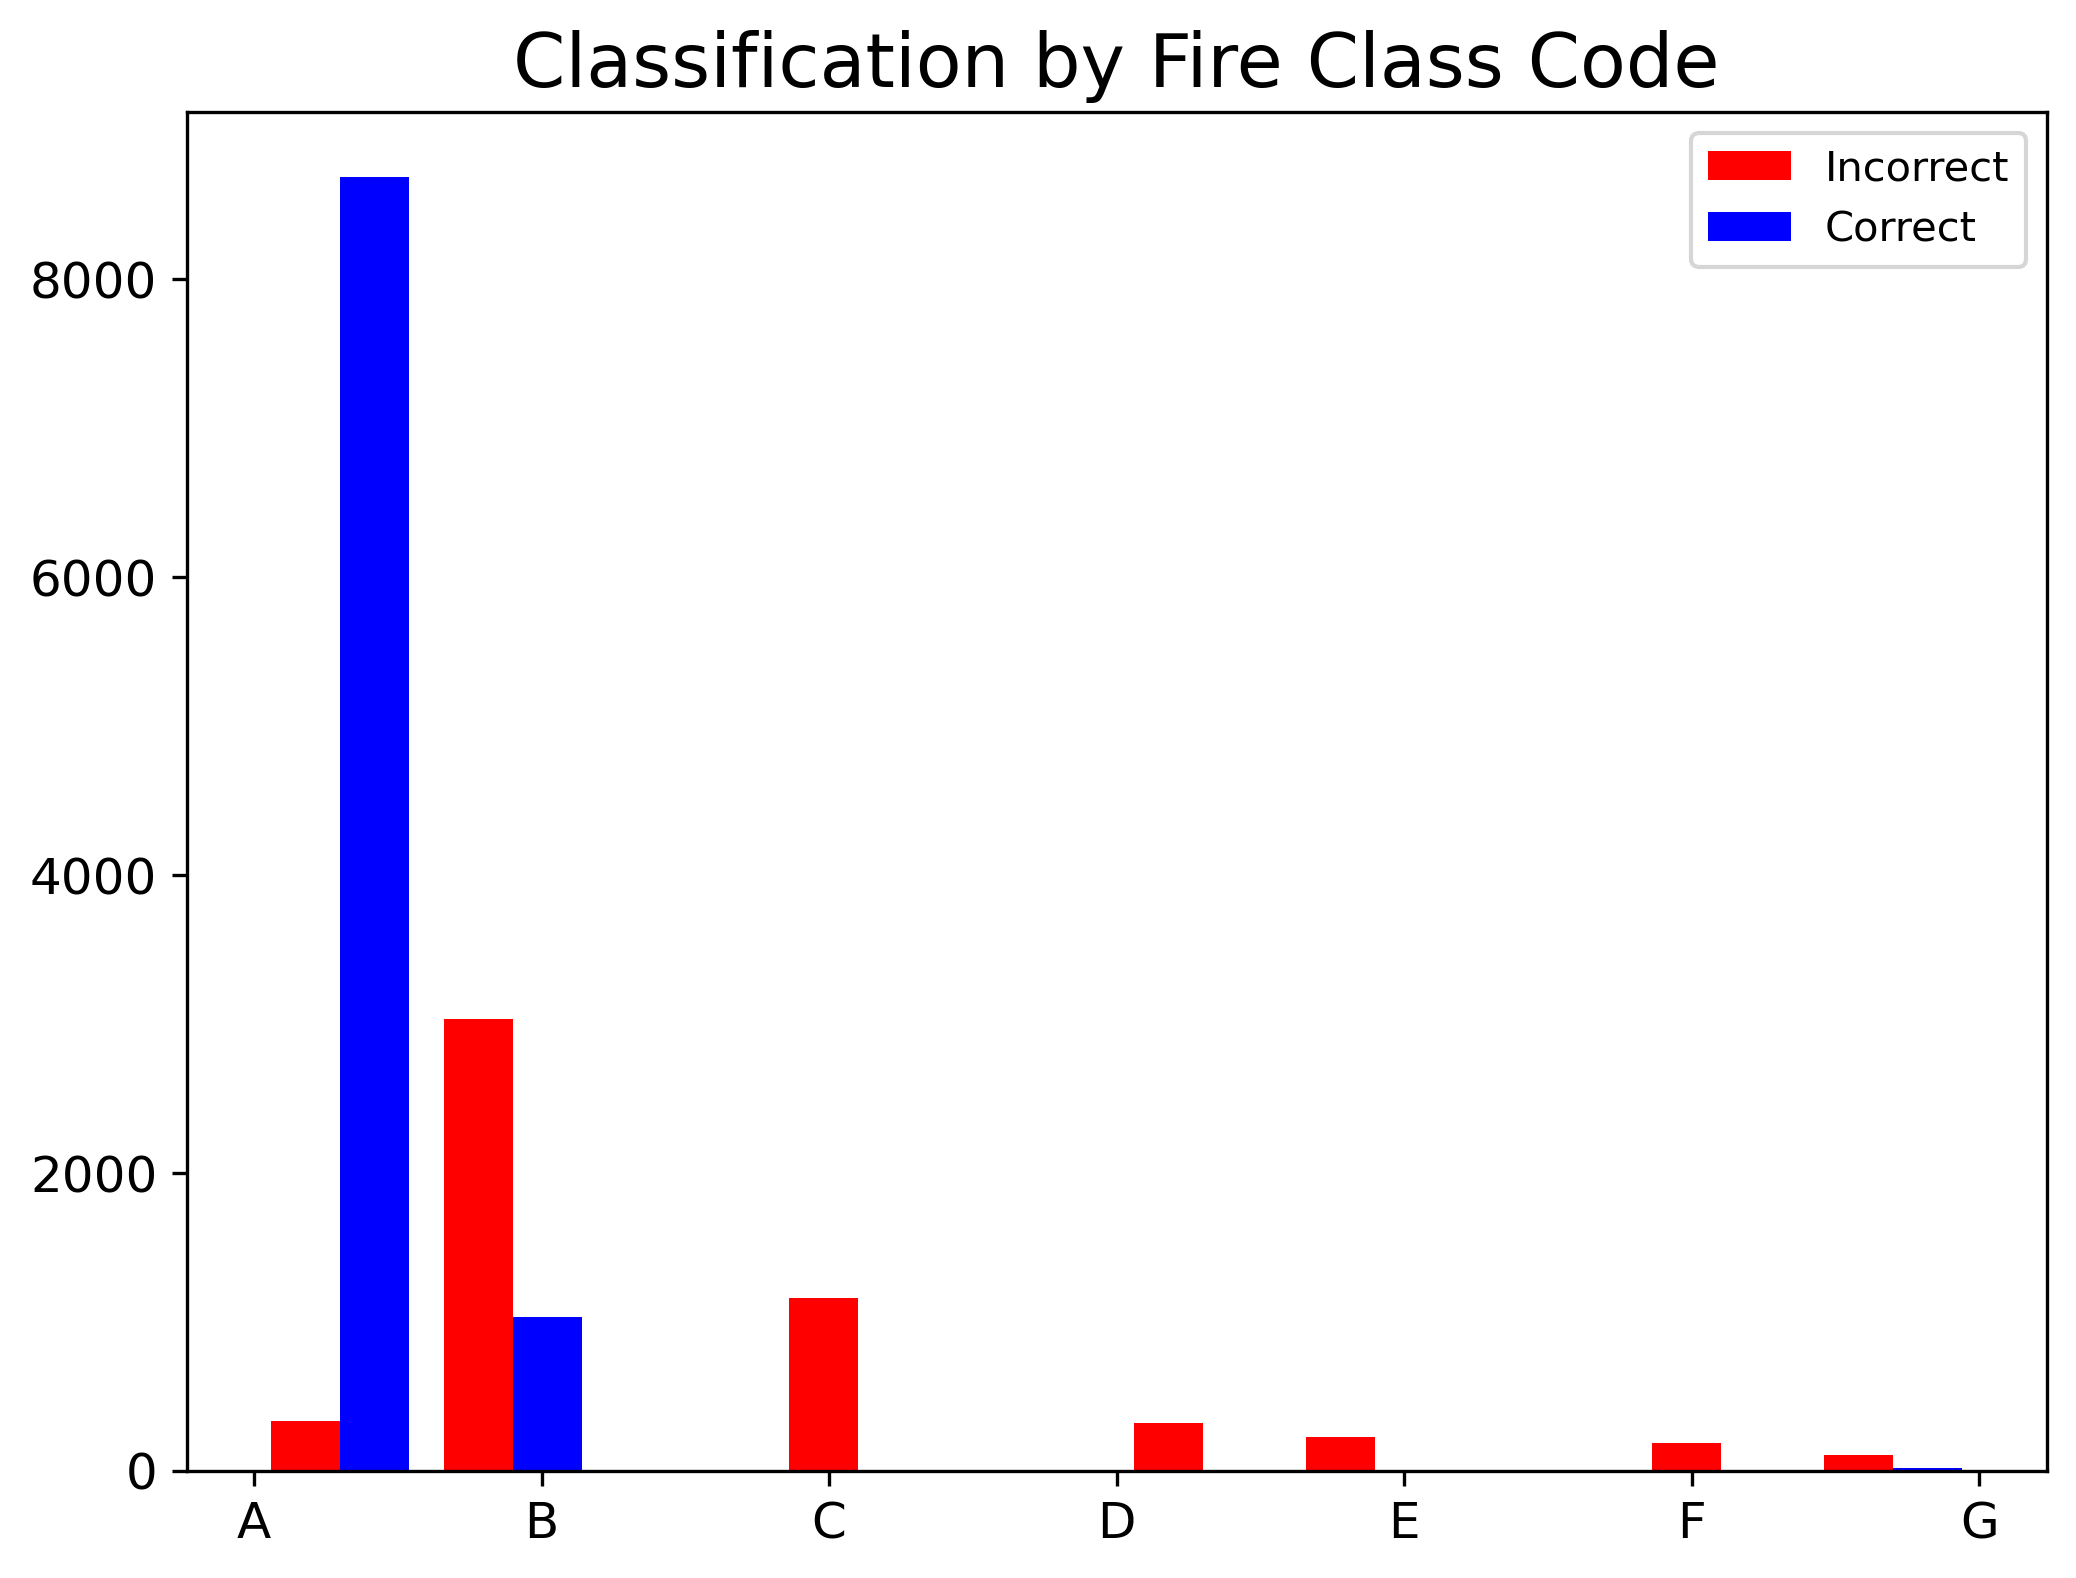

In [171]:
svc_fire_code_fig, svc_fire_code_ax = plot_fire_code_histograms(y_svc, y_class_test)

for ext in save_formats:
    svc_fire_code_fig.savefig(figure_dir / f'svc_fire_code_hist.{ext}')

plt.show()

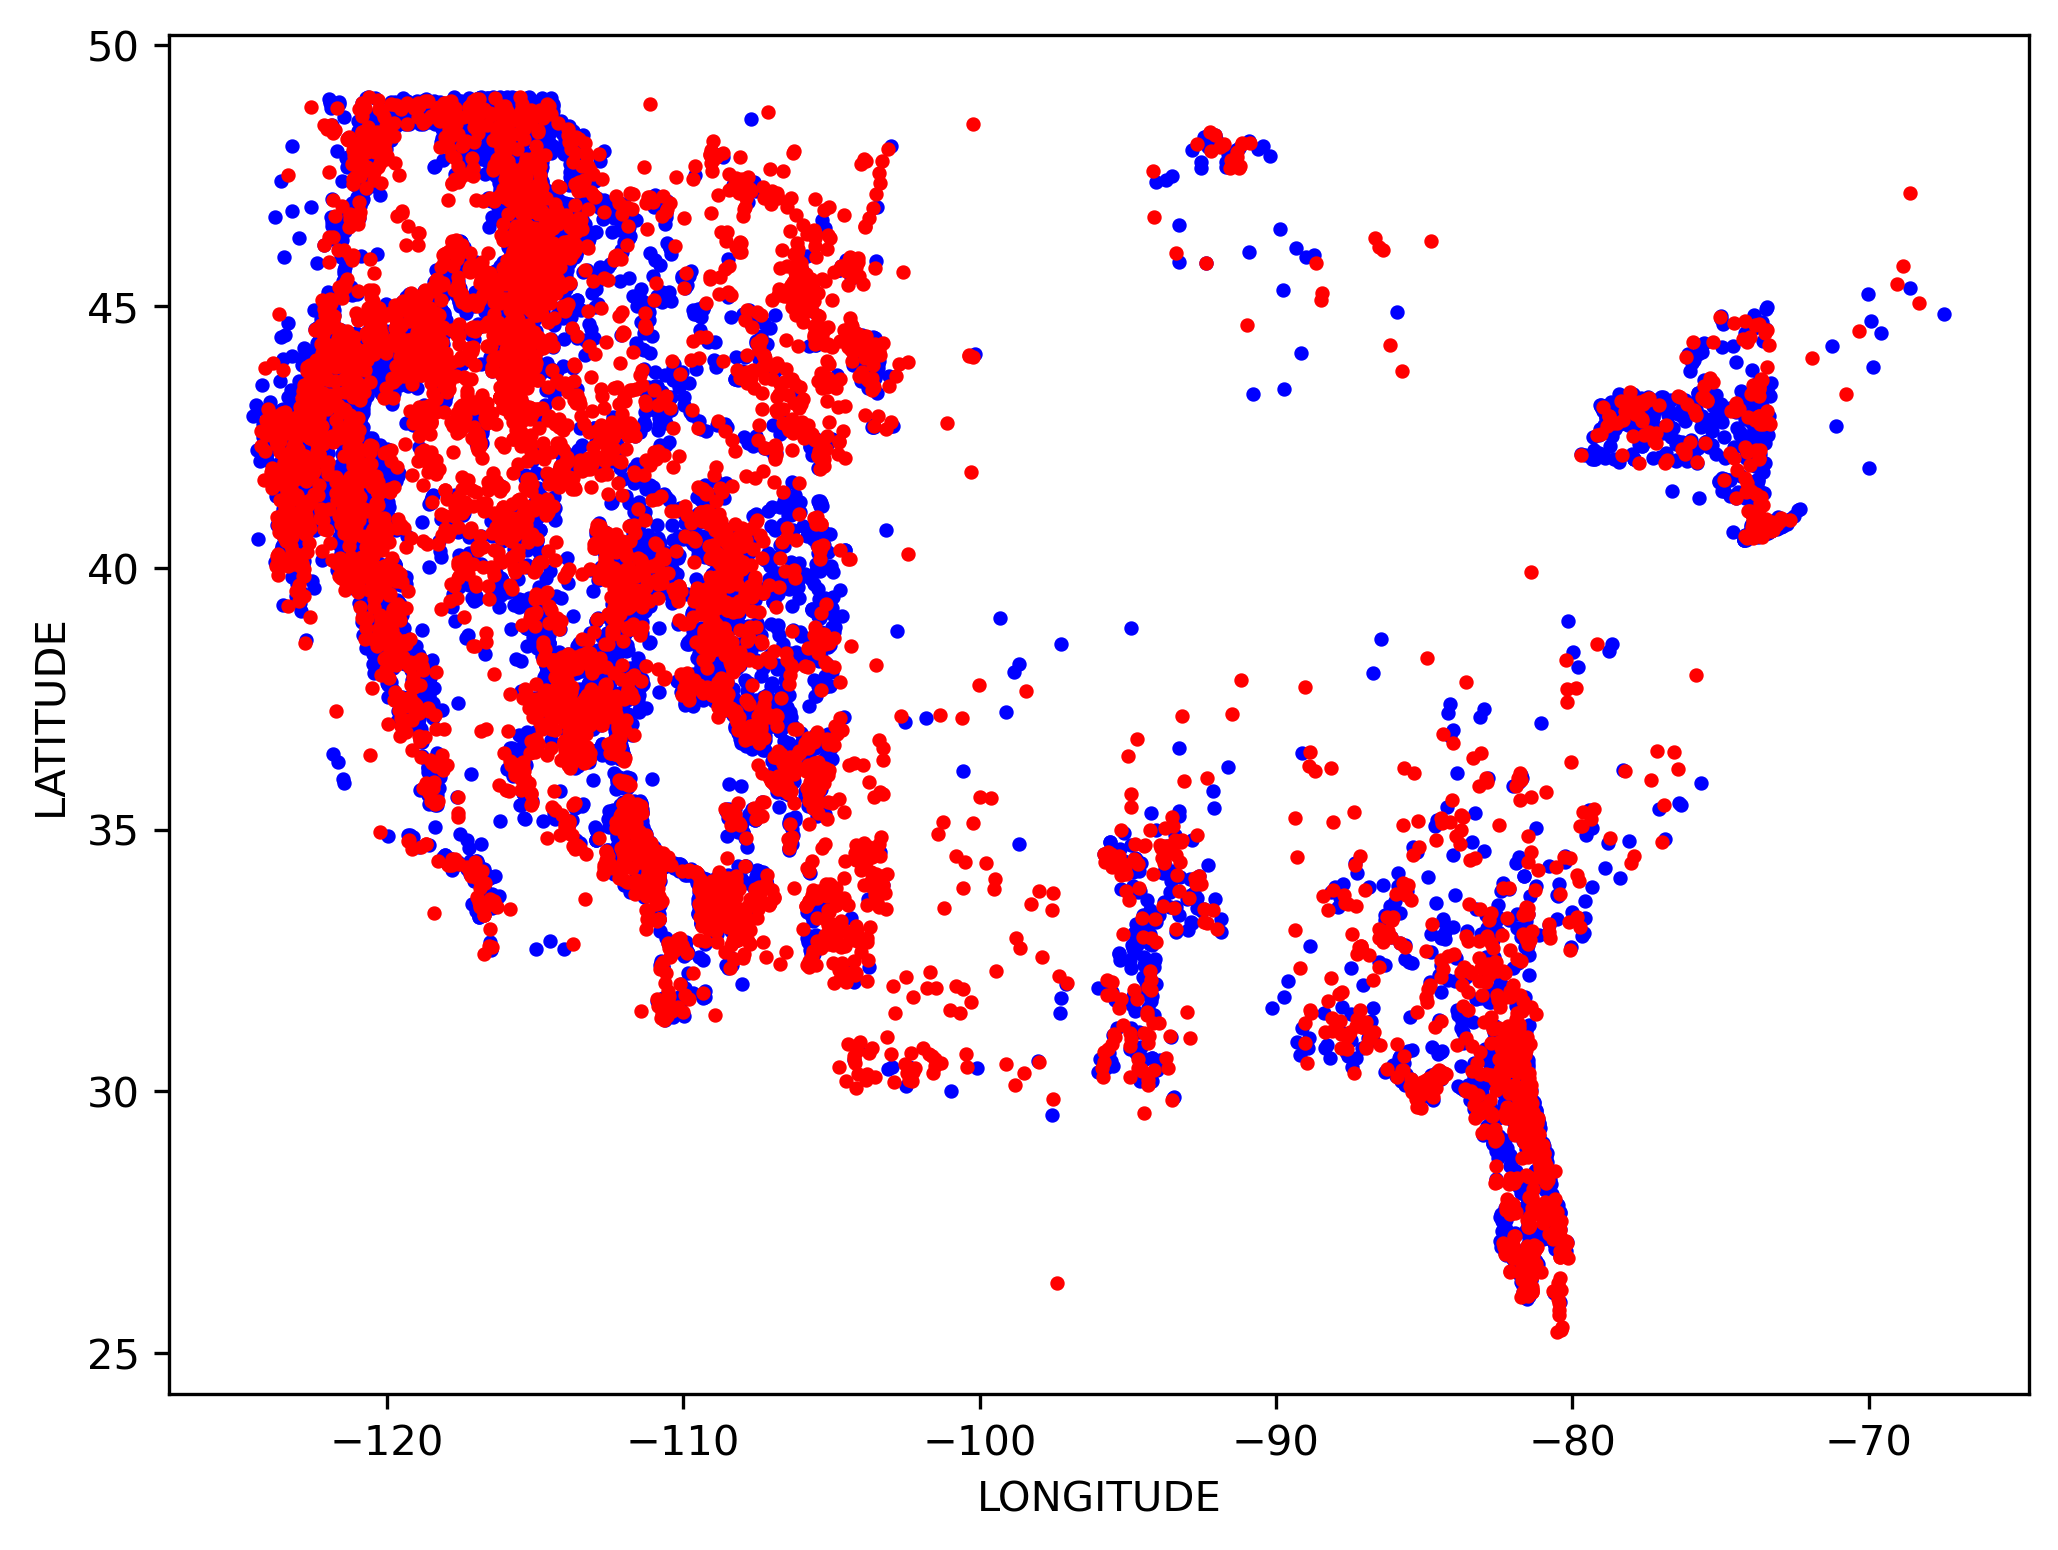

In [172]:
svc_class_acc_fig, svc_class_acc_ax = plot_classification_accuracy(y_svc, y_class_test, X_class_test)

for ext in save_formats:
    svc_class_acc_fig.savefig(figure_dir / f'svc_class_accuracy_hist.{ext}')

plt.show()

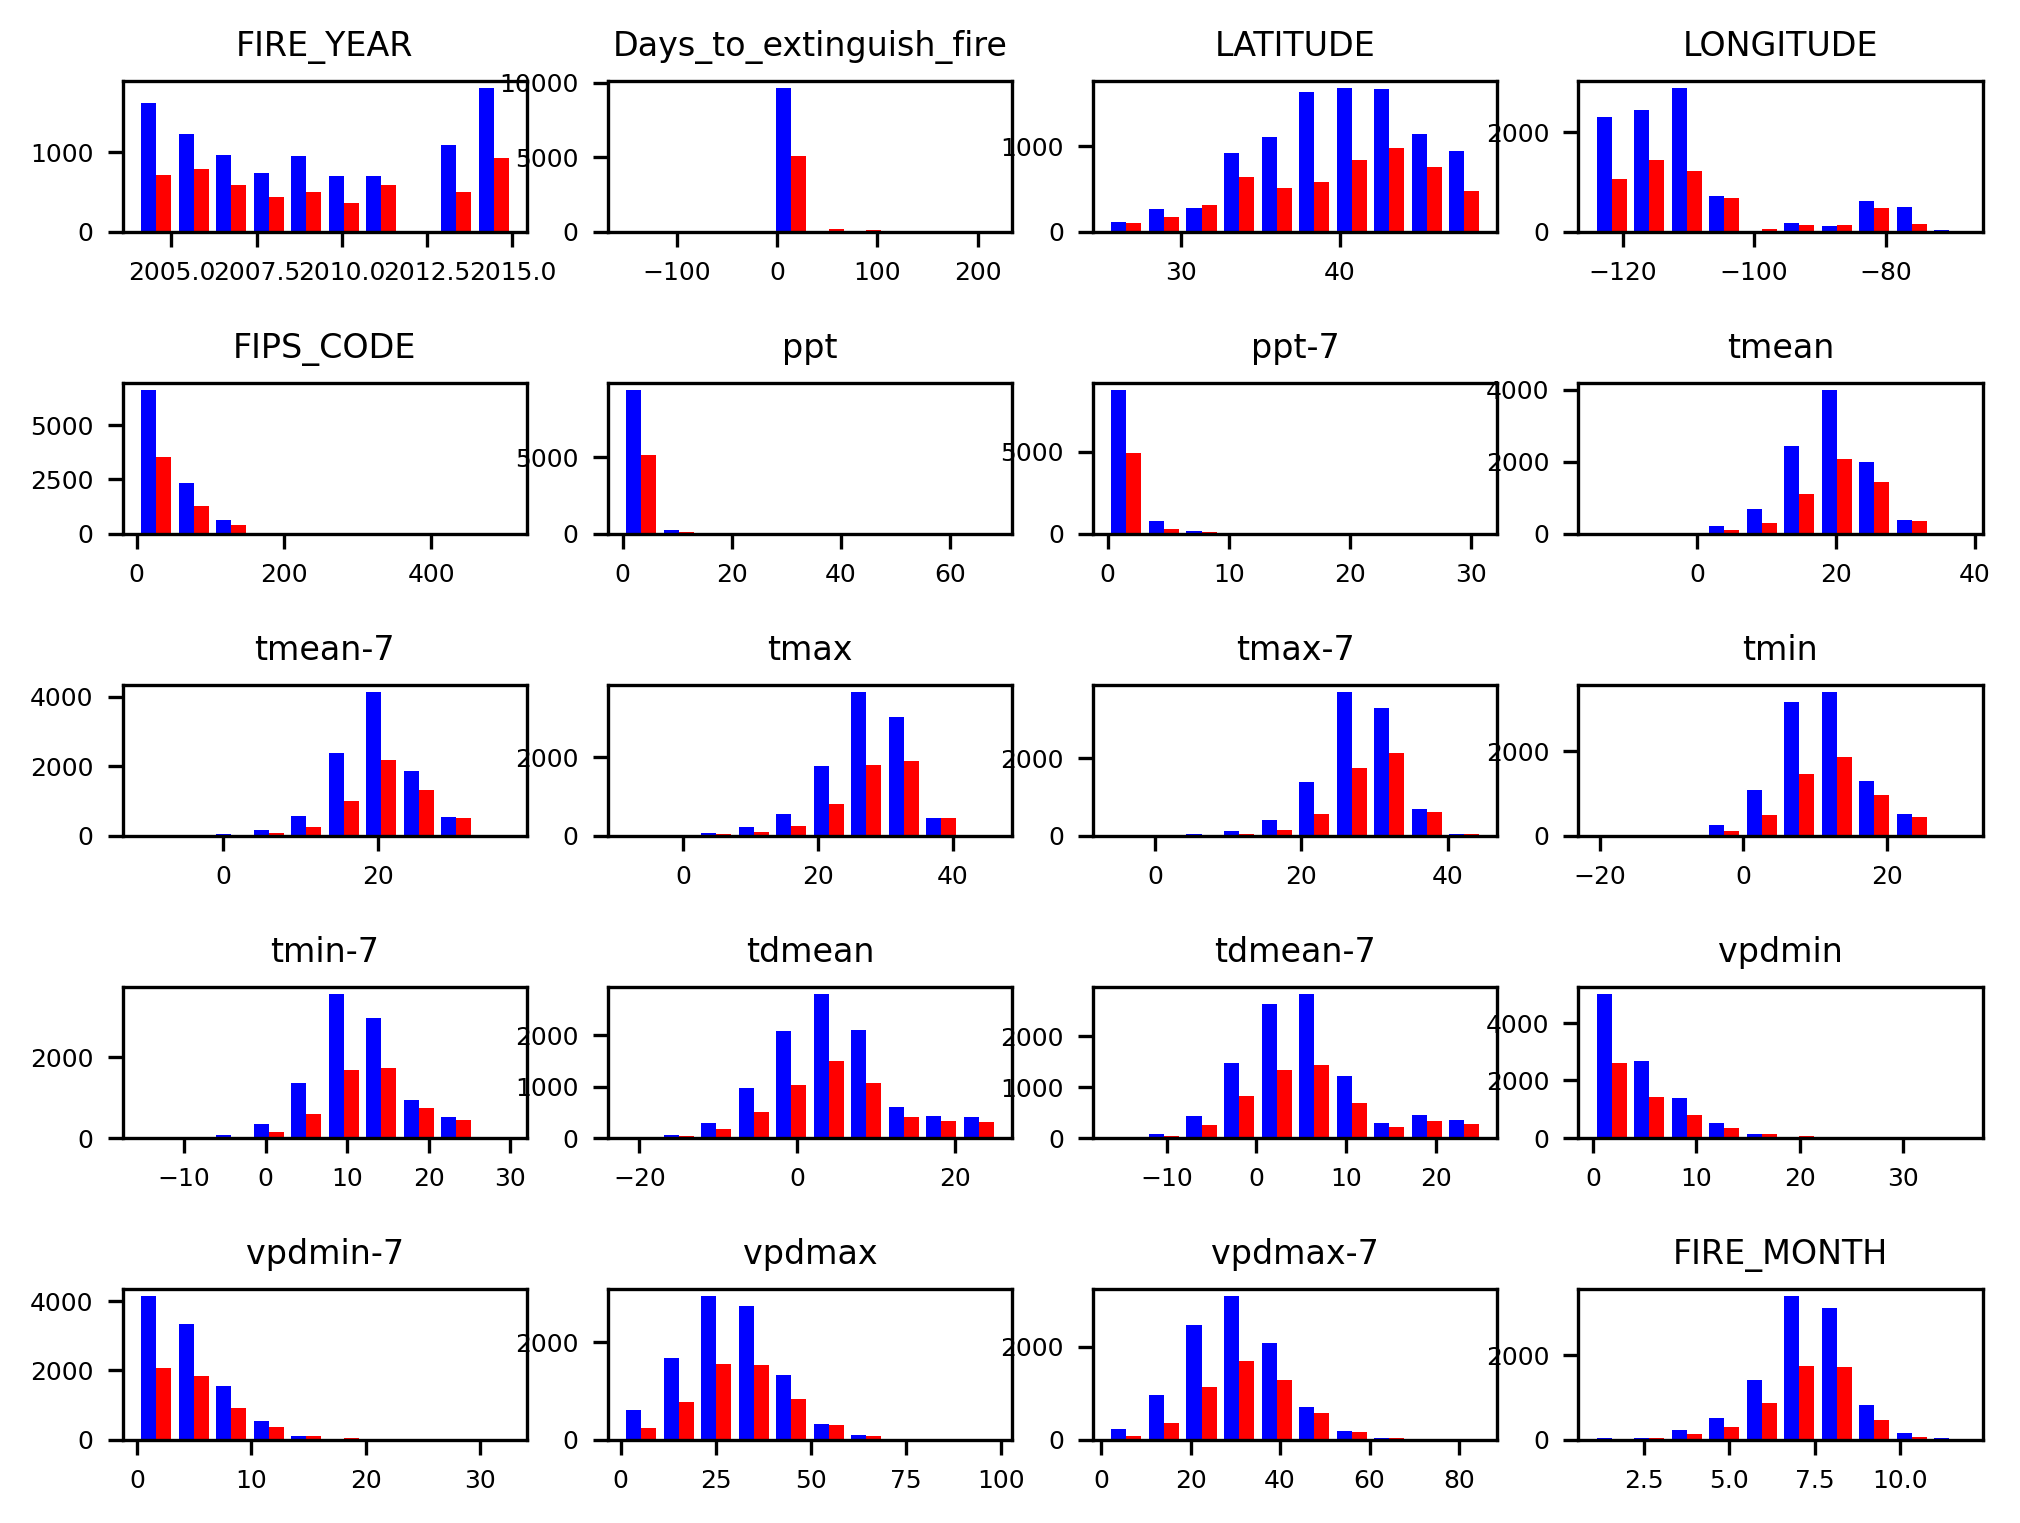

In [173]:
svc_var_hist_fig, svc_var_hist_ax = plot_variable_histograms(y_svc, y_class_test, X_class_test)

for ext in save_formats:
    svc_var_hist_fig.savefig(figure_dir / f'svc_var_hist.{ext}')

plt.show()

In [183]:
df_class_results

accuracy
LDA       0.622102
RRLDA     0.623951
QDA       0.592774
Logistic  0.626594
KNN       0.642909
SVM        0.64456

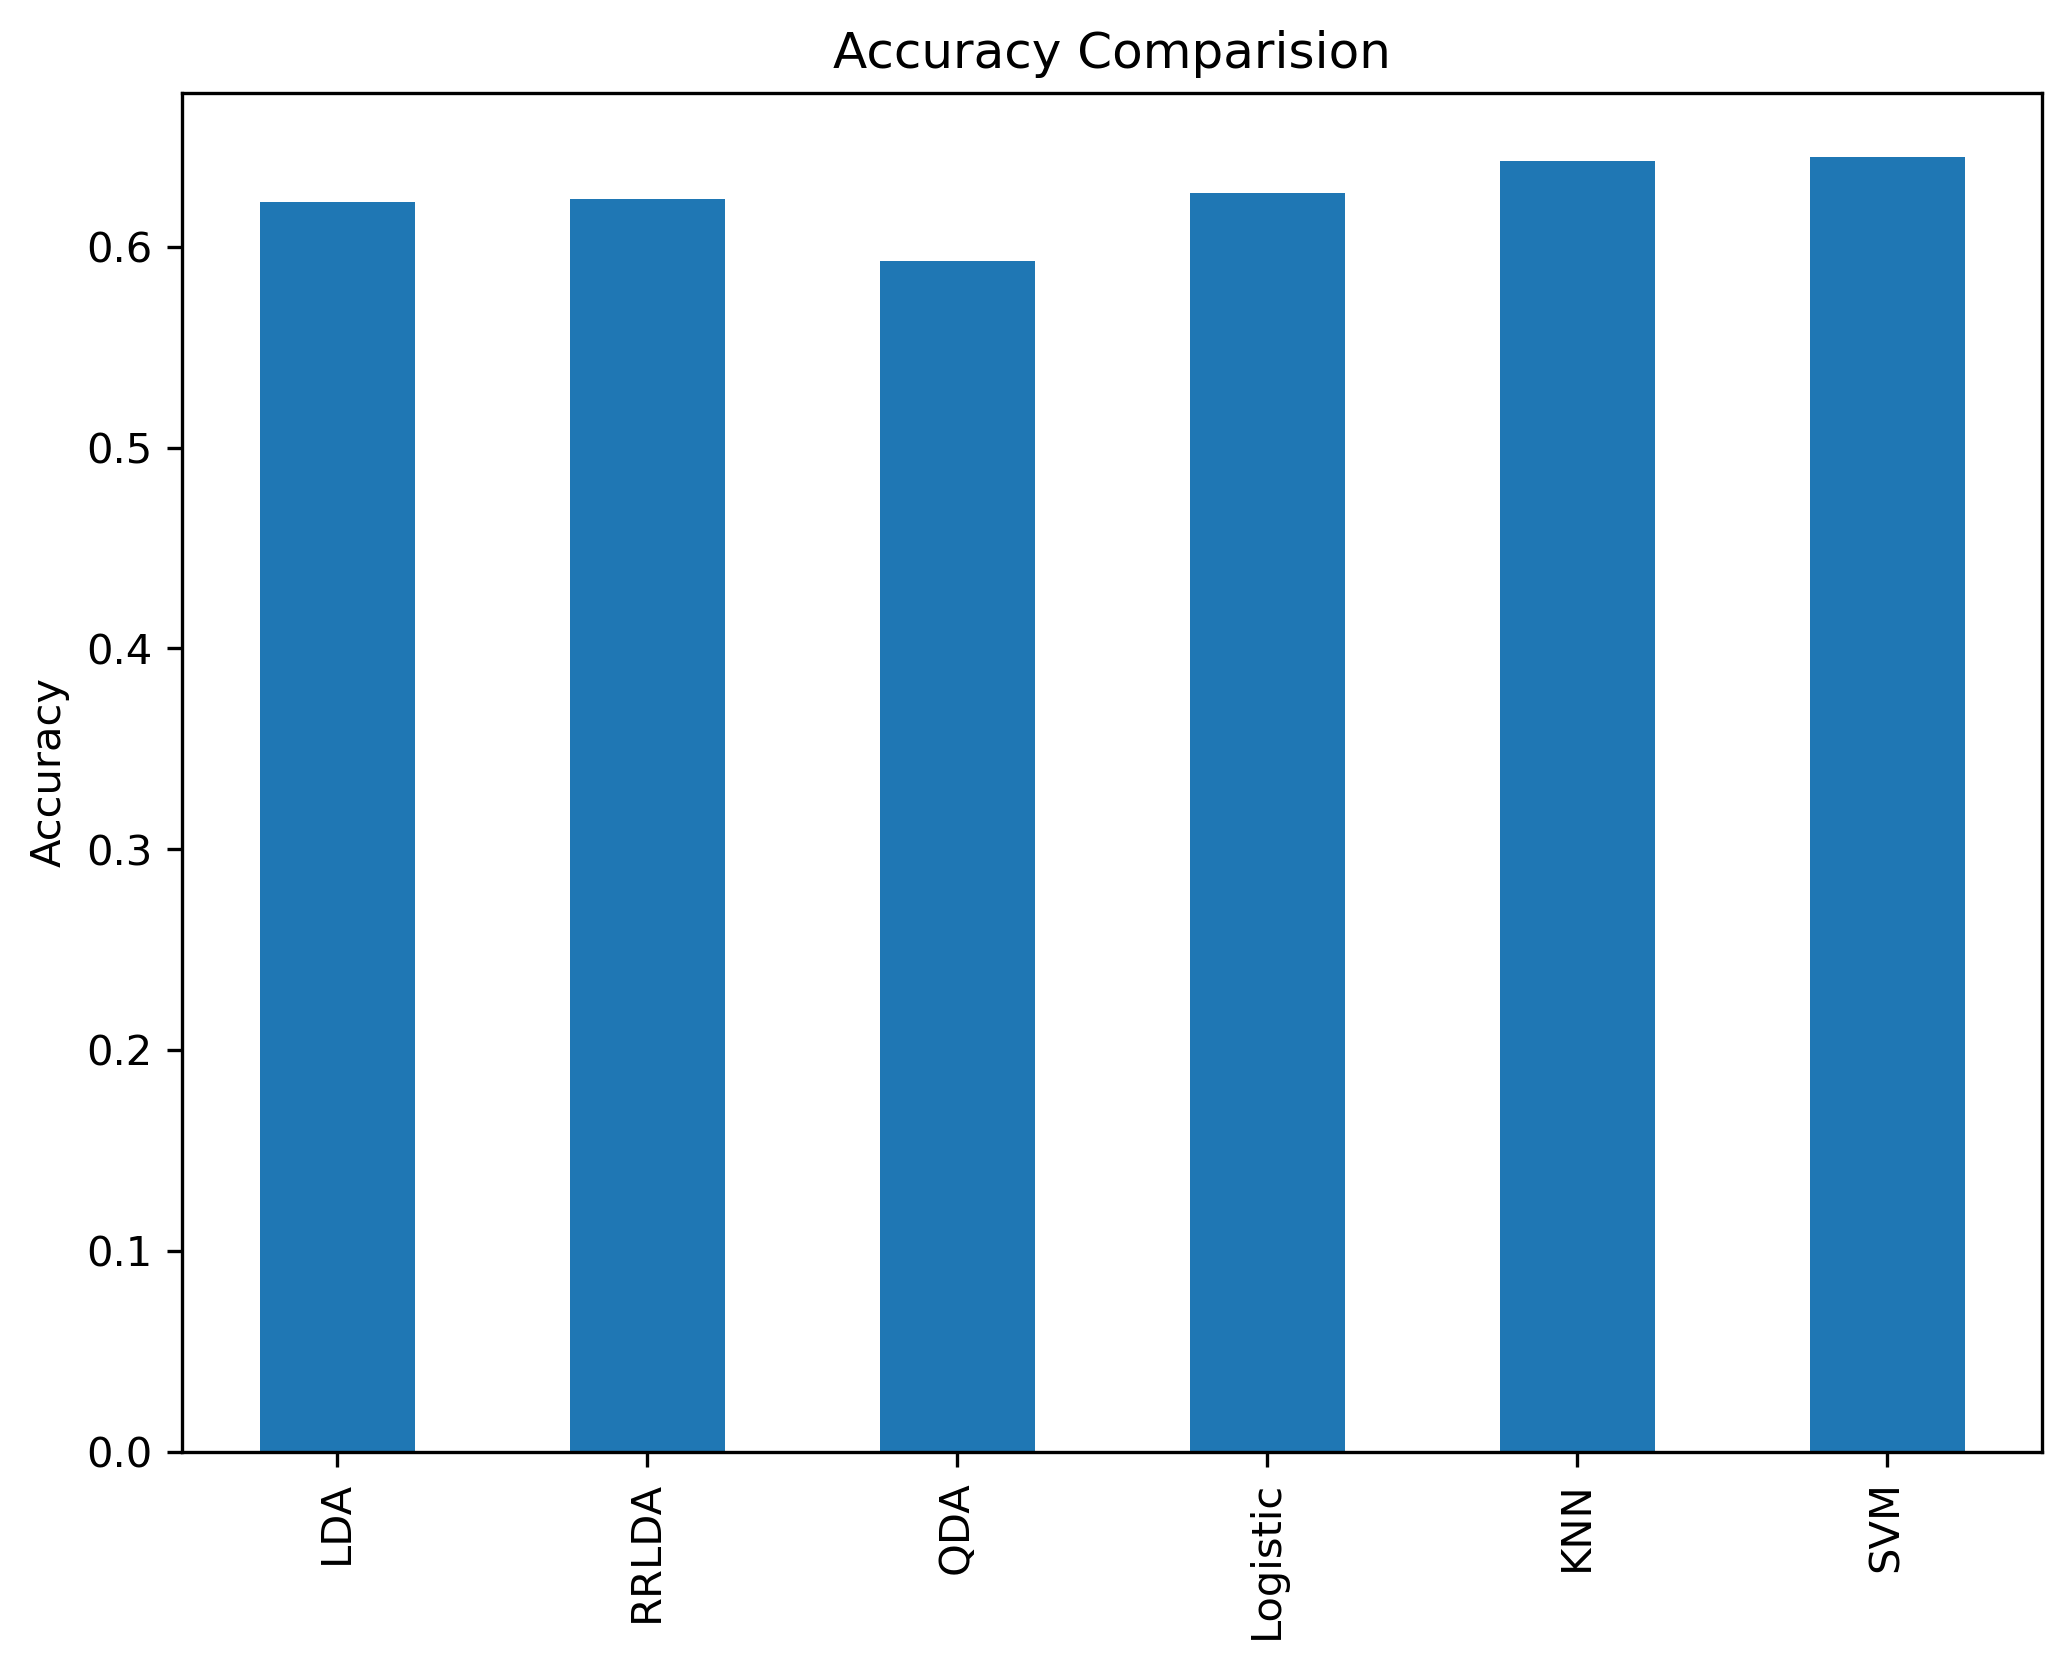

In [184]:
fig_class_res, ax_class_res = plt.subplots(
    figsize=(8,6),
    dpi=300,
)

ax_class_res = df_class_results.accuracy.plot(
    kind='bar',
    ylabel='Accuracy',
    title='Accuracy Comparision',
    ax=ax_class_res
)

for ext in save_formats:
    fig_class_res.savefig(figure_dir / f'accuracy_class_compare.{ext}')

# Regression

Another interesting question is whether the number of days to put out a fire can be predicted. Consider linear regression as a starting point.

Split the data set into a training and testing set.

In [53]:
df_reg = df_cleaned[numeric_cols].drop('Days_to_extinguish_fire', axis=1)

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    df_reg,
    df_cleaned.Days_to_extinguish_fire,
    test_size=0.1,
    random_state=625_742, # class code for random number seed
)

In [54]:
df_reg_results = pd.DataFrame(
    data=[],
    index=[
        'Linear',
        'Ridge',
        'Lasso',
        'RFE Based Best Subset',
        'PCA',
    ],
    columns=['score','rmse'],
)

In [55]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

## Linear Regression

In [56]:
lin_reg = make_pipeline(
    StandardScaler(),
    LinearRegression(fit_intercept=False),
).fit(X_reg_train, y_reg_train)

y_lr = lin_reg.predict(X_reg_test)
msqr_err_lr = np.mean(np.square(y_lr - y_reg_test))
display(msqr_err_lr)

# Note that the pipeline score calls the score of the final estimator which in this case is LinearRegression.score
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline.score
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score
lin_score = lin_reg.score(X_reg_test, y_reg_test)
df_reg_results.loc['Linear','score'] = lin_score
df_reg_results.loc['Linear','rmse'] = mean_squared_error(y_lr, y_reg_test, squared=False)
display(lin_score)

149.32355428084819

0.03864812899639303

## Ridge Regression

In [57]:
ridge_reg = make_pipeline(
    StandardScaler(),
    Ridge(fit_intercept=False),
).fit(X_reg_train, y_reg_train)

y_ridge = ridge_reg.predict(X_reg_test)
msqr_err_ridge = np.mean(np.square(y_ridge - y_reg_test))
display(msqr_err_ridge)
display(msqr_err_ridge / y_reg_train.var())

# Note that the pipeline score calls the score of the final estimator which in this case is LinearRegression.score
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline.score
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge.score
ridge_score = ridge_reg.score(X_reg_test, y_reg_test)
df_reg_results.loc['Ridge','score'] = ridge_score
df_reg_results.loc['Ridge','rmse'] = mean_squared_error(y_ridge, y_reg_test, squared=False)
display(ridge_score)

149.34182571782642

0.9613621498261027

0.0385304966495752

## Lasso Regression

In [58]:
lasso_reg = make_pipeline(
    StandardScaler(),
    Lasso(fit_intercept=False),
).fit(X_reg_train, y_reg_train)

y_lasso = lasso_reg.predict(X_reg_test)
msqr_err_lasso = np.mean(np.square(y_lasso - y_reg_test))
display(msqr_err_lasso)
display(msqr_err_lasso / y_reg_train.var())

# Note that the pipeline score calls the score of the final estimator which in this case is LinearRegression.score
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline.score
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge.score
lasso_score = lasso_reg.score(X_reg_test, y_reg_test)
df_reg_results.loc['Lasso','score'] = lasso_score
df_reg_results.loc['Lasso','rmse'] = mean_squared_error(y_lasso, y_reg_test, squared=False)
display(lasso_score)

154.3214333524533

0.9934175119318301

0.00647155498114349

## RFE Based Best Subset Selection

Try Best Subset Selection

Note that with the increased number of columns added from the climate data, brute force permutation will take quite a while. We use sci-kit learns [recursive feature elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) algorithm to determine how many columns to keep for a specific size.

In [59]:
len(df_reg.columns)

21

In [60]:
df_reg.columns

Index(['FIRE_YEAR', 'FIRE_SIZE', 'LATITUDE', 'LONGITUDE', 'FIPS_CODE', 'ppt',
       'ppt-7', 'tmean', 'tmean-7', 'tmax', 'tmax-7', 'tmin', 'tmin-7',
       'tdmean', 'tdmean-7', 'vpdmin', 'vpdmin-7', 'vpdmax', 'vpdmax-7',
       'FIRE_MONTH', 'FIRE_SIZE_CLASS_CODES'],
      dtype='object')

In [61]:
p = len(df_reg.columns)

df_bss = pd.DataFrame(
    data=[], 
    index=['Intercept', *df_reg.columns],
    columns=[f'k={ii}' for ii in range(1, p+1)],
)
df_bss_error = pd.DataFrame(
    data=[], 
    index=['score', 'rmse'],
    columns=[f'k={ii}' for ii in range(1, p+1)],
)


for k in range(1, p+1):

    lin_reg_bss = make_pipeline(
        StandardScaler(),
        # https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
        RFE(
            estimator=LinearRegression(fit_intercept=True),
            n_features_to_select=k,
        ),
        LinearRegression(fit_intercept=True),
    ).fit(X_reg_train, y_reg_train)

    selector = lin_reg_bss.steps[1][-1]
    ols_model = lin_reg_bss.steps[2][-1]

    selected_columns = df_reg.columns[selector.support_]
    
    df_bss_error.loc['score', f'k={k}'] = lin_reg_bss.score(X_reg_test, y_reg_test)
    df_bss_error.loc['rmse', f'k={k}'] = mean_squared_error(
        y_true=y_reg_test,
        y_pred=lin_reg_bss.predict(X_reg_test),
        squared=False,
    )

    df_bss.loc[['Intercept', *selected_columns], f'k={k}'] = np.array([ols_model.intercept_, *ols_model.coef_])
    

df_reg_results.loc['RFE Based Best Subset','score'] = df_bss_error.loc['score',:].max()
df_reg_results.loc['RFE Based Best Subset','rmse'] = df_bss_error.loc['rmse',:].min()

display(df_bss_error)

k=1        k=2        k=3        k=4        k=5        k=6  \
score  0.006346   0.006137   0.006101   0.007583   0.007567   0.007618   
rmse    12.4234  12.424708  12.424933  12.415666  12.415766  12.415451   

             k=7        k=8       k=9       k=10  ...       k=12       k=13  \
score   0.115151   0.125499  0.126085   0.128268  ...   0.136618   0.136935   
rmse   11.723509  11.654753  11.65085  11.636289  ...  11.580426  11.578296   

            k=14       k=15      k=16       k=17      k=18       k=19  \
score   0.137349   0.137581  0.137531   0.137514  0.137513   0.137526   
rmse   11.575522  11.573963   11.5743  11.574415  11.57442  11.574336   

            k=20       k=21  
score   0.137628   0.137647  
rmse   11.573647  11.573523  

[2 rows x 21 columns]

In [62]:
display(df_bss.replace({ np.nan: '' }))

k=1       k=2         k=3         k=4         k=5  \
Intercept              4.032228  4.032228    4.032228    4.032228    4.032228   
FIRE_YEAR                                                                       
FIRE_SIZE                                                                       
LATITUDE                                                                        
LONGITUDE                                                                       
FIPS_CODE                                                                       
ppt                                                                             
ppt-7                                                                           
tmean                 -0.902642 -1.220378 -901.456461 -902.405586 -895.820901   
tmean-7                                                 -0.746613   -0.967641   
tmax                             0.335925  492.914643  493.766215   490.09663   
tmax-7                                                               0.206215   
tmin                                        462.82266  463.689717  460.399441   
tmin-7                                                                          
tdmean                                                                          
tdmean-7                                                                        
vpdmin                                                                          
vpdmin-7                                                                        
vpdmax                                                                          
vpdmax-7                                                                        
FIRE_MONTH                                                                      
FIRE_SIZE_CLASS_CODES                                                           

                               k=6          k=7          k=8          k=9  \
Intercept                 4.032228     4.032228     4.032228     4.032228   
FIRE_YEAR                                                                   
FIRE_SIZE                                                                   
LATITUDE                                                                    
LONGITUDE                                          -1.452264     -1.57022   
FIPS_CODE                                                                   
ppt                                                                         
ppt-7                                                                       
tmean                 -1034.103773 -1242.289086 -1334.824251 -1344.972915   
tmean-7                 818.453048 -1974.779716   226.563323  1648.919793   
tmax                    565.760458   680.069407   730.535488   736.094476   
tmax-7                 -432.778308  1042.426928  -121.724741  -872.172524   
tmin                    531.492273   637.998436   685.715317   690.872793   
tmin-7                 -429.781758  1035.314221  -118.167587  -864.487296   
tdmean                                                                      
tdmean-7                                                                    
vpdmin                                                                      
vpdmin-7                                                                    
vpdmax                                                                      
vpdmax-7                                                        -0.992231   
FIRE_MONTH                                                                  
FIRE_SIZE_CLASS_CODES                  4.305529     4.441003     4.471004   

                              k=10  ...         k=12         k=13  \
Intercept                 4.032228  ...     4.032228     4.032228   
FIRE_YEAR                           ...                             
FIRE_SIZE                           ...     0.811422     0.811798   
LATITUDE                  0.984001  ...     0.979913     0.977261   
LONGITUDE                -1.167194  ...    -0.9

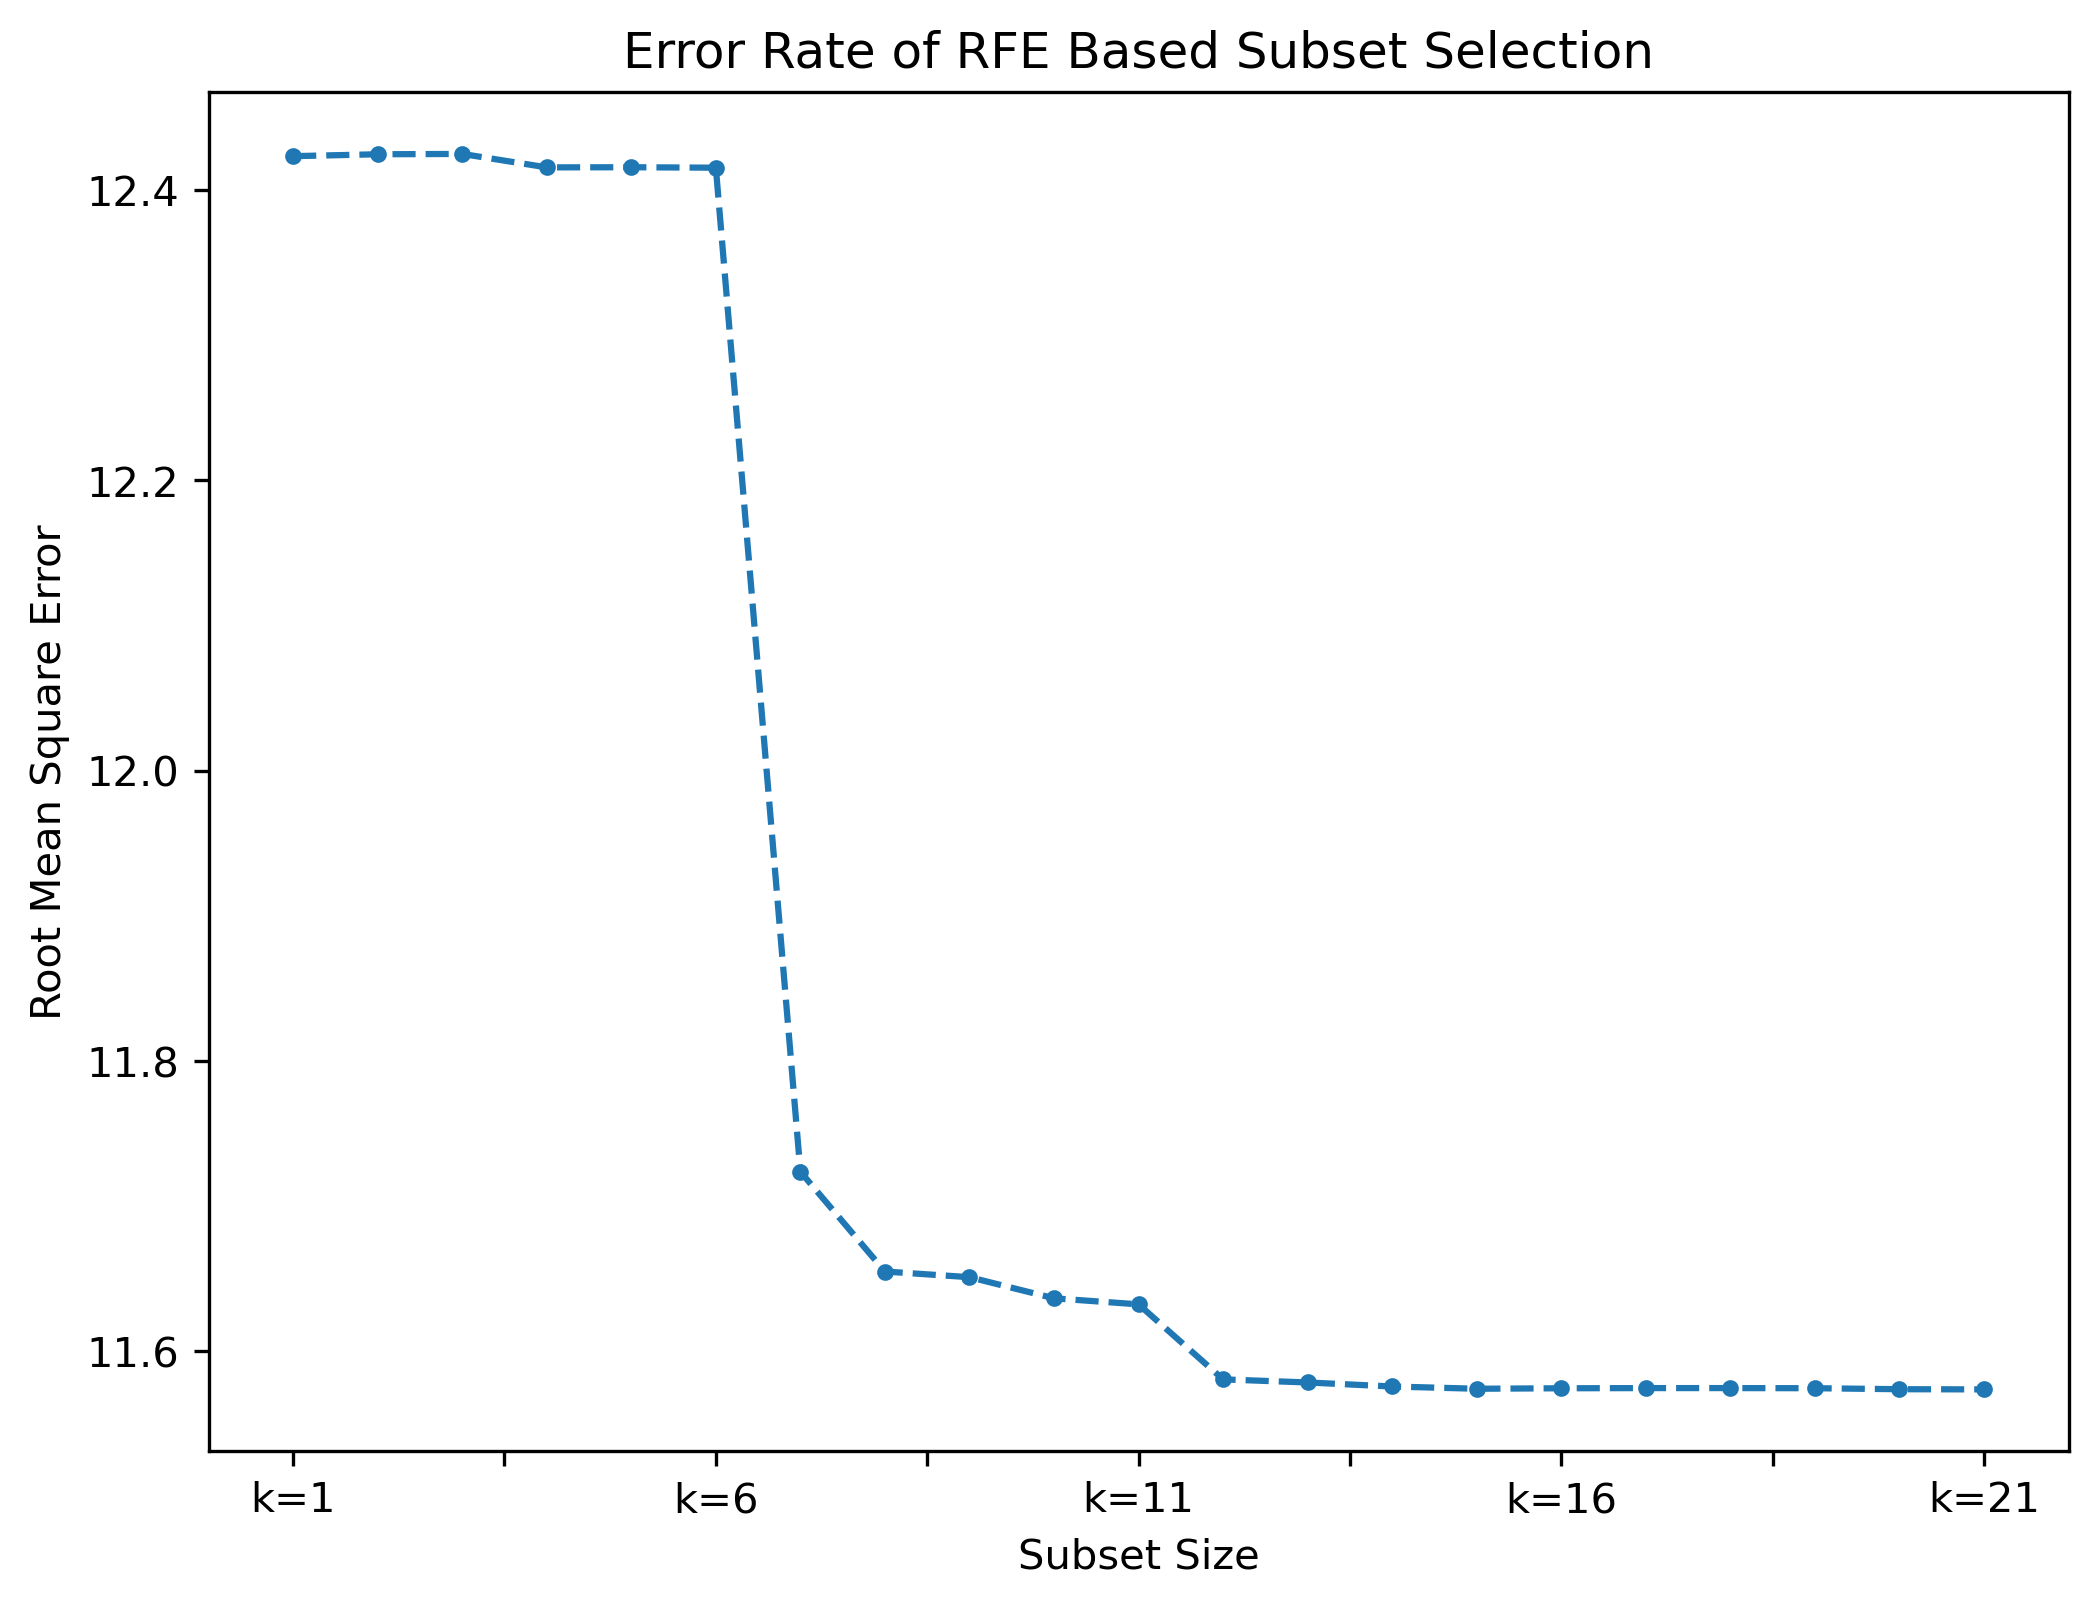

In [63]:
fig2, ax2 = plt.subplots(
    figsize=(8,6),
    dpi=300,
)

df_bss_error.loc['rmse'].plot(
    ax=ax2,
    marker='.',
    linestyle='--',
)

ax2.set_ylabel('Root Mean Square Error')
ax2.set_xlabel('Subset Size')
ax2.set_title('Error Rate of RFE Based Subset Selection')

for ext in save_formats:
    fig2.savefig(figure_dir / f'rfe_bss_error.{ext}')

plt.show()

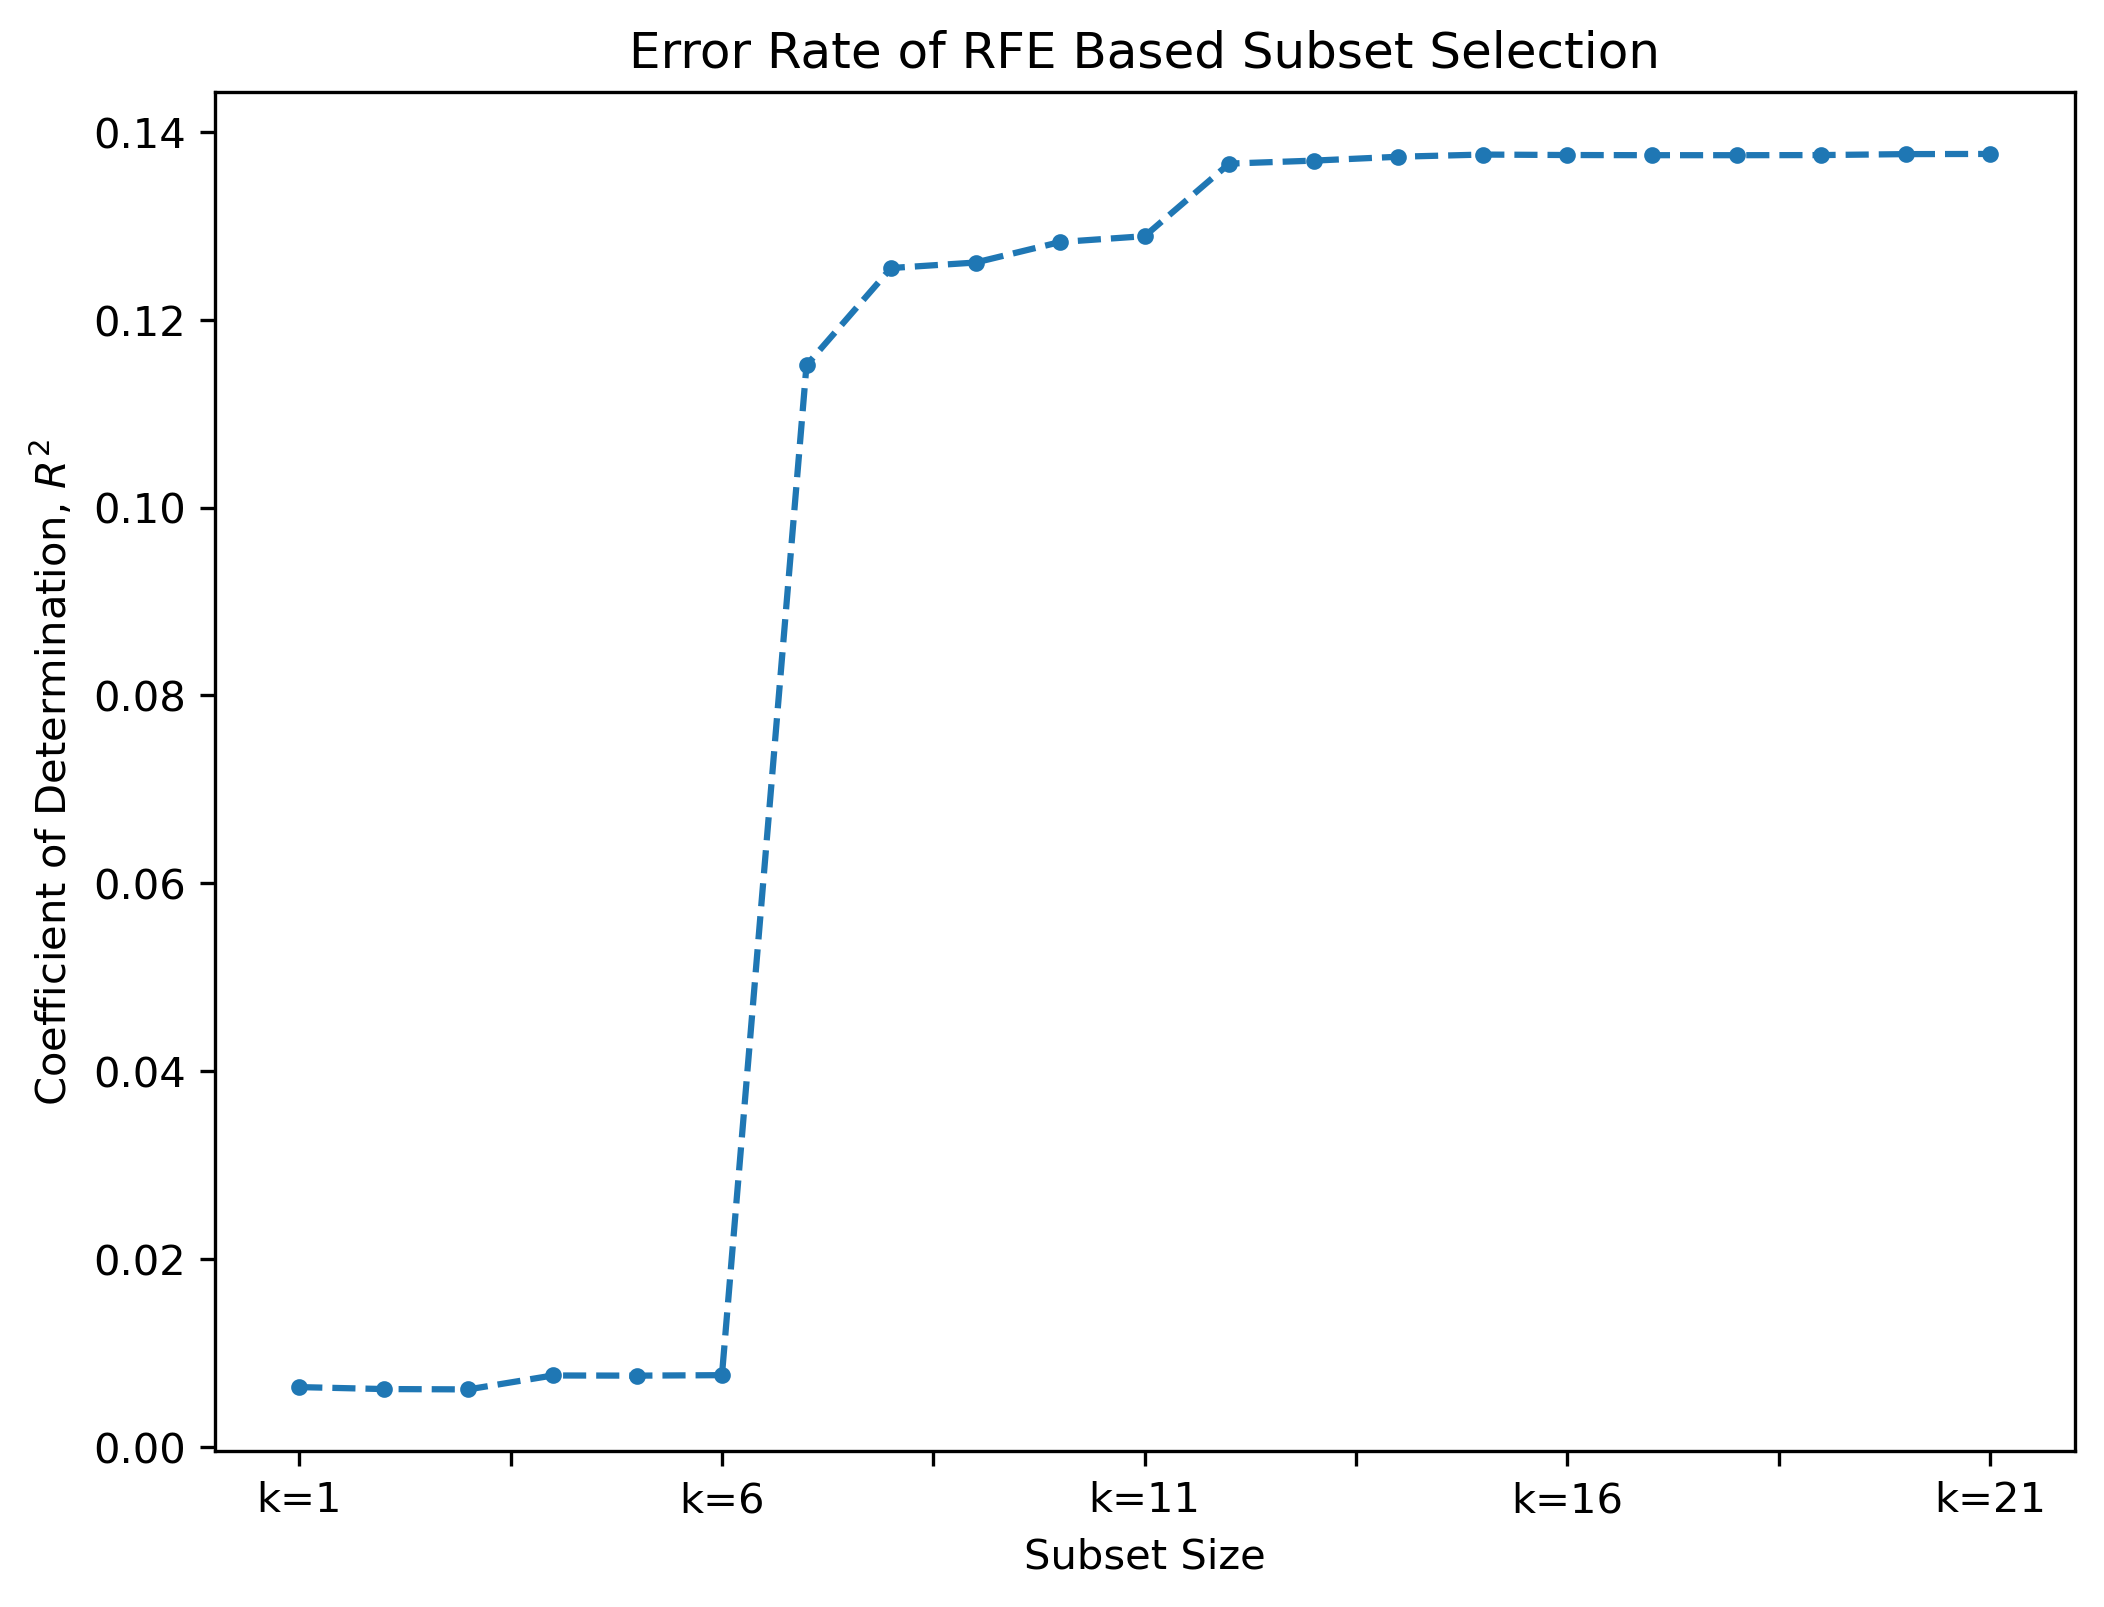

In [64]:
fig3, ax3 = plt.subplots(
    figsize=(8,6),
    dpi=300,
)

df_bss_error.loc['score',:].plot(
    ax=ax3,
    marker='.',
    linestyle='--',
)

ax3.set_ylabel(r'Coefficient of Determination, $R^{2}$')
ax3.set_xlabel('Subset Size')

ax3.set_title('Error Rate of RFE Based Subset Selection')

for ext in save_formats:
    fig3.savefig(figure_dir / f'rfe_bss_r2.{ext}')

plt.show()

## Principal Component Regression

In [65]:
from sklearn.decomposition import PCA

p = len(df_reg.columns)

df_pca = pd.DataFrame(
    data=[],
    index=['score','rmse'],
    columns=[f'k={ii}' for ii in range(1, p)],
)

for k in range(1, p):
    lin_reg_pca = make_pipeline(
        StandardScaler(),
        # https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
        PCA(n_components=k),
        LinearRegression(fit_intercept=True),
    ).fit(X_reg_train, y_reg_train)

    score = lin_reg_pca.score(X_reg_test, y_reg_test)
    
    df_pca.loc['score',f'k={k}'] = lin_reg_pca.score(X_reg_test, y_reg_test)
    df_pca.loc['rmse',f'k={k}'] = mean_squared_error(
        y_true=y_reg_test,
        y_pred=lin_reg_pca.predict(X_reg_test),
        squared=False,
    )

df_reg_results.loc['PCA','score'] = df_pca.loc['score',:].max()
df_reg_results.loc['PCA','rmse'] = df_pca.loc['rmse',:].min()

display(df_pca)

k=1       k=2        k=3        k=4        k=5       k=6  \
score   0.006074  0.007728   0.020696   0.081045    0.10858  0.109296   
rmse   12.425104  12.41476  12.333372  11.947308  11.766954  11.76223   

             k=7        k=8        k=9       k=10       k=11       k=12  \
score   0.109169    0.11295    0.12939   0.131281   0.134188   0.135079   
rmse   11.763066  11.738079  11.628797  11.616162  11.596709  11.590739   

           k=13       k=14       k=15       k=16       k=17       k=18  \
score  0.136778   0.136767   0.137412   0.137411   0.137453   0.137465   
rmse   11.57935  11.579425  11.575096  11.575104  11.574823  11.574745   

           k=19       k=20  
score  0.137504   0.137434  
rmse   11.57448  11.574948

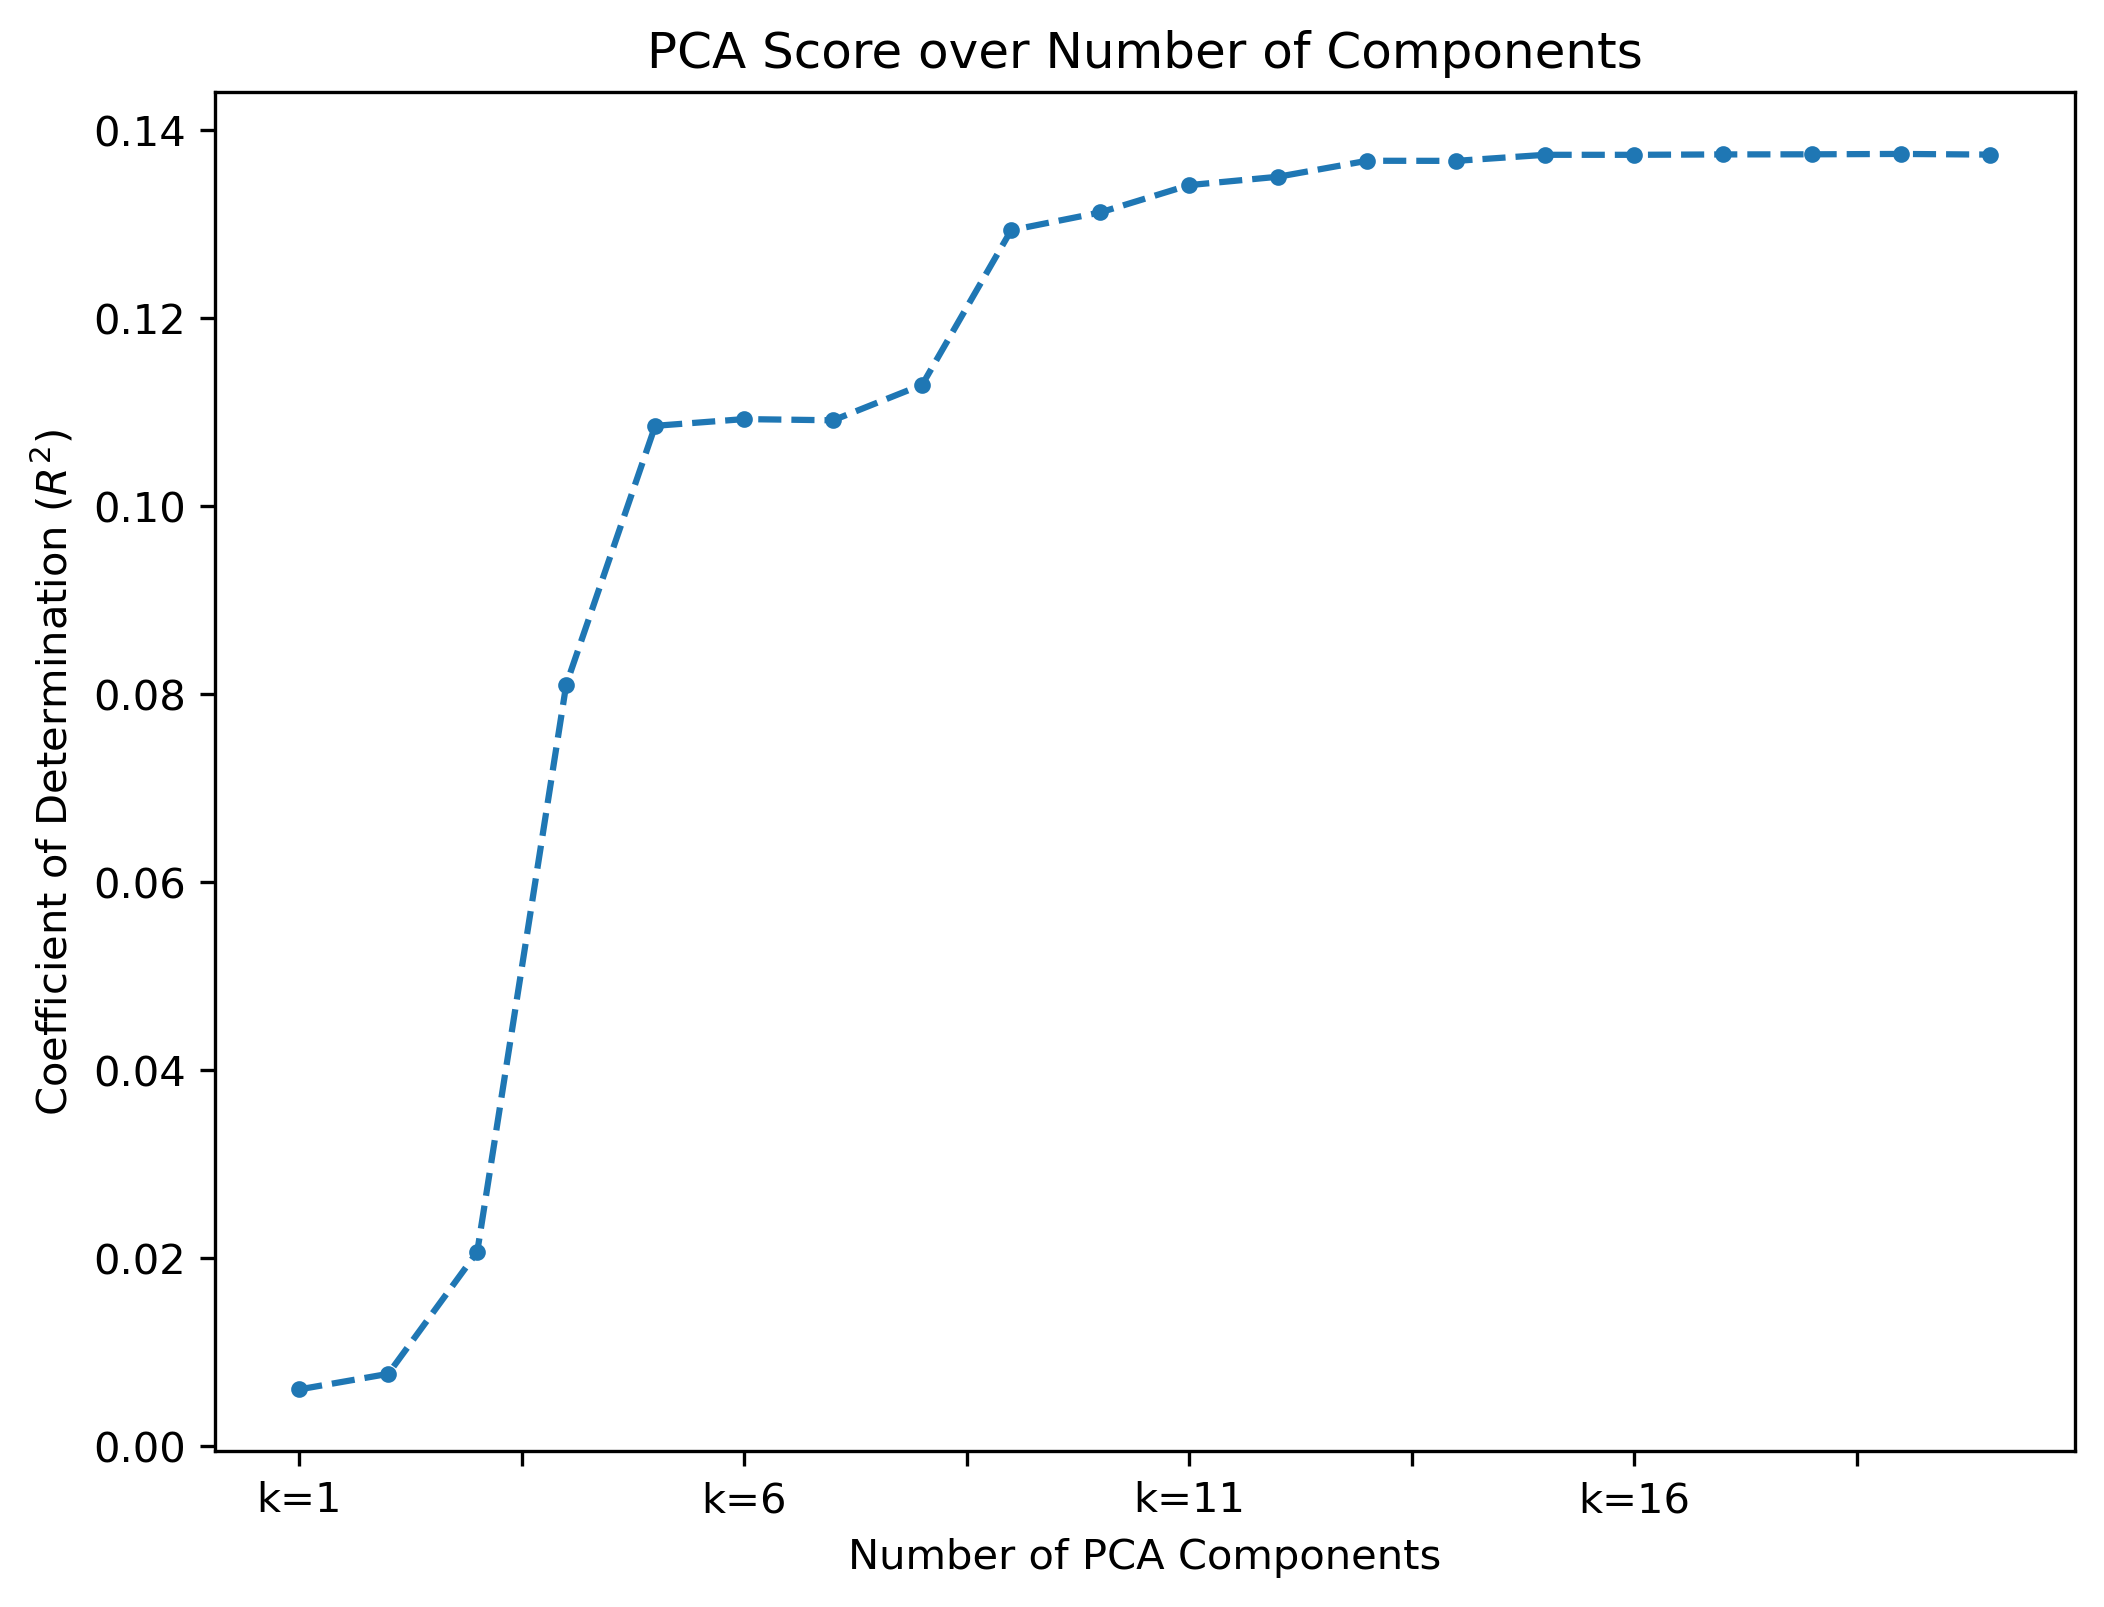

In [66]:
fig4, ax4 = plt.subplots(
    figsize=(8,6),
    dpi=300,
)

df_pca.loc['score',:].plot(
    marker='.',
    linestyle='--',
    ax=ax4
)
ax4.set_ylabel(r'Coefficient of Determination ($R^{2}$)')
ax4.set_xlabel('Number of PCA Components')
ax4.set_title('PCA Score over Number of Components')

for ext in save_formats:
    fig4.savefig(figure_dir / f'pca_r2.{ext}')


plt.show()

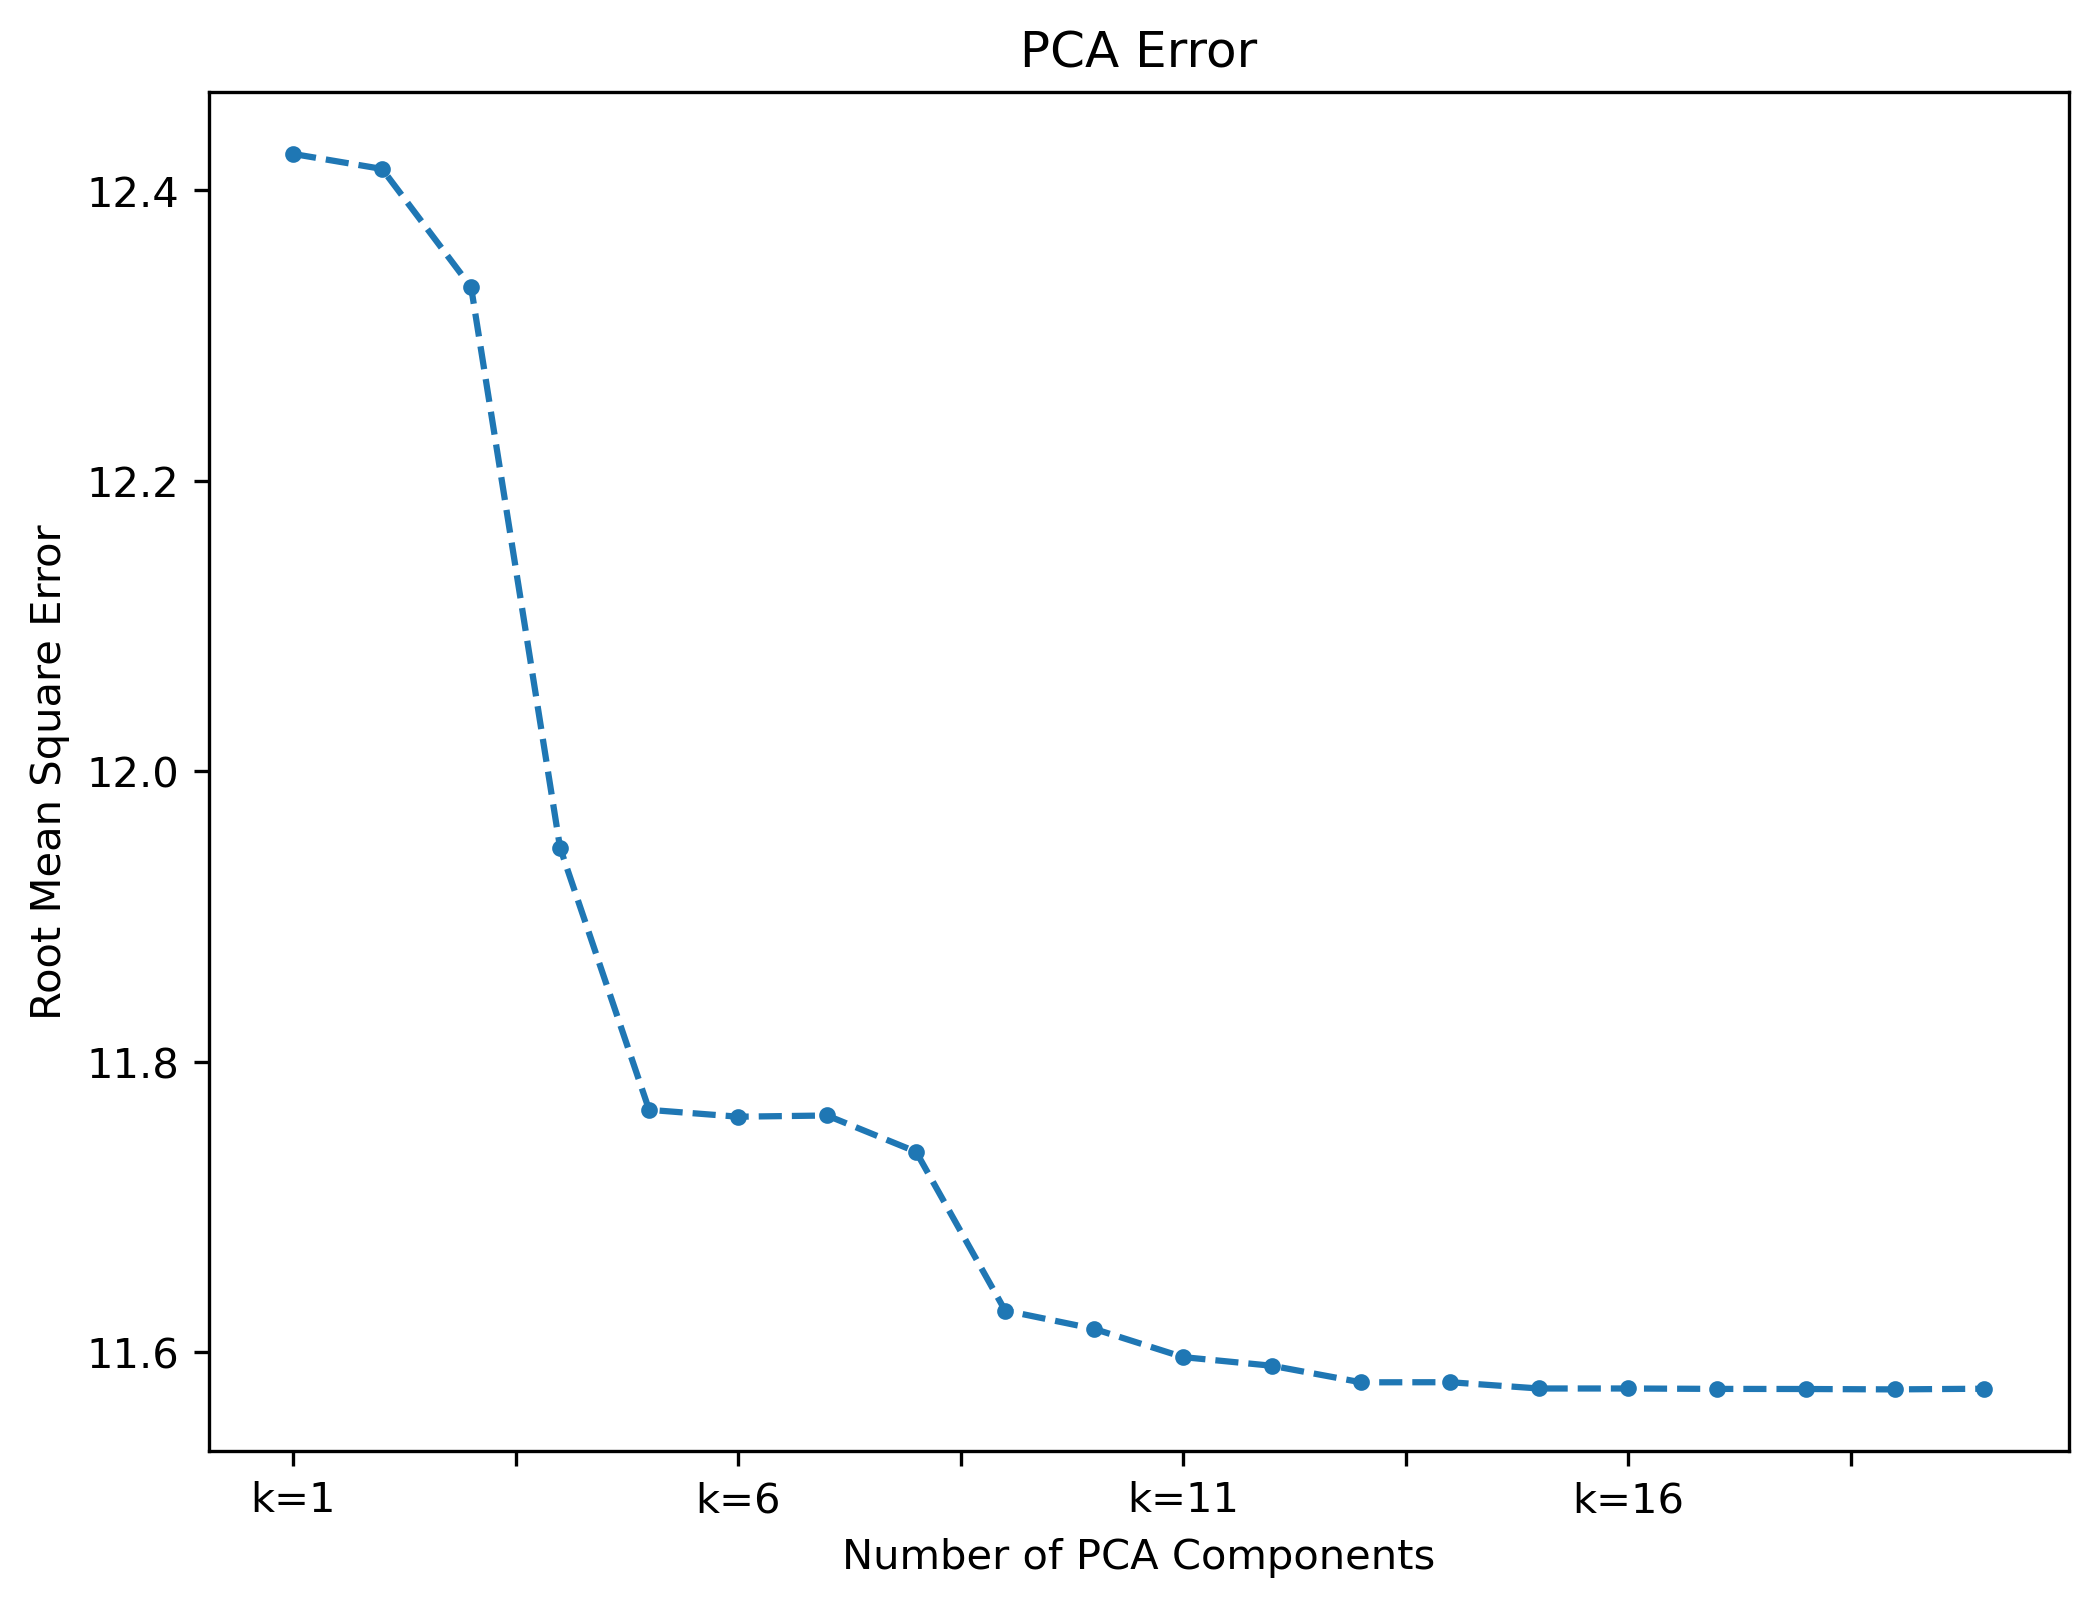

In [67]:
fig5, ax5 = plt.subplots(
    figsize=(8,6),
    dpi=300,
)

df_pca.loc['rmse',:].plot(
    marker='.',
    linestyle='--',
    ax=ax5
)
ax5.set_ylabel(r'Root Mean Square Error')
ax5.set_xlabel('Number of PCA Components')
ax5.set_title('PCA Error')

for ext in save_formats:
    fig5.savefig(figure_dir / f'pca_rmse.{ext}')


plt.show()

In [68]:
df_reg_results

score       rmse
Linear                 0.038648  12.219802
Ridge                   0.03853  12.220549
Lasso                  0.006472  12.422618
RFE Based Best Subset  0.137647  11.573523
PCA                    0.137504   11.57448

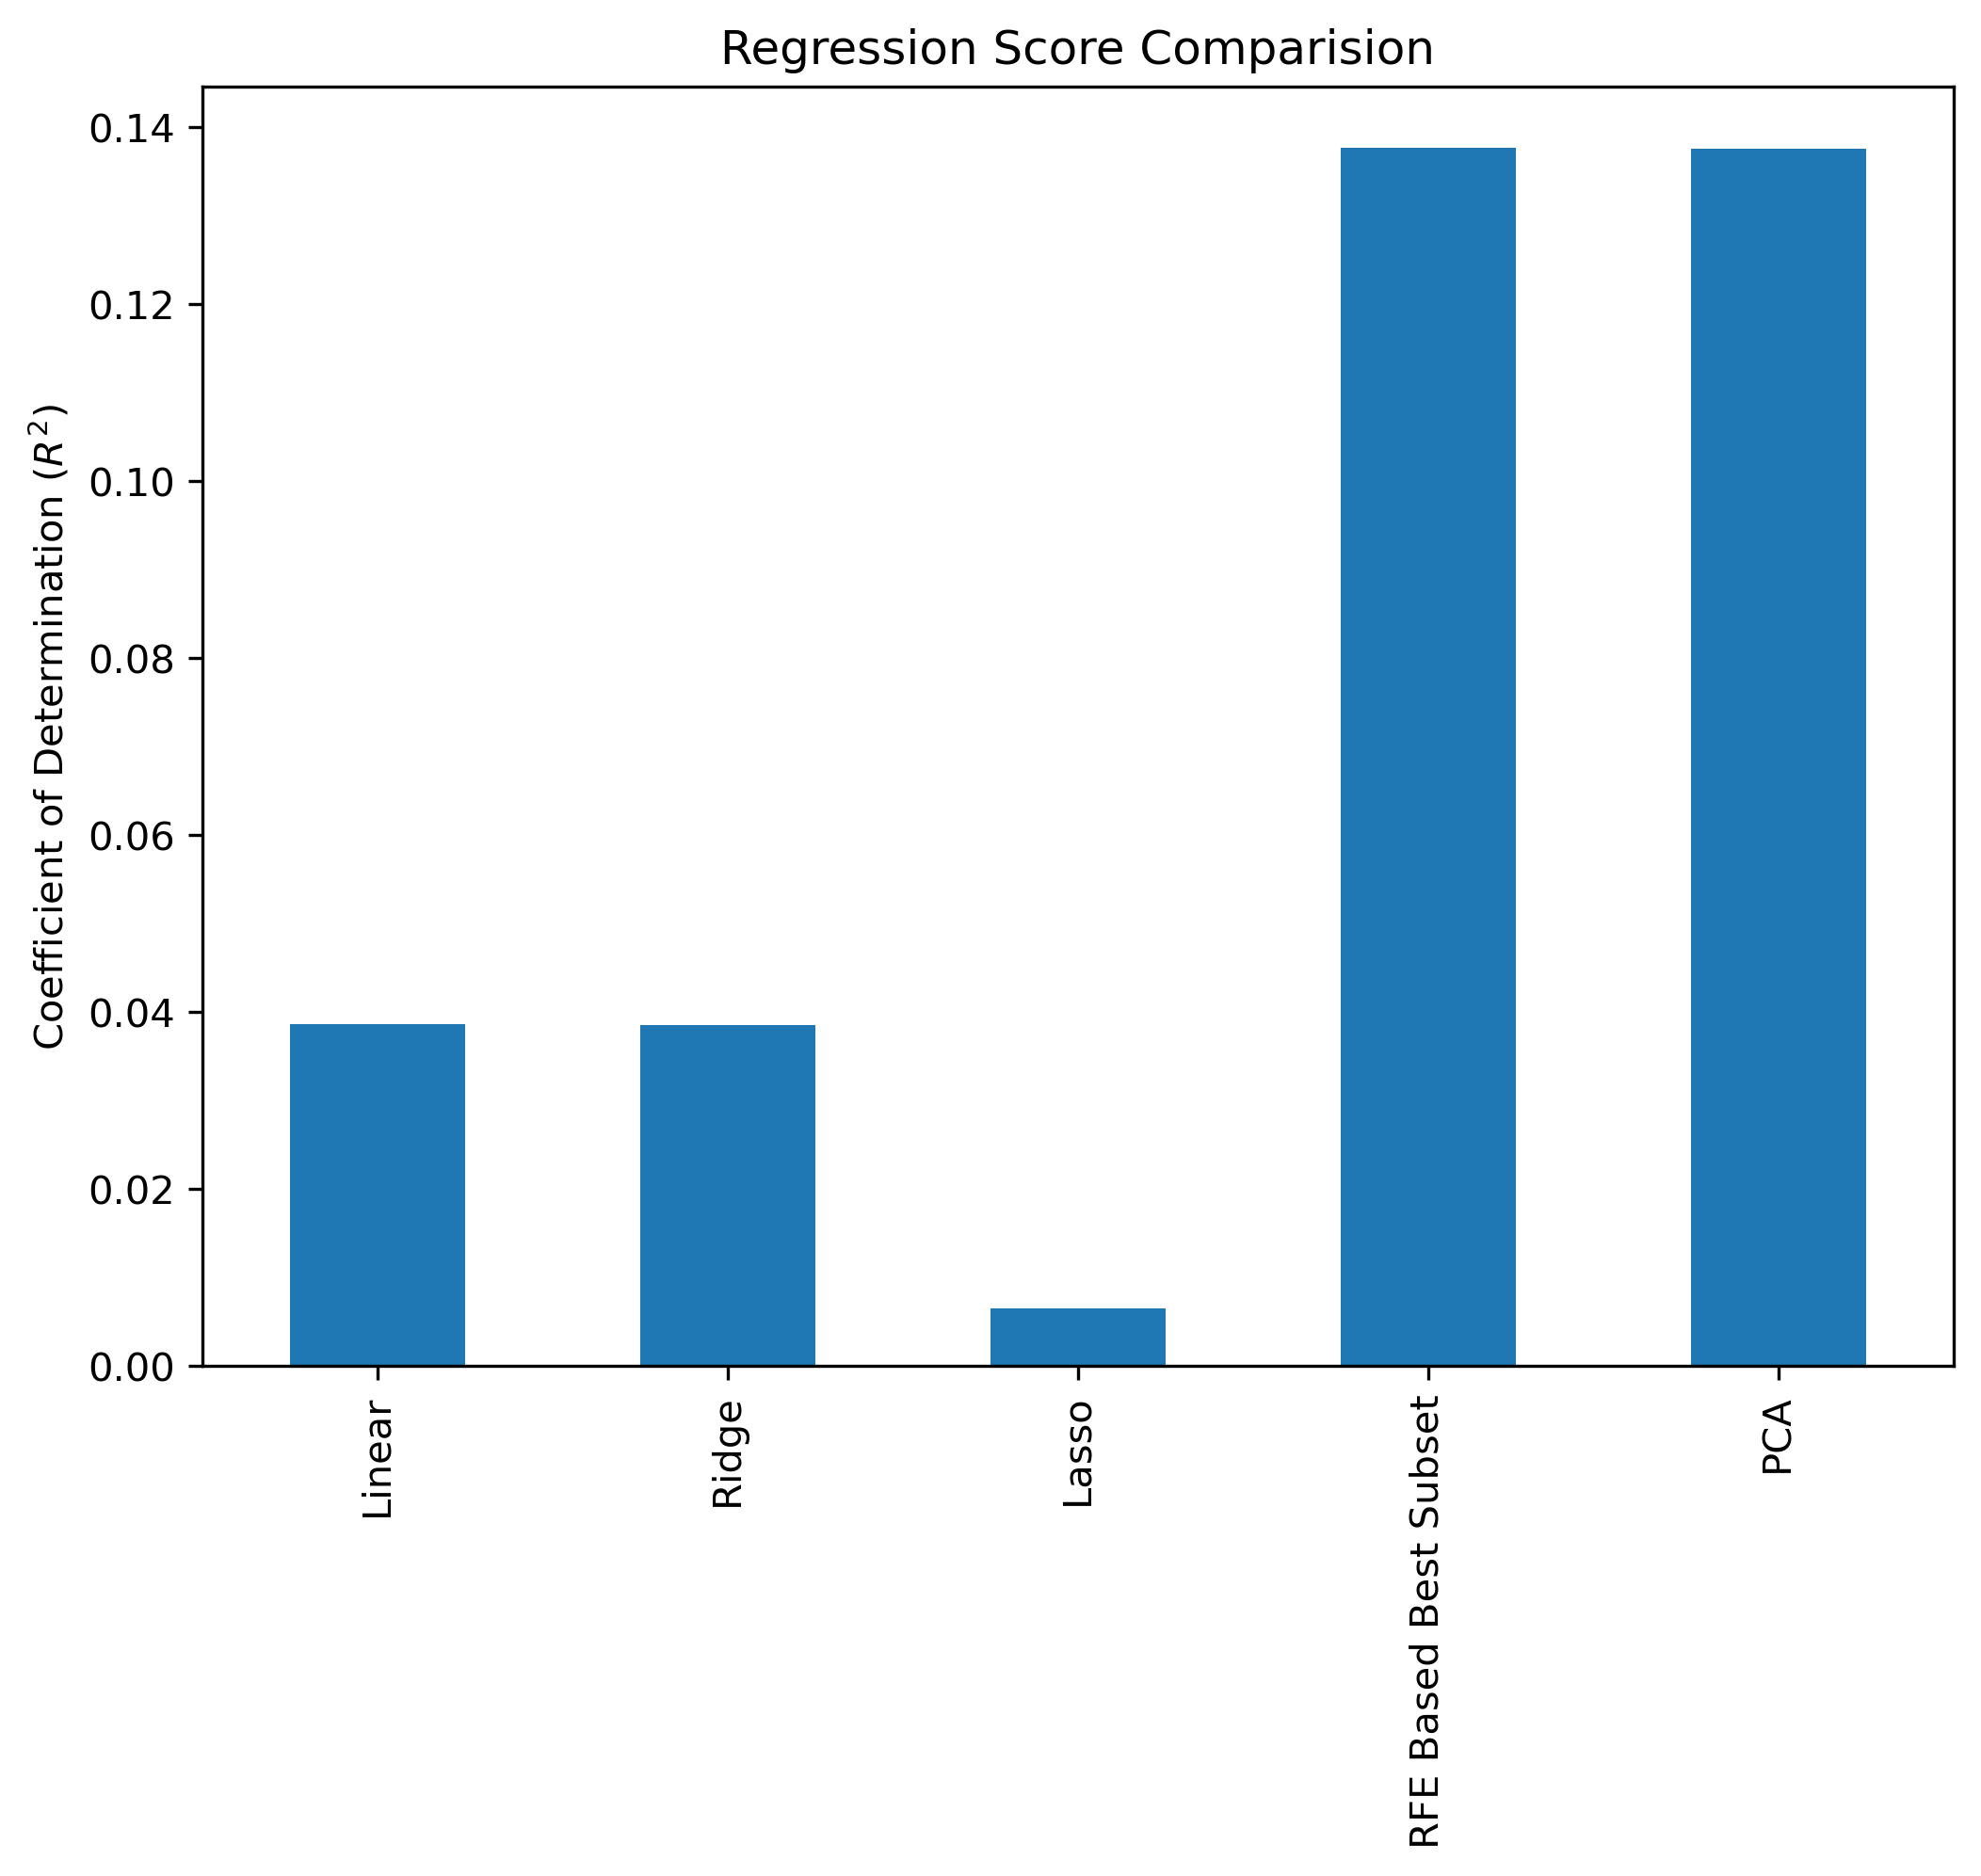

In [69]:
fig_reg_res_score, ax_reg_res_score = plt.subplots(
    figsize=(8,6),
    dpi=300,
)

df_reg_results.score.plot(
    kind='bar',
    ylabel=r'Coefficient of Determination ($R^{2}$)',
    title='Regression Score Comparision',
    ax=ax_reg_res_score
)

for ext in save_formats:
    fig_reg_res_score.savefig(figure_dir / f'score_reg_compare.{ext}')

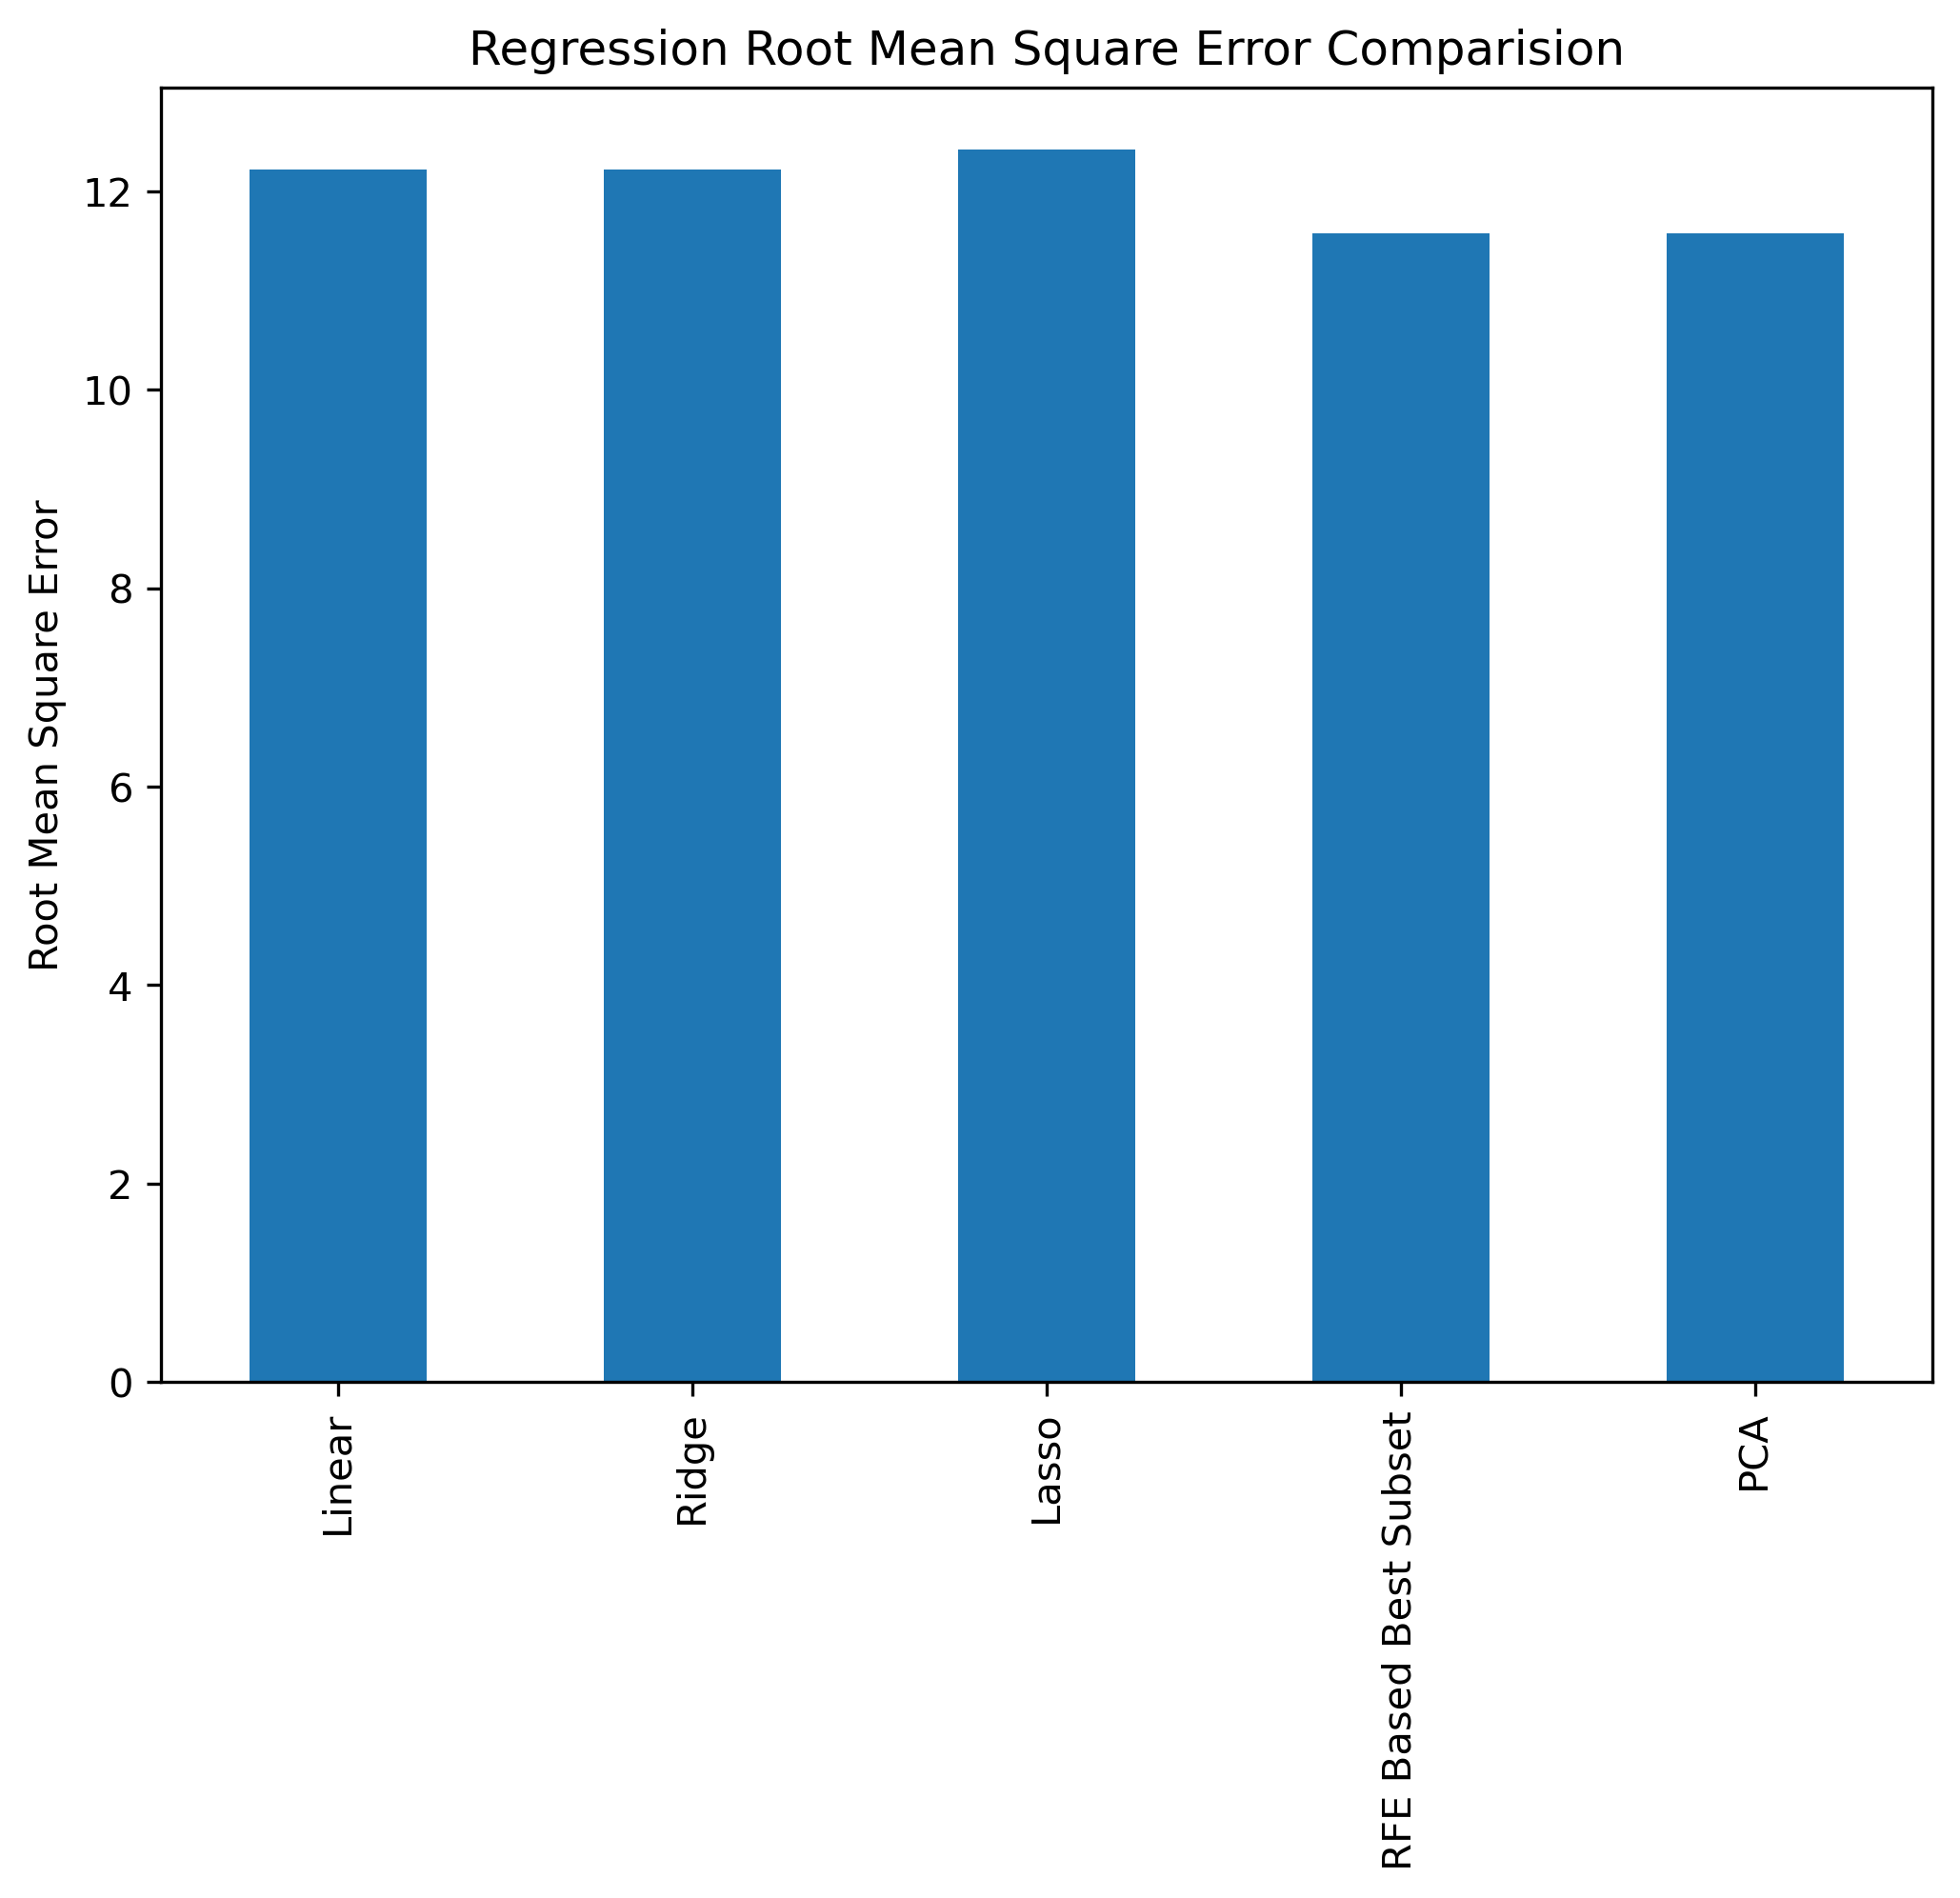

In [70]:
fig_reg_res_rmse, ax_reg_res_rmse = plt.subplots(
    figsize=(8,6),
    dpi=300,
)

df_reg_results.rmse.plot(
    kind='bar',
    ylabel=r'Root Mean Square Error',
    title='Regression Root Mean Square Error Comparision',
    ax=ax_reg_res_rmse,
)

for ext in save_formats:
    fig_reg_res_rmse.savefig(figure_dir / f'rmse_reg_compare.{ext}')

In [194]:
# transform data to lower dimensions
# chose 9 for PCA based on above analysis
from sklearn.feature_selection import SelectKBest, f_regression

pca = PCA(n_components=9).fit(X_reg_train, y_reg_train)
best_subset = SelectKBest(f_regression, k=20).fit(X_reg_train, y_reg_train)

X_pca_reg_train = pca.transform(X_reg_train)
X_best_subset_reg_train = best_subset.transform(X_reg_train)

X_pca_reg_test = pca.transform(X_reg_test)
X_best_subset_reg_test = best_subset.transform(X_reg_test)

# Regression

Another interesting question is whether the number of days to put out a fire can be predicted. Consider linear regression as a starting point.

Split the data set into a training and testing set.

In [195]:
df_subset_reg_results = pd.DataFrame(
    data=[],
    index=[
        'Linear PCA',
        'Linear Best Subset',
        'Ridge PCA',
        'Ridge Best Subset',
        'Lasso PCA',
        'Lasso Best Subset',
    ],
    columns=['score','rmse'],
)

## Linear Regression

In [196]:
lin_reg_pca = make_pipeline(
    StandardScaler(),
    LinearRegression(fit_intercept=False),
).fit(X_pca_reg_train, y_reg_train)

lin_reg_best_subset = make_pipeline(
    StandardScaler(),
    LinearRegression(fit_intercept=False),
).fit(X_best_subset_reg_train, y_reg_train)

y_lr_pca = lin_reg_pca.predict(X_pca_reg_test)
y_lr_best_subset = lin_reg_best_subset.predict(X_best_subset_reg_test)

msqr_err_lr_pca = np.mean(np.square(y_lr_pca - y_reg_test))
display(msqr_err_lr_pca)
msqr_err_lr_best_subset = np.mean(np.square(y_lr_best_subset - y_reg_test))
display(msqr_err_lr_best_subset)

# Note that the pipeline score calls the score of the final estimator which in this case is LinearRegression.score
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline.score
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score
lin_score_pca = lin_reg_pca.score(X_pca_reg_test, y_reg_test)
lin_score_best_subset = lin_reg_best_subset.score(X_best_subset_reg_test, y_reg_test)

df_subset_reg_results.loc['Linear PCA','score'] = lin_score_pca
df_subset_reg_results.loc['Linear PCA','rmse'] = mean_squared_error(y_lr_pca, y_reg_test, squared=False)
display(lin_score_pca)
df_subset_reg_results.loc['Linear Best Subset','score'] = lin_score_best_subset
df_subset_reg_results.loc['Linear Best Subset','rmse'] = mean_squared_error(y_lr_best_subset, y_reg_test, squared=False)
display(lin_score_best_subset)

163.8254183416912

149.32976000869948

-0.05471553499536097

0.03860817623669566

## Ridge Regression

In [197]:
ridge_reg_pca = make_pipeline(
    StandardScaler(),
    Ridge(fit_intercept=False),
).fit(X_pca_reg_train, y_reg_train)

ridge_reg_best_subset = make_pipeline(
    StandardScaler(),
    Ridge(fit_intercept=False),
).fit(X_best_subset_reg_train, y_reg_train)

y_ridge_pca = ridge_reg_pca.predict(X_pca_reg_test)
y_ridge_best_subset = ridge_reg_best_subset.predict(X_best_subset_reg_test)

msqr_err_ridge_pca = np.mean(np.square(y_ridge_pca - y_reg_test))
display(msqr_err_ridge_pca)
msqr_err_ridge_best_subset = np.mean(np.square(y_ridge_best_subset - y_reg_test))
display(msqr_err_ridge_best_subset)

# Note that the pipeline score calls the score of the final estimator which in this case is LinearRegression.score
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline.score
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score
ridge_score_pca = ridge_reg_pca.score(X_pca_reg_test, y_reg_test)
ridge_score_best_subset = ridge_reg_best_subset.score(X_best_subset_reg_test, y_reg_test)

df_subset_reg_results.loc['Ridge PCA','score'] = ridge_score_pca
df_subset_reg_results.loc['Ridge PCA','rmse'] = mean_squared_error(y_ridge_pca, y_reg_test, squared=False)
display(ridge_score_pca)
df_subset_reg_results.loc['Ridge Best Subset','score'] = ridge_score_best_subset
df_subset_reg_results.loc['Ridge Best Subset','rmse'] = mean_squared_error(y_ridge_best_subset, y_reg_test, squared=False)
display(ridge_score_best_subset)

163.82543347583336

149.3479873916082

-0.05471563242966604

0.03849082751199573

## Lasso Regression

In [198]:
lasso_reg_pca = make_pipeline(
    StandardScaler(),
    Lasso(fit_intercept=False),
).fit(X_pca_reg_train, y_reg_train)

lasso_reg_best_subset = make_pipeline(
    StandardScaler(),
    Lasso(fit_intercept=False),
).fit(X_best_subset_reg_train, y_reg_train)

y_lasso_pca = lasso_reg_pca.predict(X_pca_reg_test)
y_lasso_best_subset = lasso_reg_best_subset.predict(X_best_subset_reg_test)

msqr_err_lasso_pca = np.mean(np.square(y_lasso_pca - y_reg_test))
display(msqr_err_lasso_pca)
msqr_err_lasso_best_subset = np.mean(np.square(y_lasso_best_subset - y_reg_test))
display(msqr_err_lasso_best_subset)

# Note that the pipeline score calls the score of the final estimator which in this case is LinearRegression.score
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline.score
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score
lasso_score_pca = lasso_reg_pca.score(X_pca_reg_test, y_reg_test)
lasso_score_best_subset = lasso_reg_best_subset.score(X_best_subset_reg_test, y_reg_test)

df_subset_reg_results.loc['Lasso PCA','score'] = lasso_score_pca
df_subset_reg_results.loc['Lasso PCA','rmse'] = mean_squared_error(y_lasso_pca, y_reg_test, squared=False)
display(lasso_score_pca)
df_subset_reg_results.loc['Lasso Best Subset','score'] = lasso_score_best_subset
df_subset_reg_results.loc['Lasso Best Subset','rmse'] = mean_squared_error(y_lasso_best_subset, y_reg_test, squared=False)
display(lasso_score_best_subset)

167.70862037116268

154.3214333524533

-0.07971576723933871

0.00647155498114349

In [200]:
df_subset_reg_results

score       rmse
Linear PCA         -0.054716   12.79943
Linear Best Subset  0.038608  12.220056
Ridge PCA          -0.054716  12.799431
Ridge Best Subset   0.038491  12.220801
Lasso PCA          -0.079716  12.950236
Lasso Best Subset   0.006472  12.422618

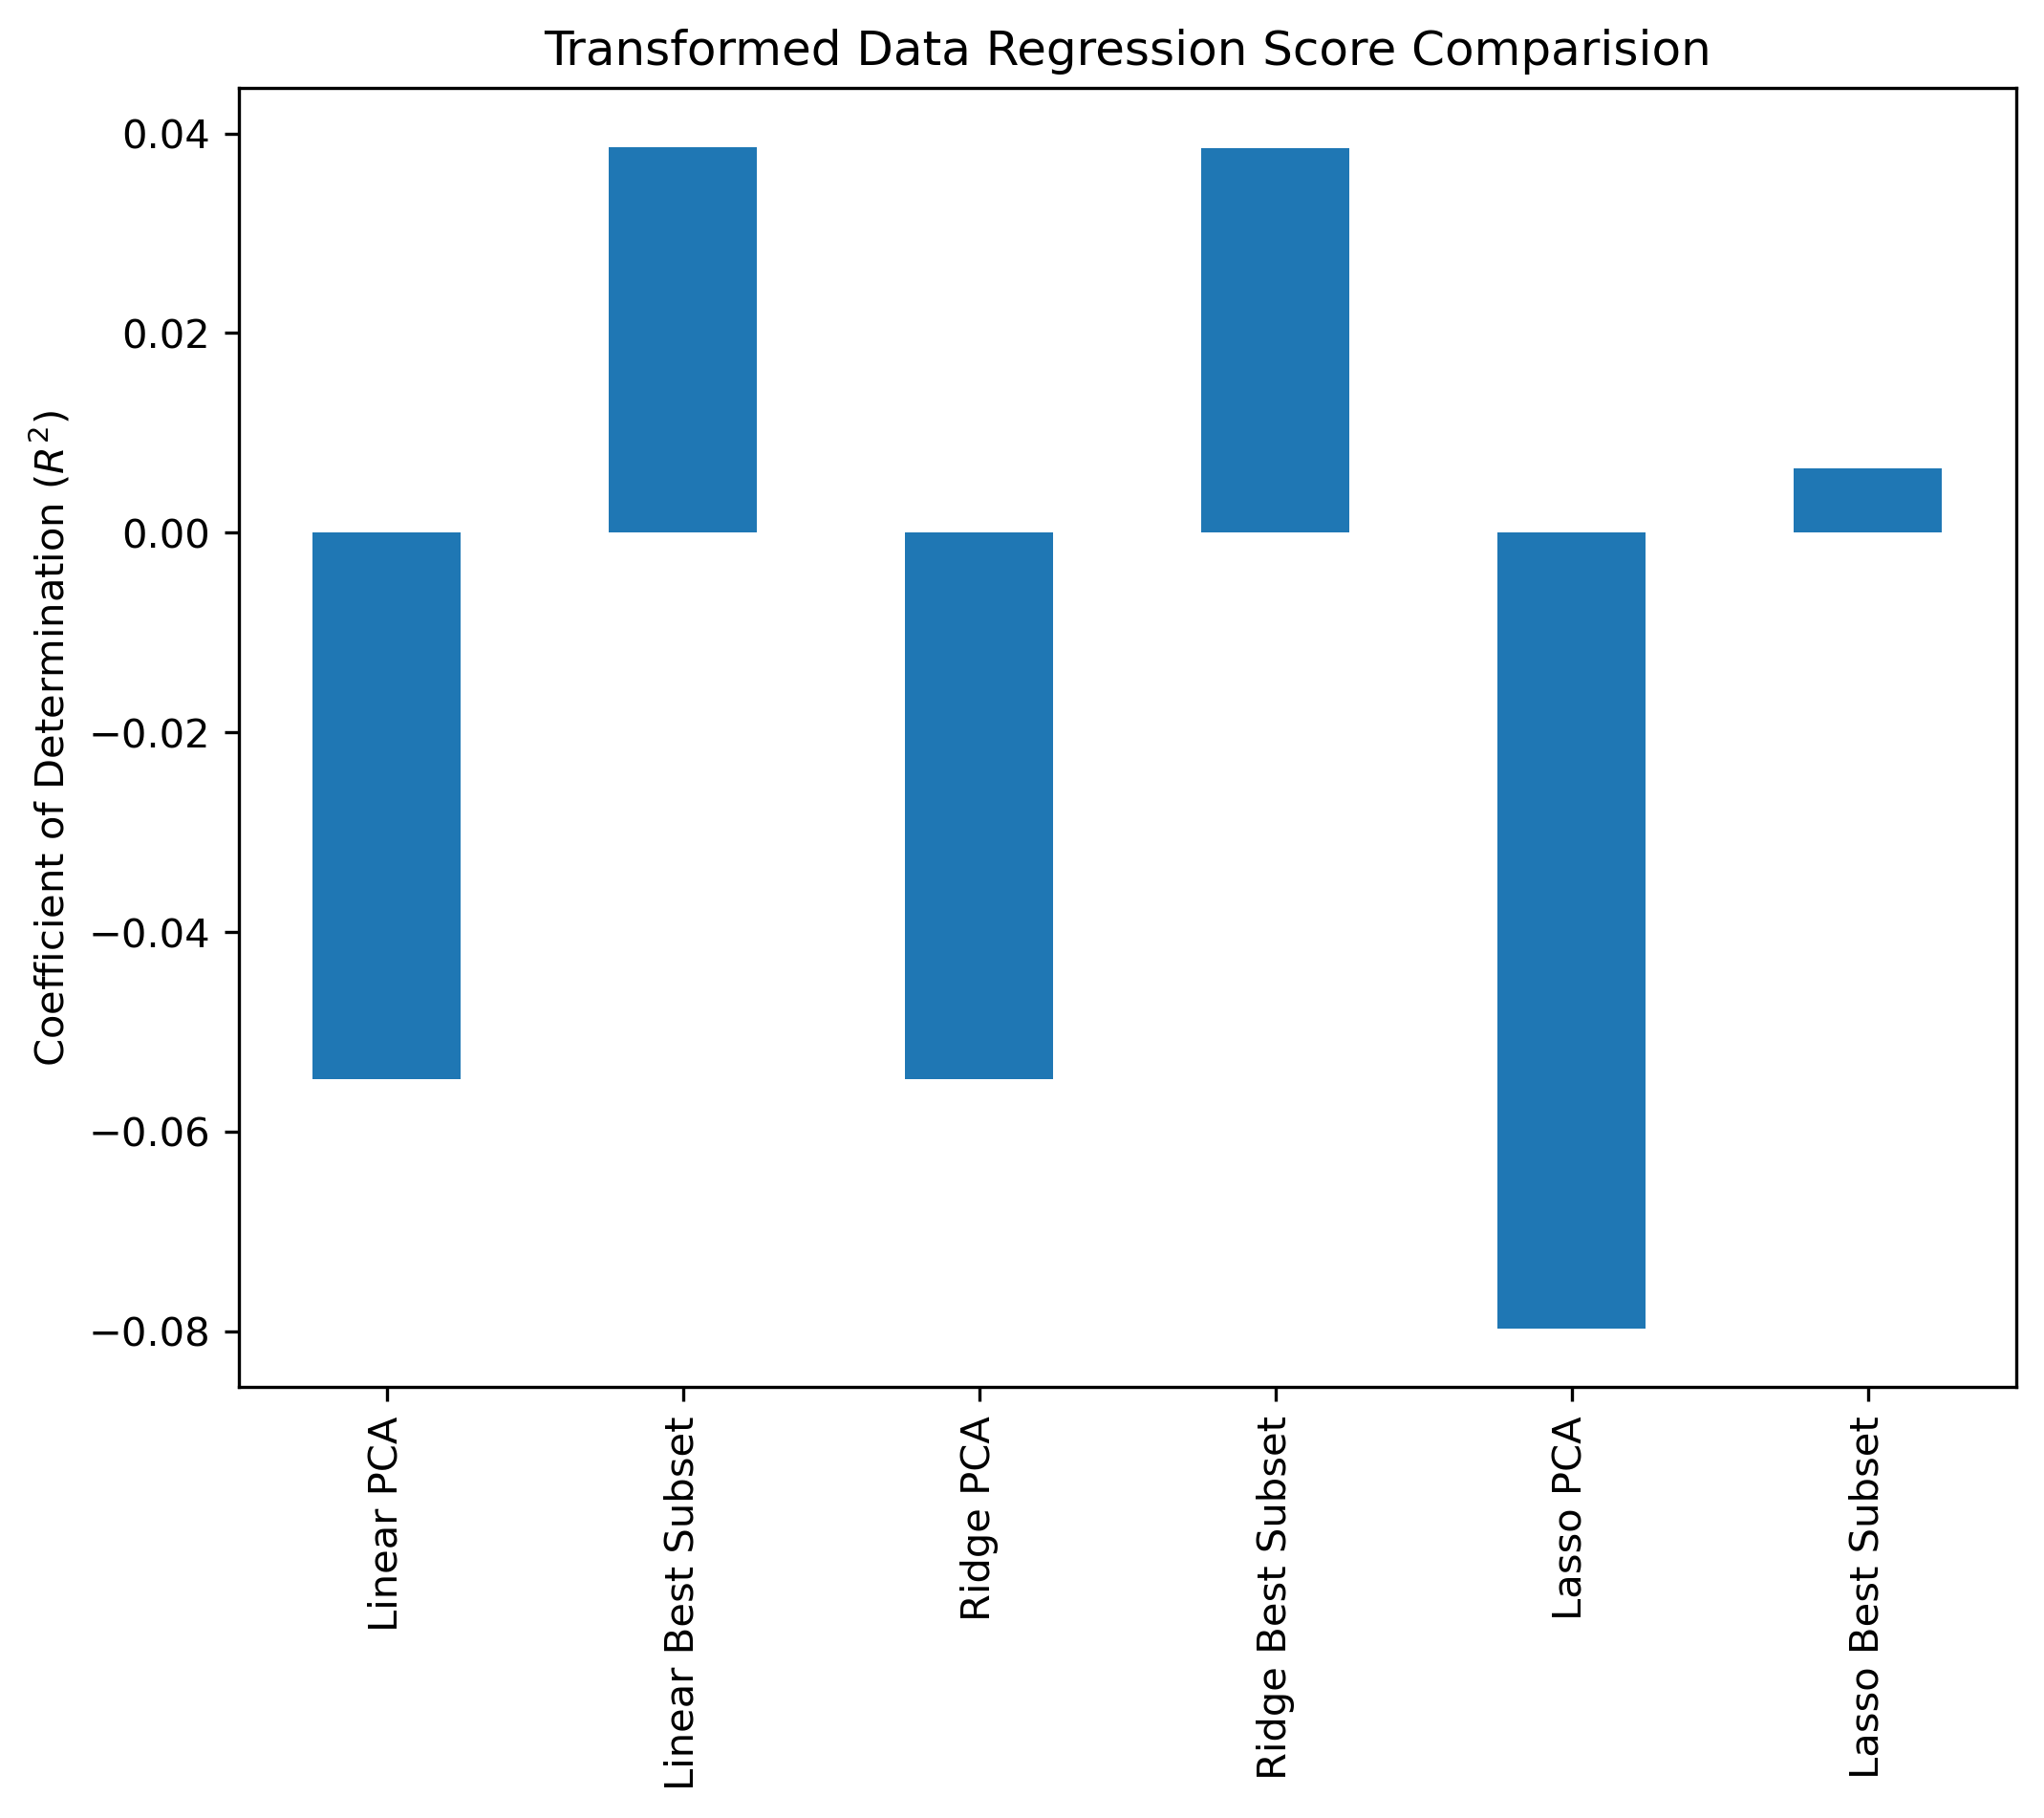

In [201]:
fig_subset_reg_res_score, ax_subset_reg_res_score = plt.subplots(
    figsize=(8,6),
    dpi=300,
)

df_subset_reg_results.score.plot(
    kind='bar',
    ylabel=r'Coefficient of Determination ($R^{2}$)',
    title='Transformed Data Regression Score Comparision',
    ax=ax_subset_reg_res_score
)

for ext in save_formats:
    fig_subset_reg_res_score.savefig(figure_dir / f'score_subset_reg_compare.{ext}')

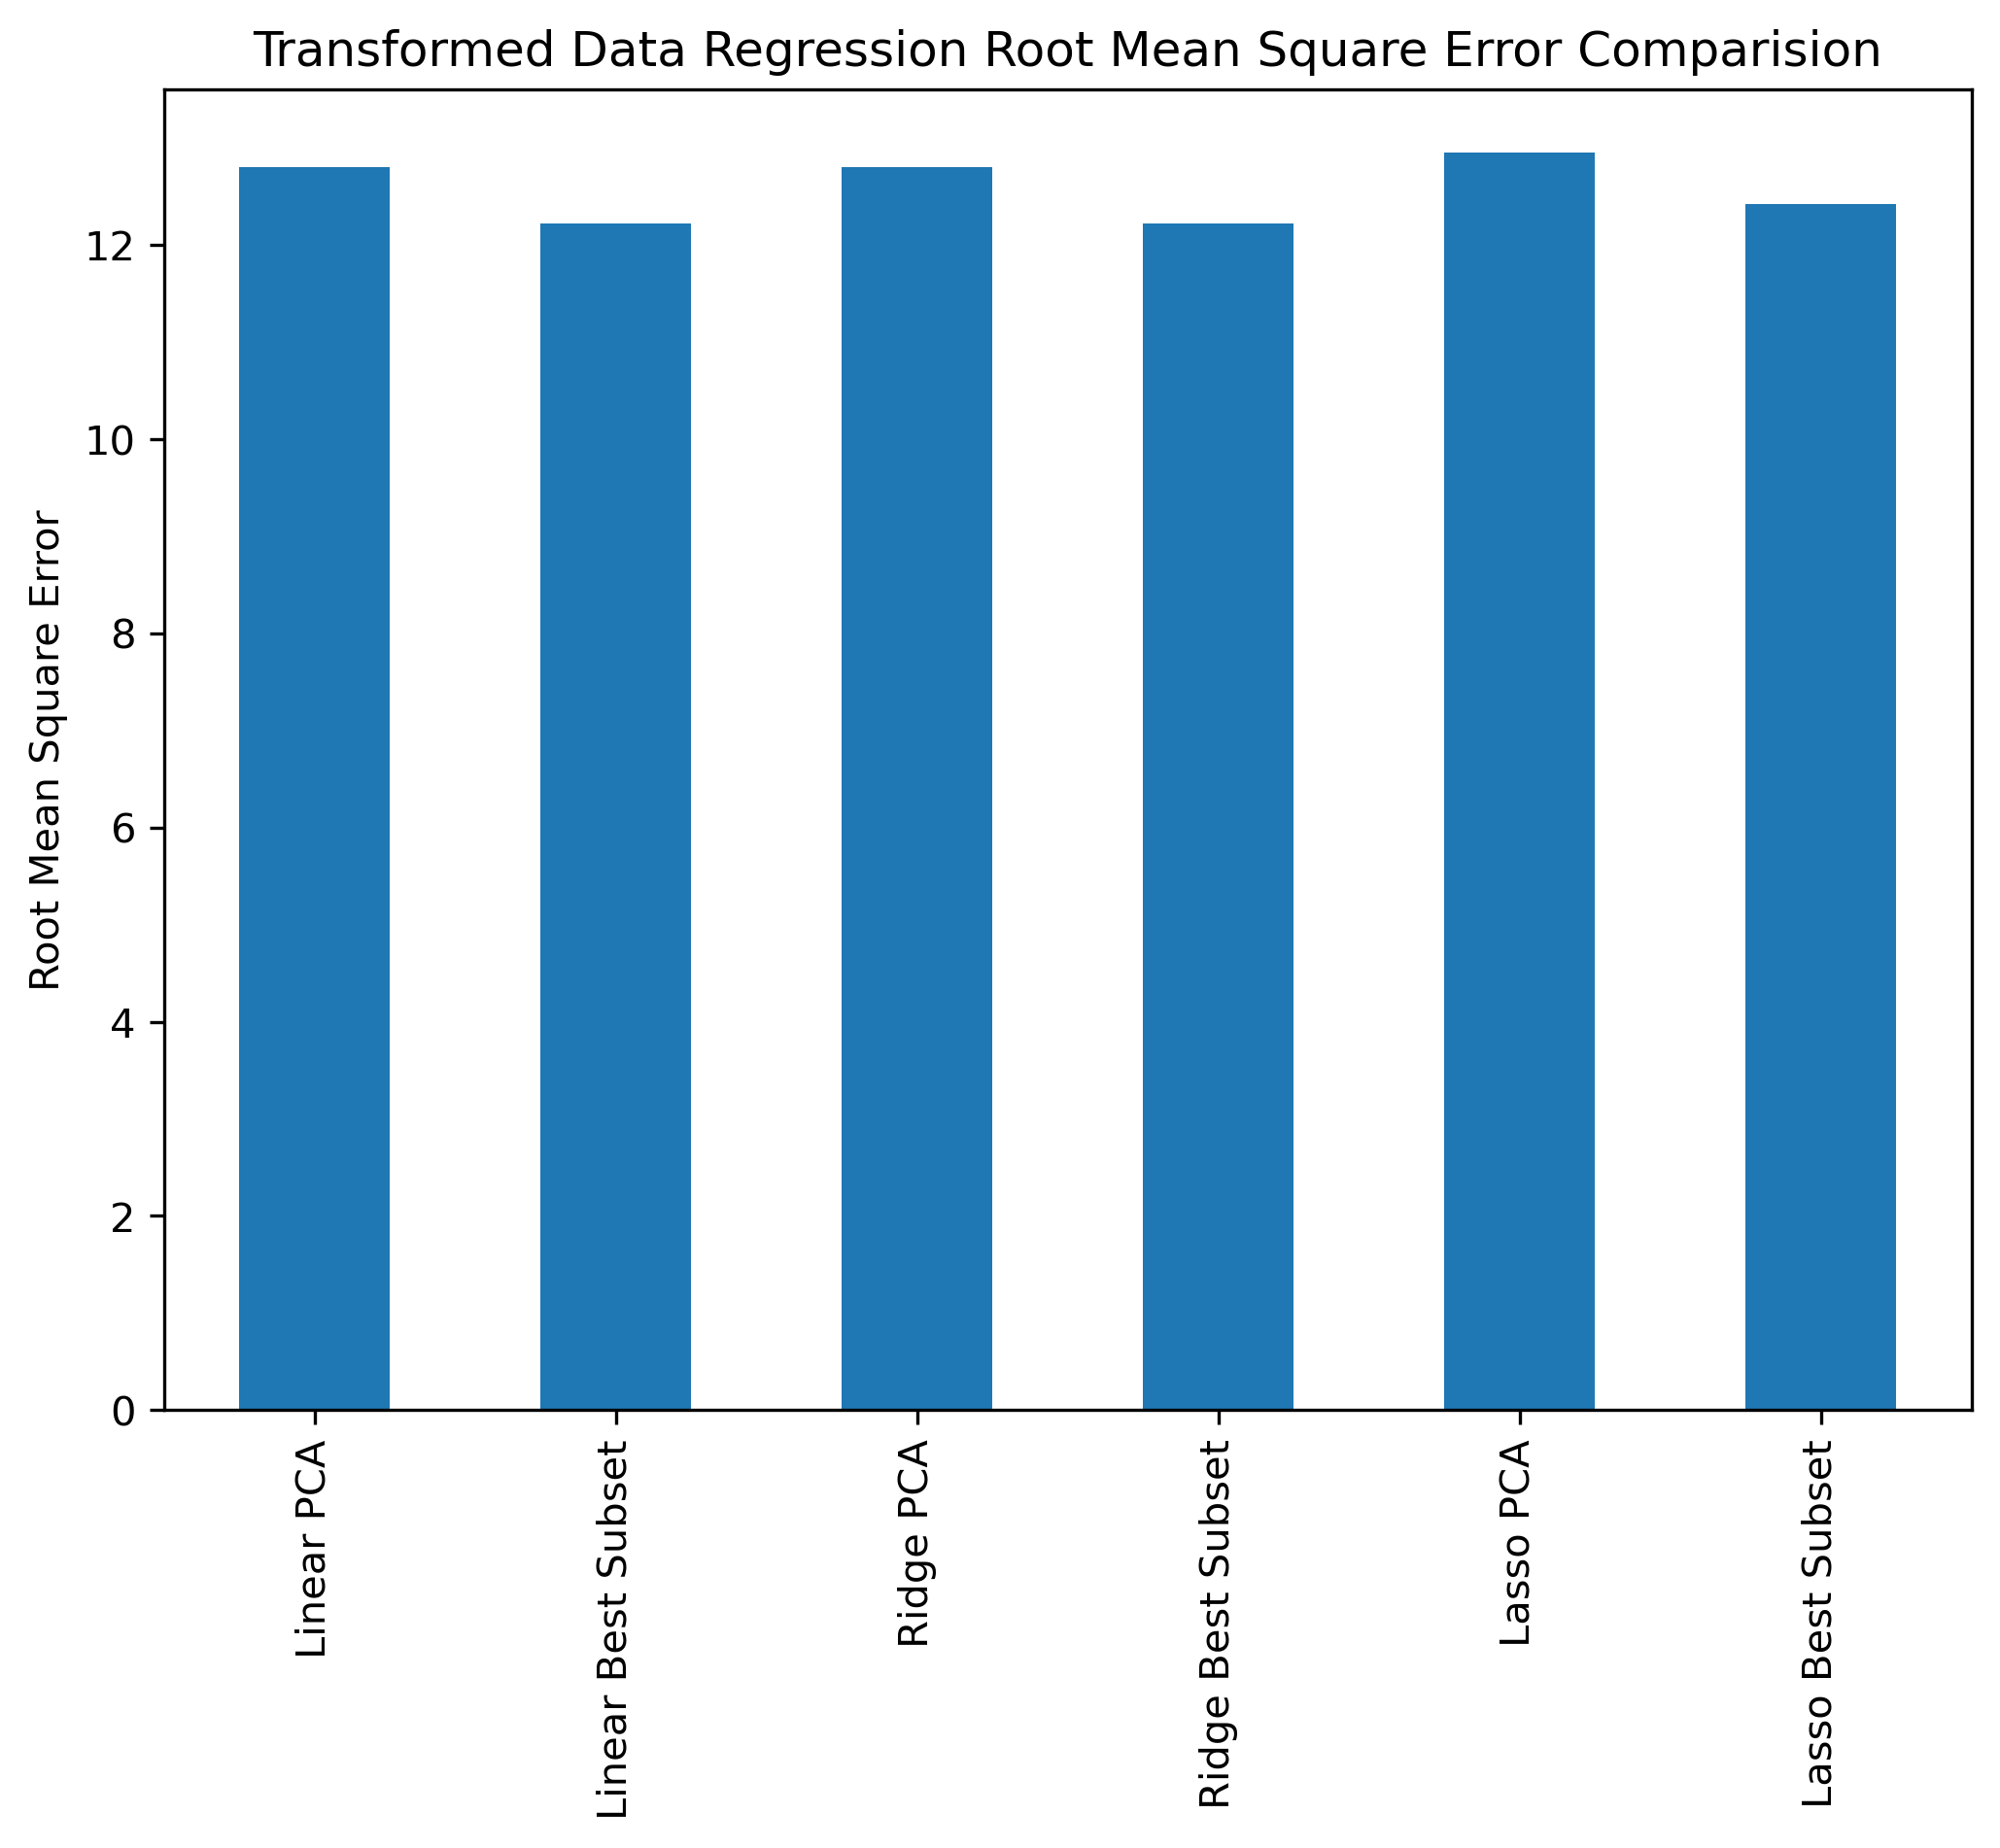

In [202]:
fig_subset_reg_res_rmse, ax_subset_reg_res_rmse = plt.subplots(
    figsize=(8,6),
    dpi=300,
)

df_subset_reg_results.rmse.plot(
    kind='bar',
    ylabel=r'Root Mean Square Error',
    title='Transformed Data Regression Root Mean Square Error Comparision',
    ax=ax_subset_reg_res_rmse,
)

for ext in save_formats:
    fig_subset_reg_res_rmse.savefig(figure_dir / f'rmse_subset_reg_compare.{ext}')